In [6]:
# Run this ONCE in the first cell after a kernel restart:
%matplotlib widget


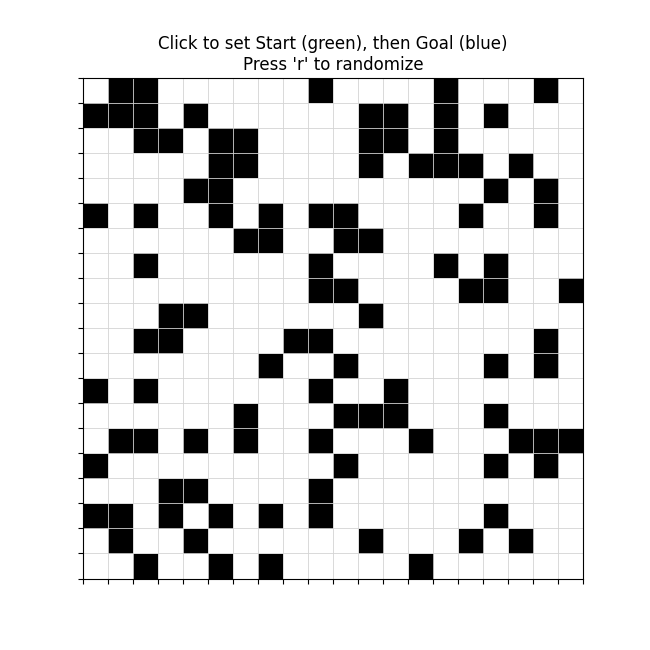

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

FREE, OBST, START, GOAL = 0, 1, 2, 3

def interactive_grid(n=50, obstacle_prob=0.25, seed=None):
    rng = np.random.default_rng(seed)
    grid = (rng.random((n, n)) < obstacle_prob).astype(np.uint8)

    # Colors: 0 free=white, 1 obst=black, 2 start=green, 3 goal=blue
    cmap = ListedColormap(["white", "black", "lime", "dodgerblue"])

    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    im = ax.imshow(
        grid, 
        cmap=cmap, 
        origin="lower", 
        interpolation="none",
        extent=(-0.5, n-0.5, -0.5, n-0.5),
        vmin = 0,
        vmax = 3
    )
    ax.set_xticks(np.arange(-0.5, n, 1)); ax.set_yticks(np.arange(-0.5, n, 1))
    ax.grid(color="lightgray", linewidth=0.6)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_title("Click to set Start (green), then Goal (blue)\nPress 'r' to randomize", fontsize=12)

    status = ax.text(0, n+0.2, "", fontsize=10, va="bottom")

    state = {"stage": "start"}  # "start" -> "goal" -> "done"

    def to_index(xf, yf):
        """Map figure coords to integer cell indices safely."""
        if xf is None or yf is None:
            return None
        c = int(np.floor(xf + 0.5))
        r = int(np.floor(yf + 0.5))
        if 0 <= r < n and 0 <= c < n:
            return r, c
        return None

    def on_click(event):
        idx = to_index(event.xdata, event.ydata)
        if event.inaxes != ax or idx is None:
            return
        r, c = idx
        if grid[r, c] == OBST:
            status.set_text("⚠️ That cell is an obstacle. Click a white cell.")
            fig.canvas.draw_idle()
            return

        if state["stage"] == "start":
            grid[grid == START] = FREE
            grid[r, c] = START
            state["stage"] = "goal"
            status.set_text("✅ Start set. Now click the Goal (blue).")
        elif state["stage"] == "goal":
            grid[grid == GOAL] = FREE
            grid[r, c] = GOAL
            state["stage"] = "done"
            status.set_text("✅ Start & Goal set.")
        im.set_data(grid)
        fig.canvas.draw_idle()

    def on_key(event):
        if event.key == "r":
            # re-randomize obstacles, keep start/goal clear
            grid[:, :] = (rng.random((n, n)) < obstacle_prob).astype(np.uint8)
            grid[grid == START] = FREE
            grid[grid == GOAL]  = FREE
            state["stage"] = "start"
            status.set_text("Map randomized. Click Start (green).")
            im.set_data(grid)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("button_press_event", on_click)
    fig.canvas.mpl_connect("key_press_event", on_key)

    plt.show()
    return grid
#set up
map_sz = 20
obs_prob = 0.25
seed = None
grid = interactive_grid(map_sz,obs_prob, seed)  # seed=None => different map each run


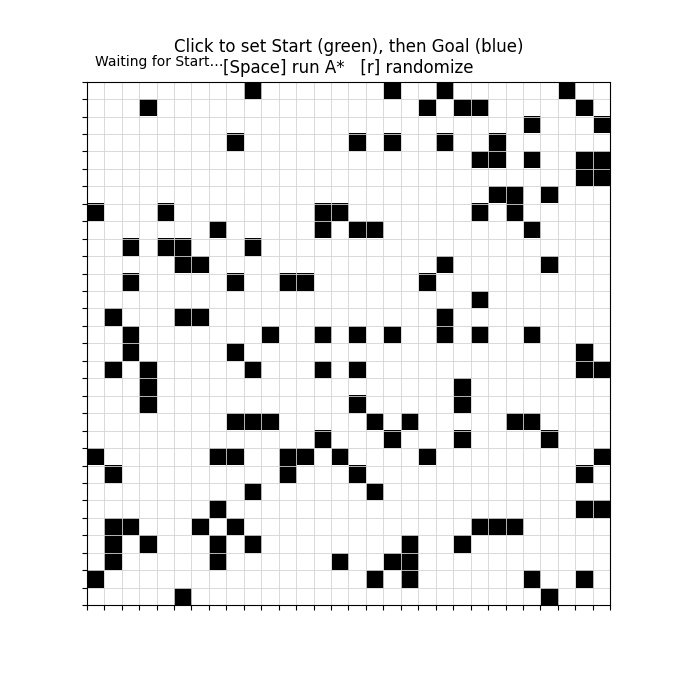

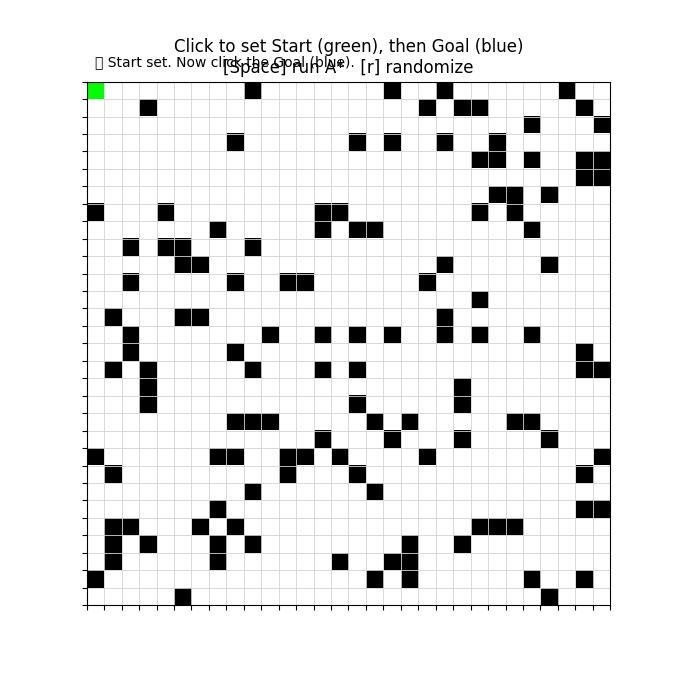

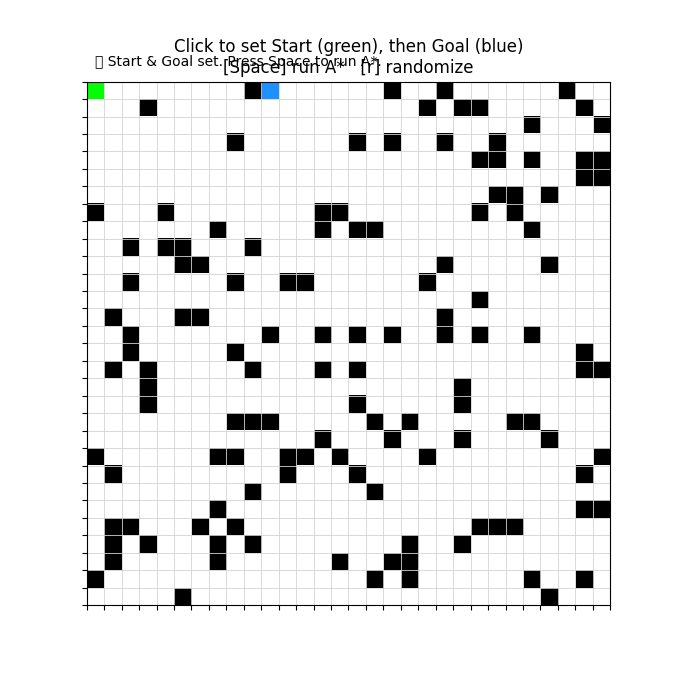

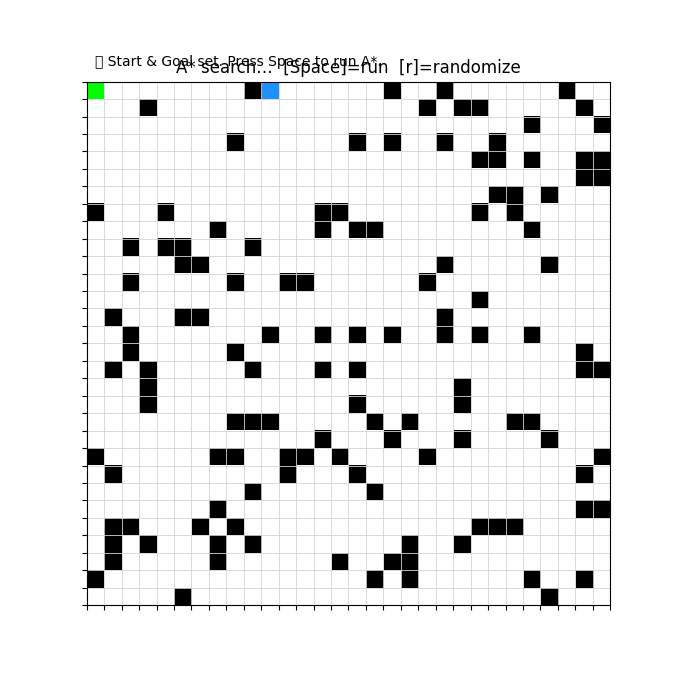

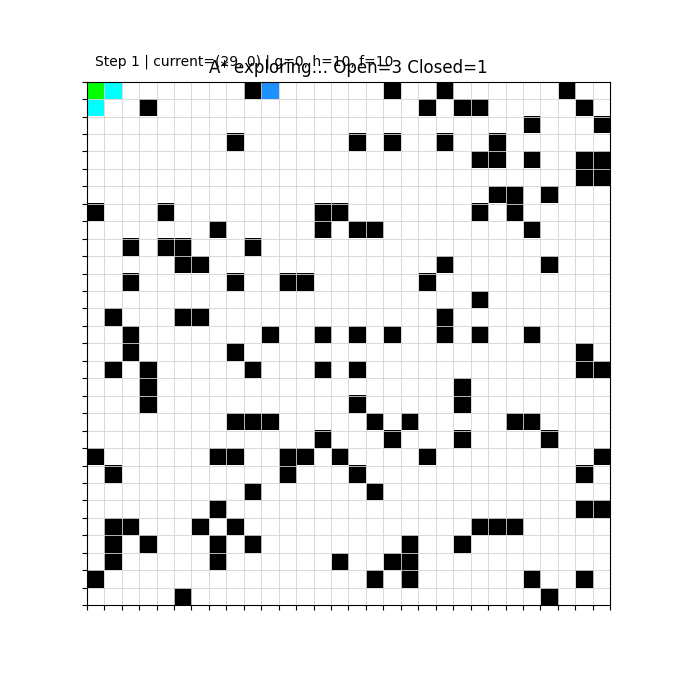

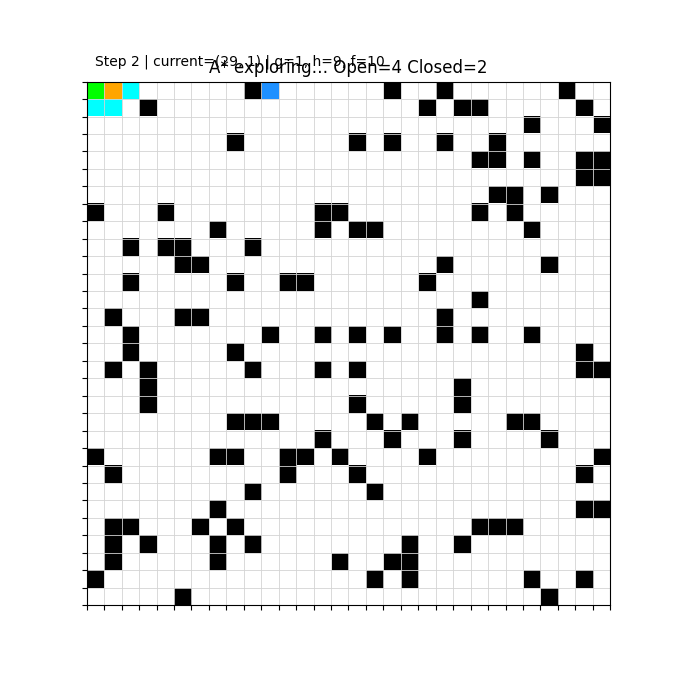

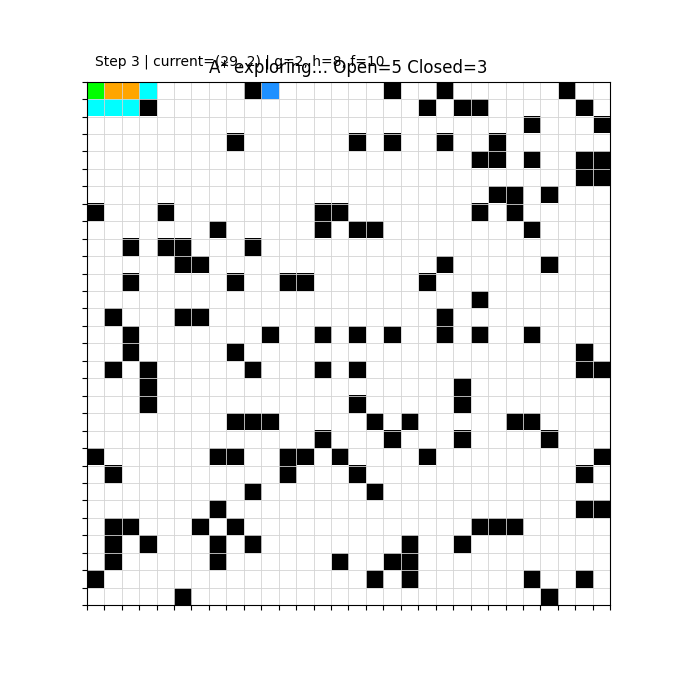

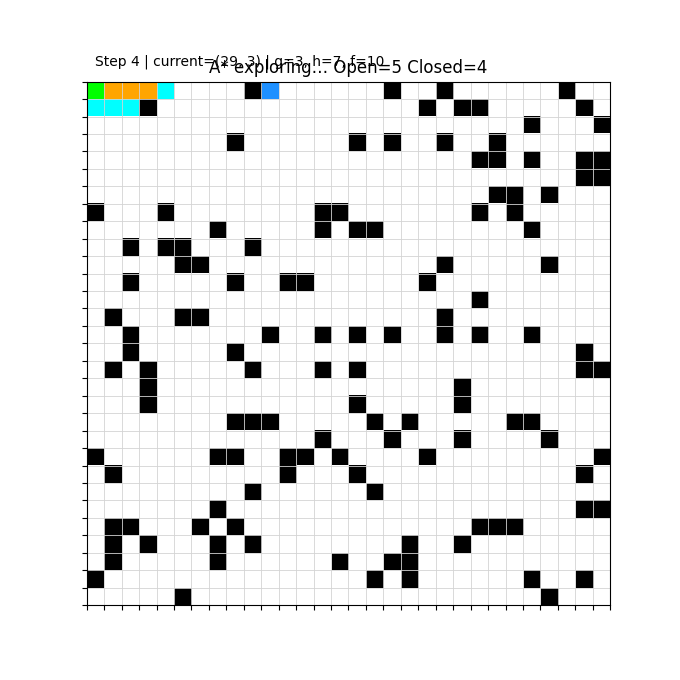

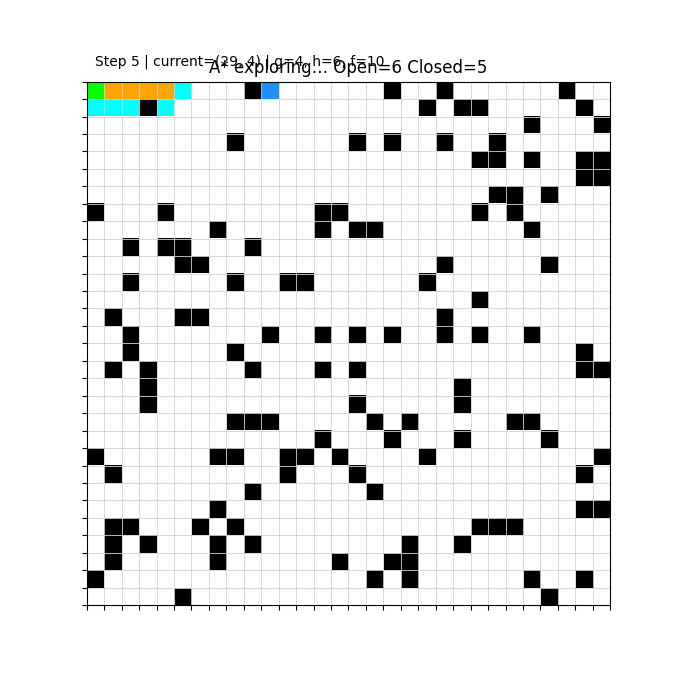

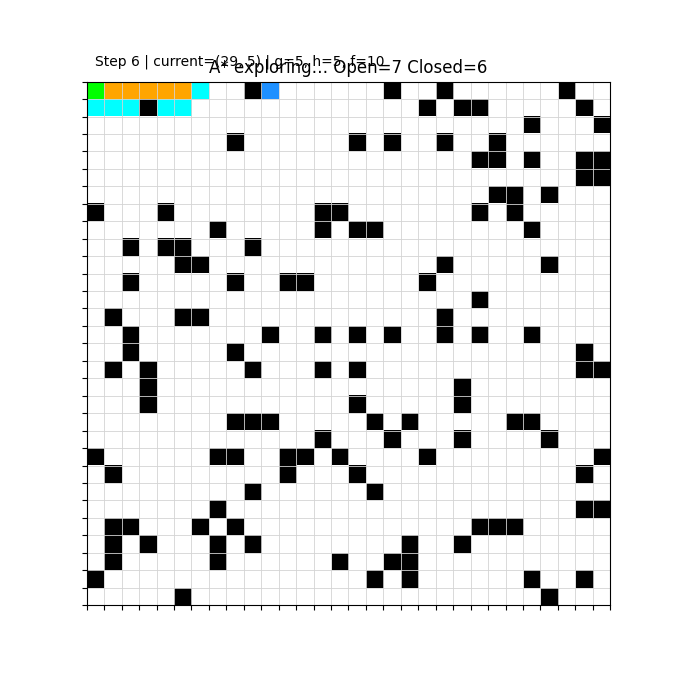

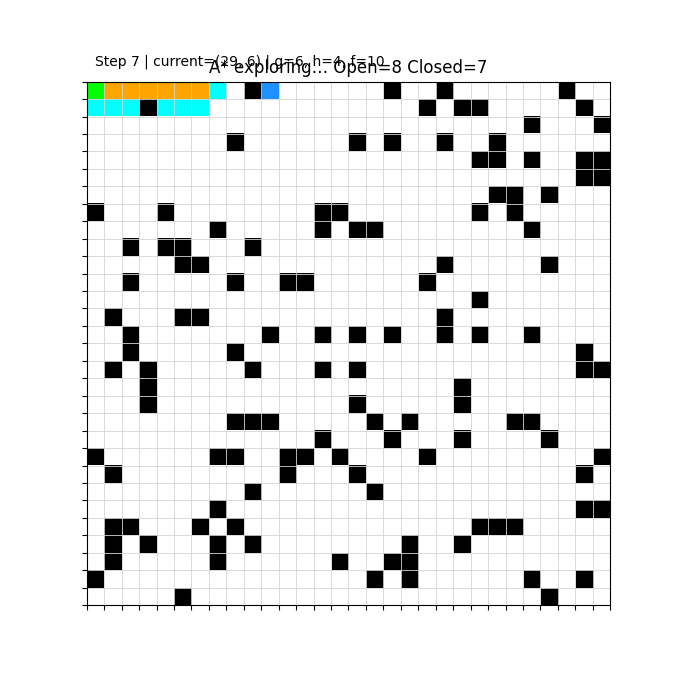

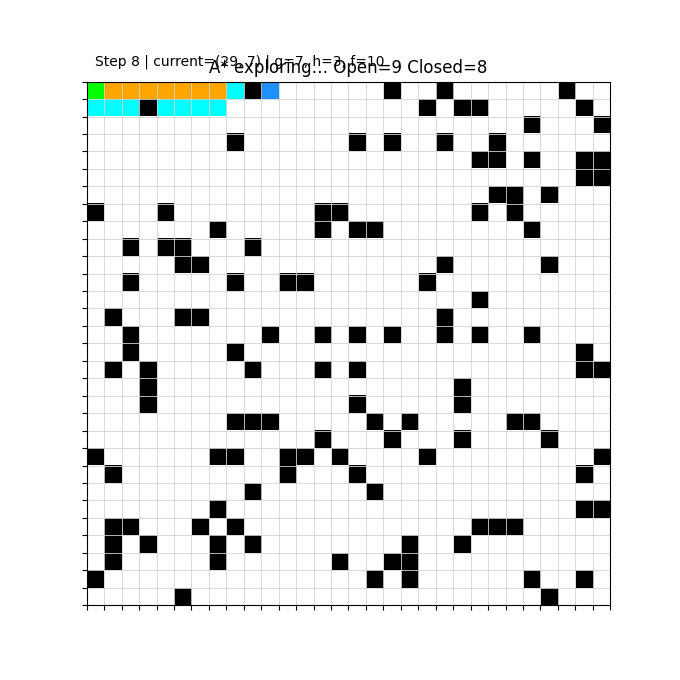

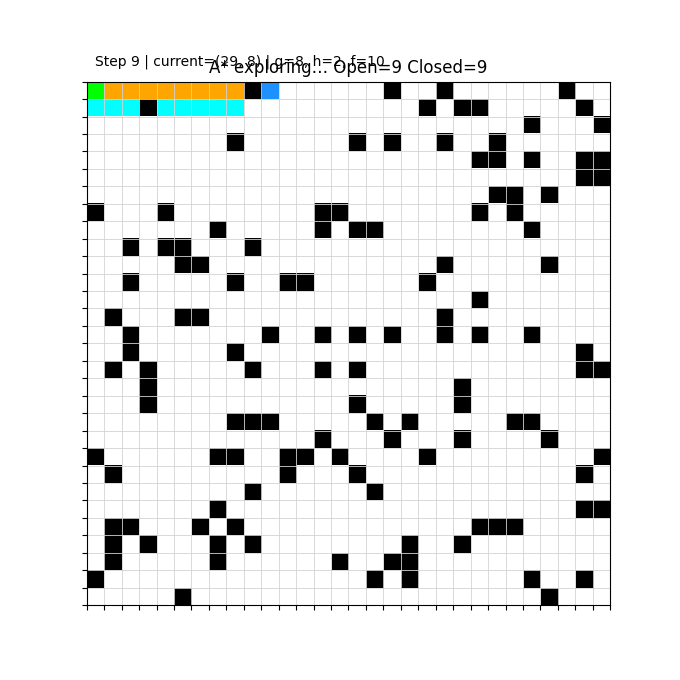

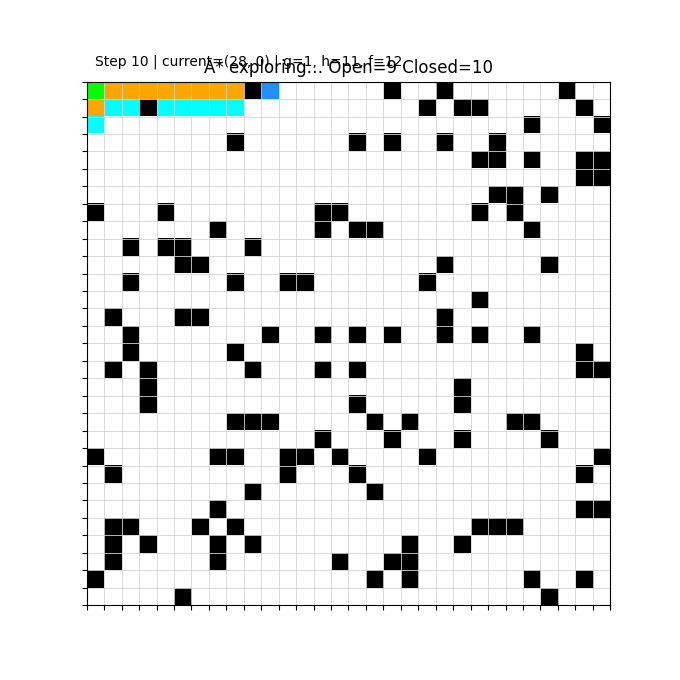

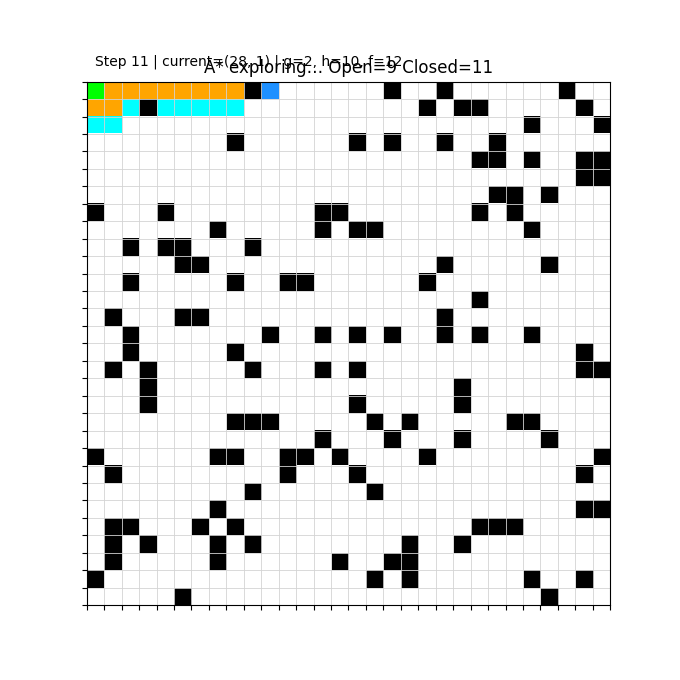

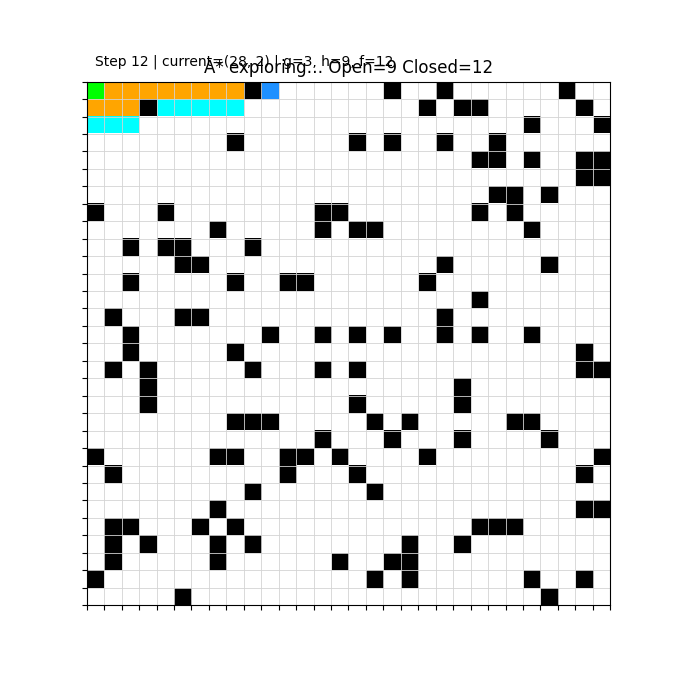

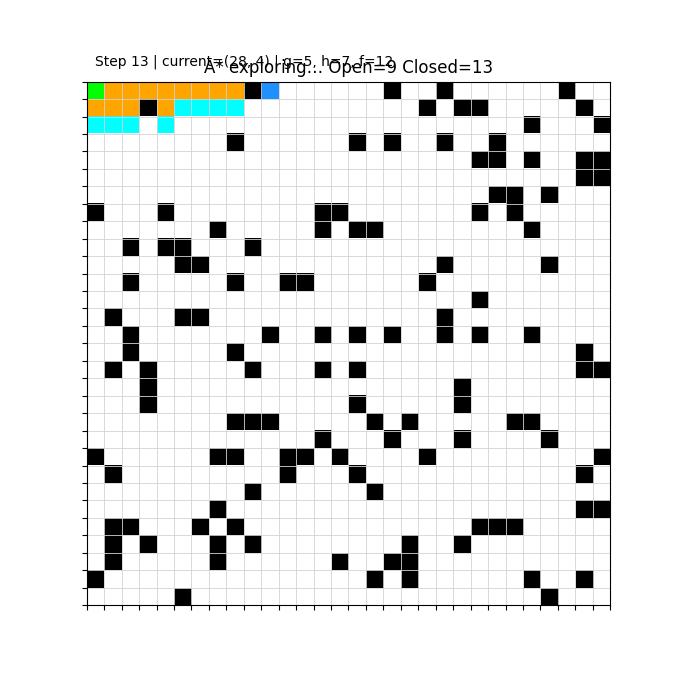

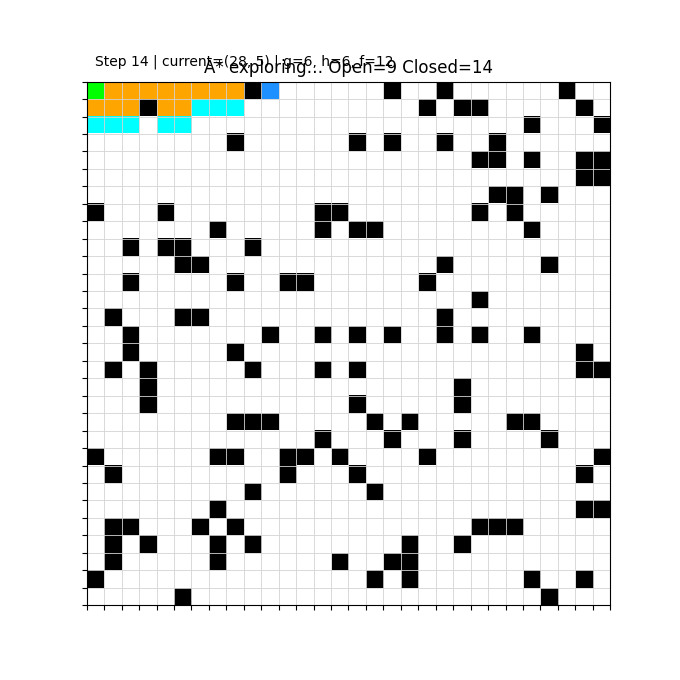

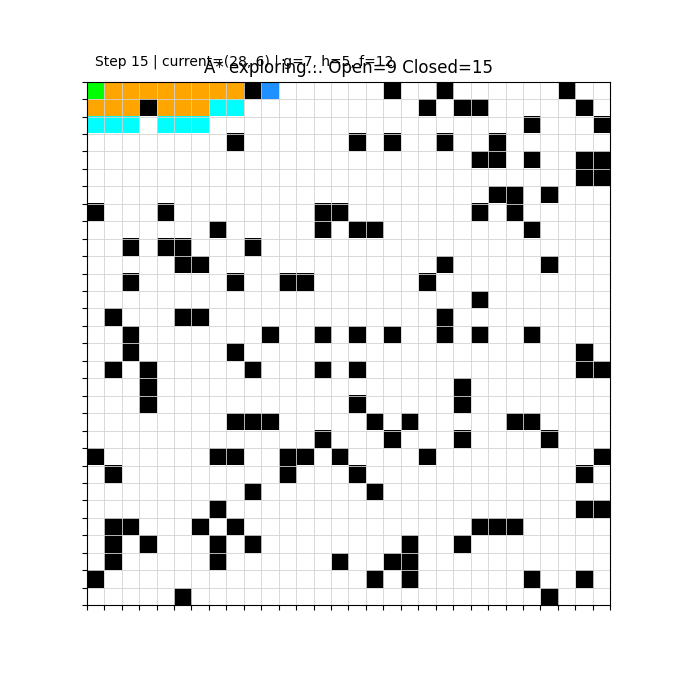

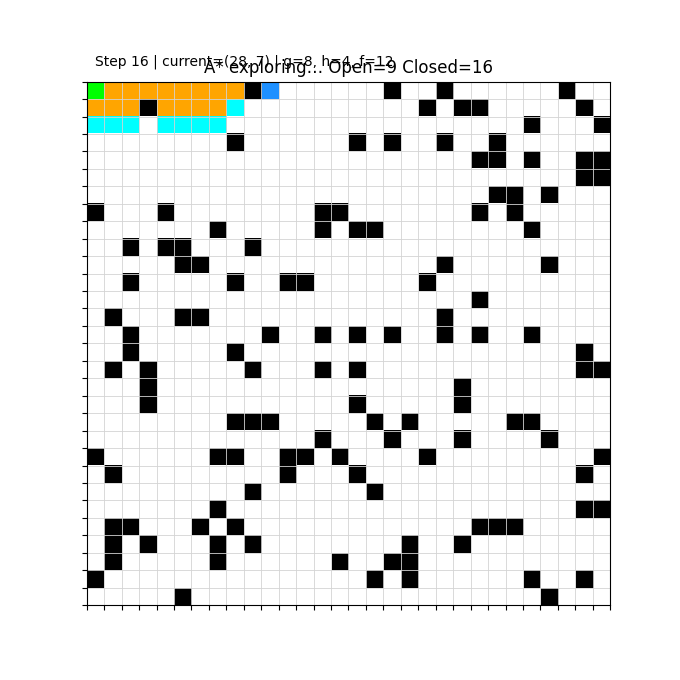

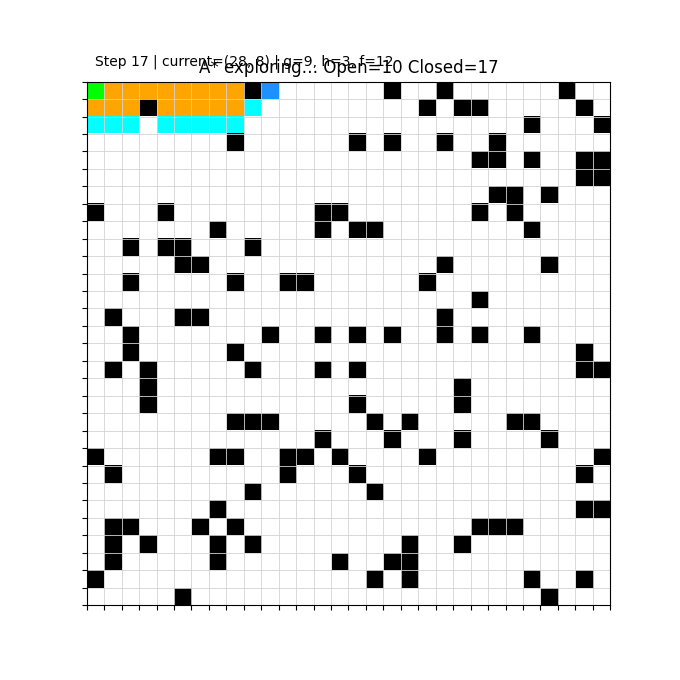

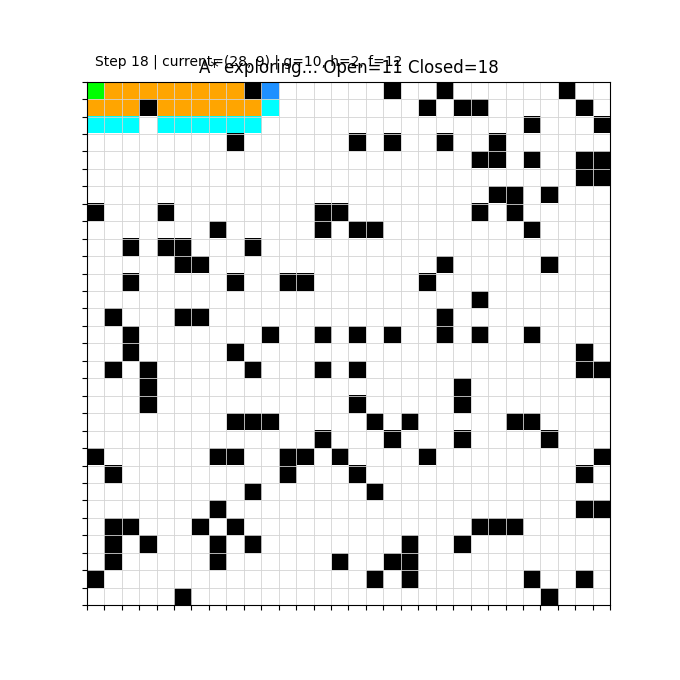

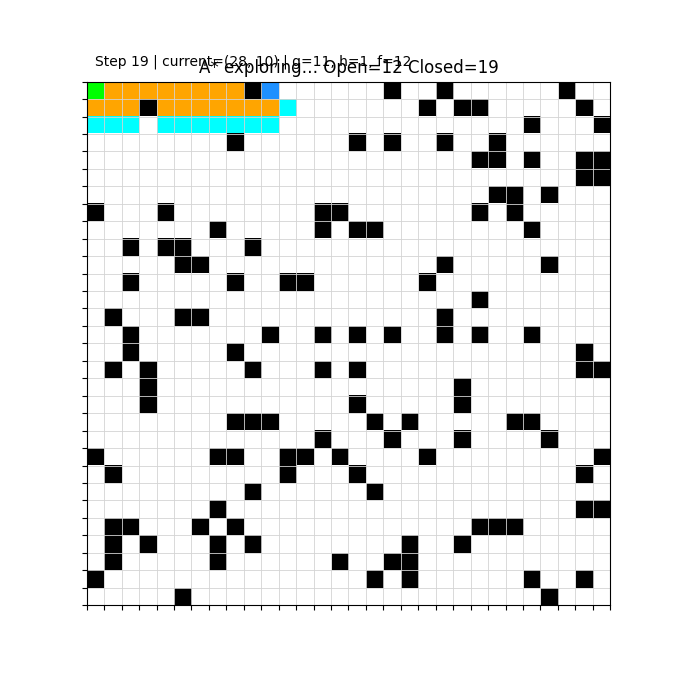

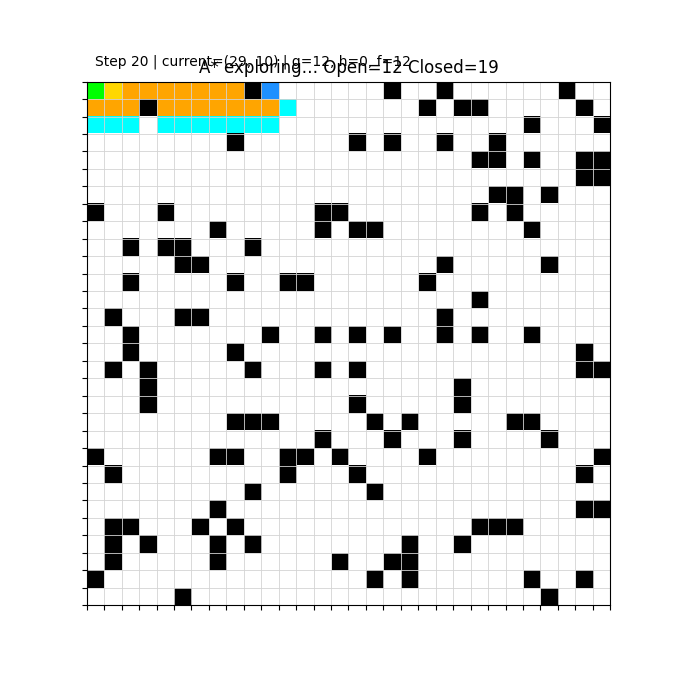

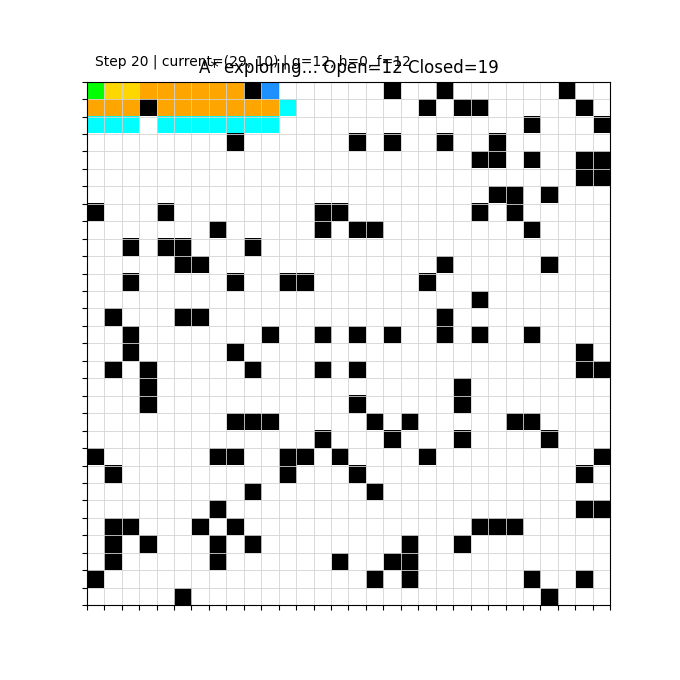

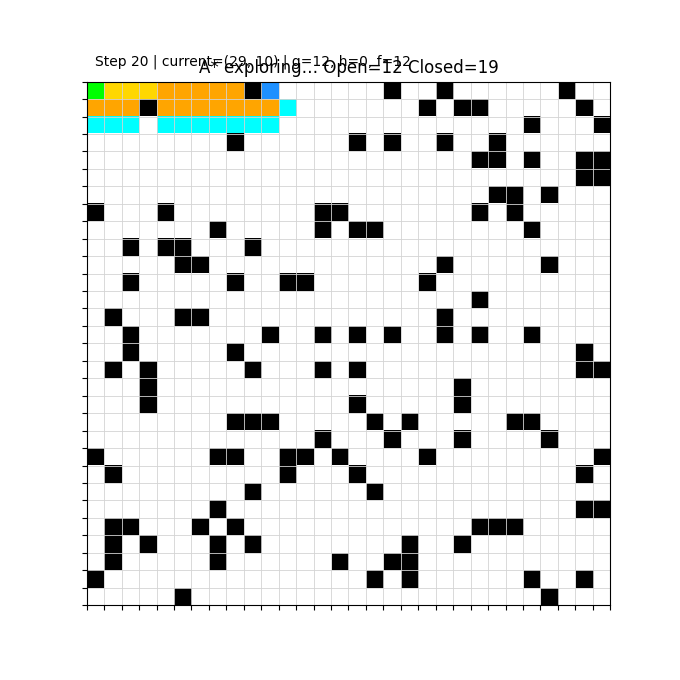

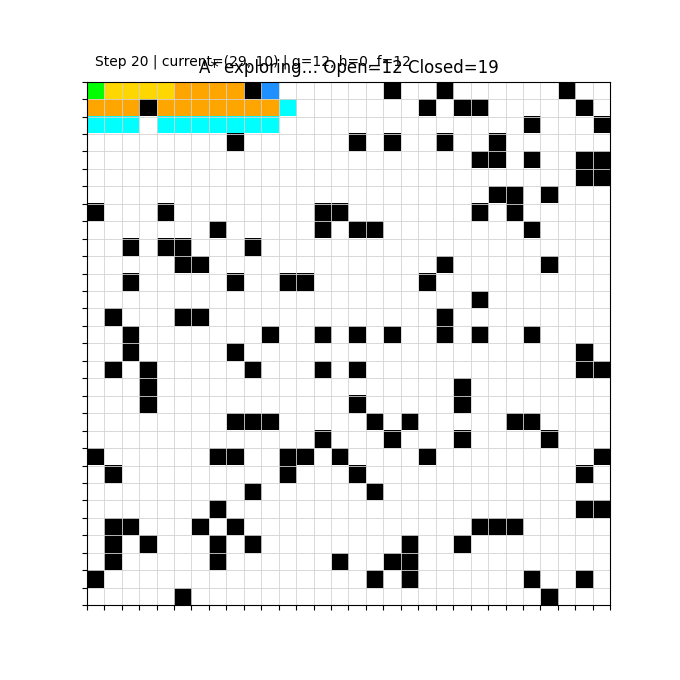

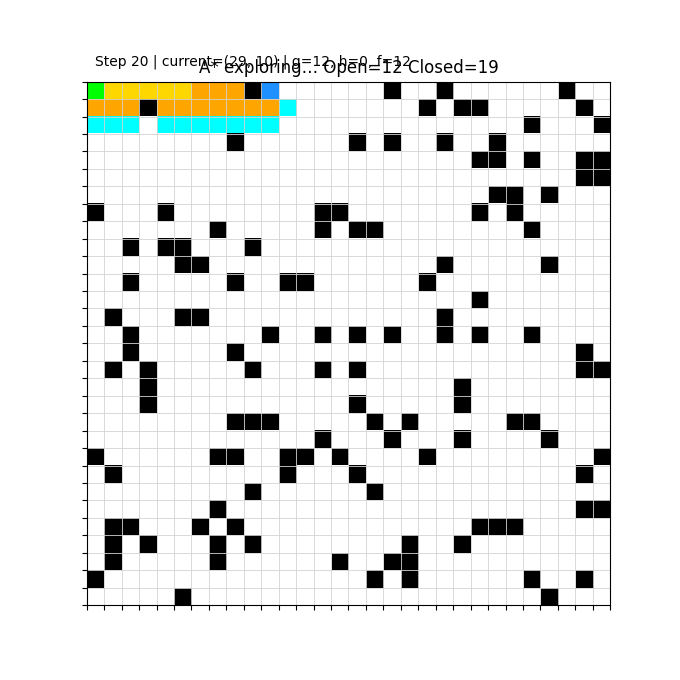

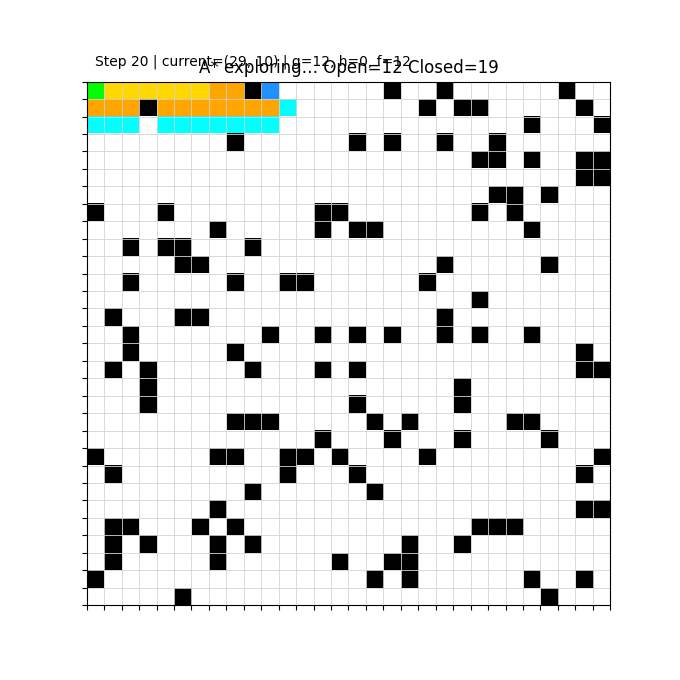

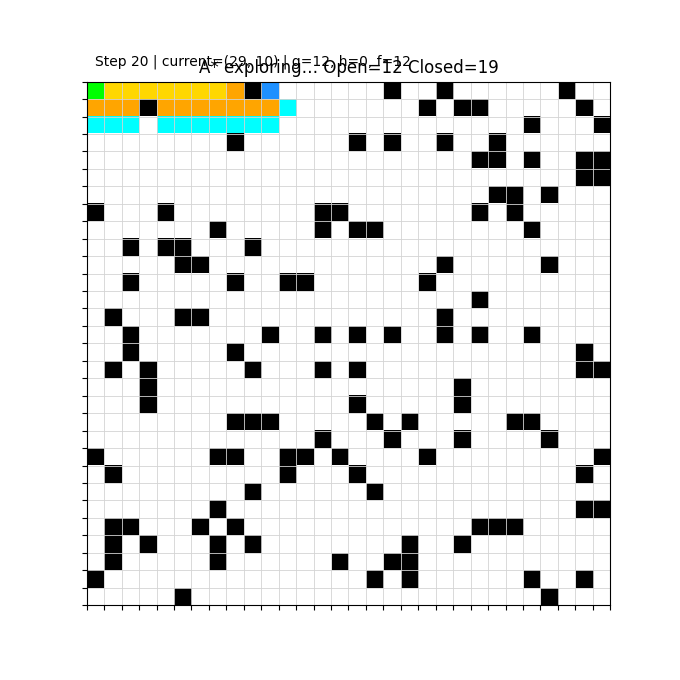

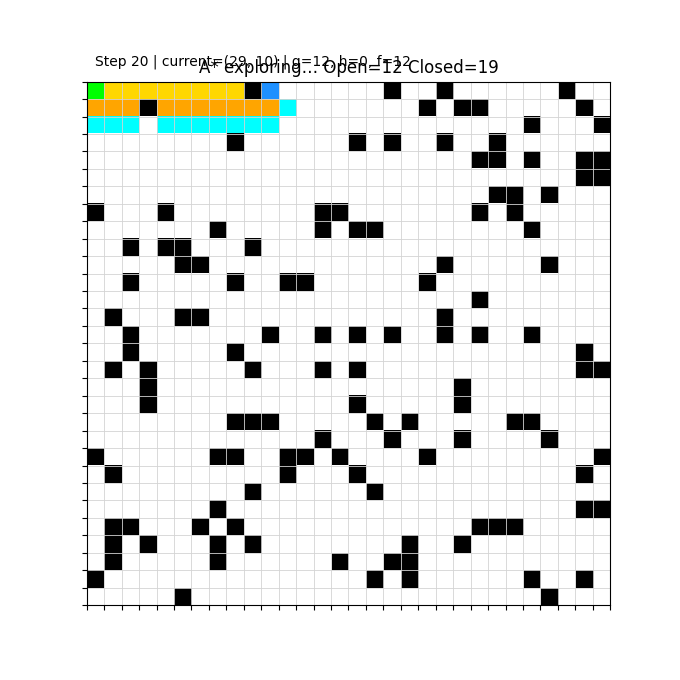

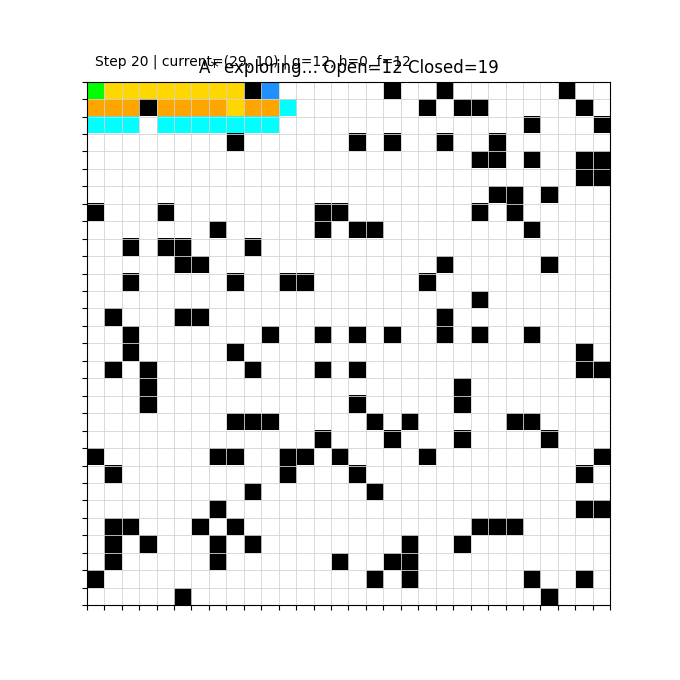

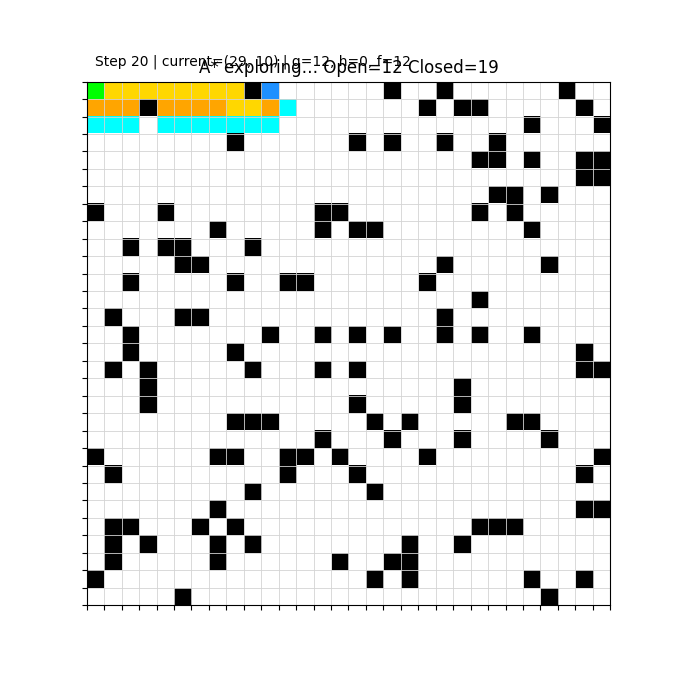

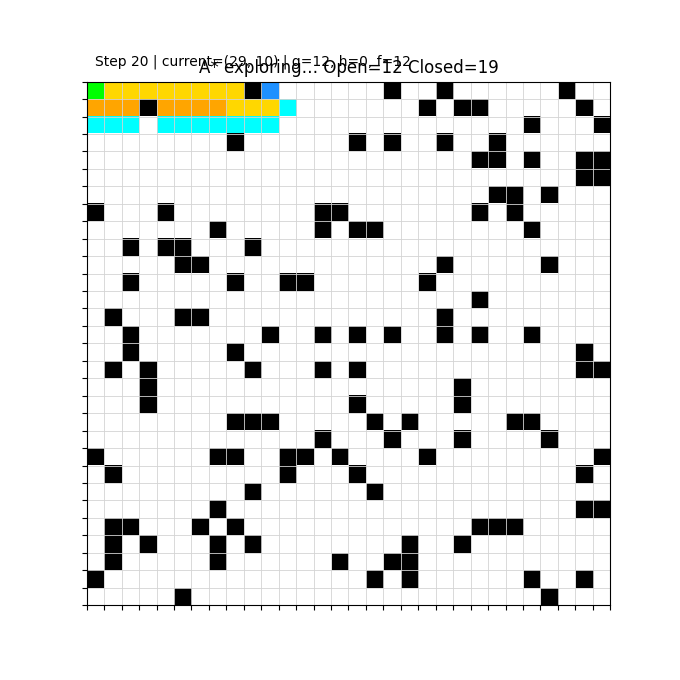

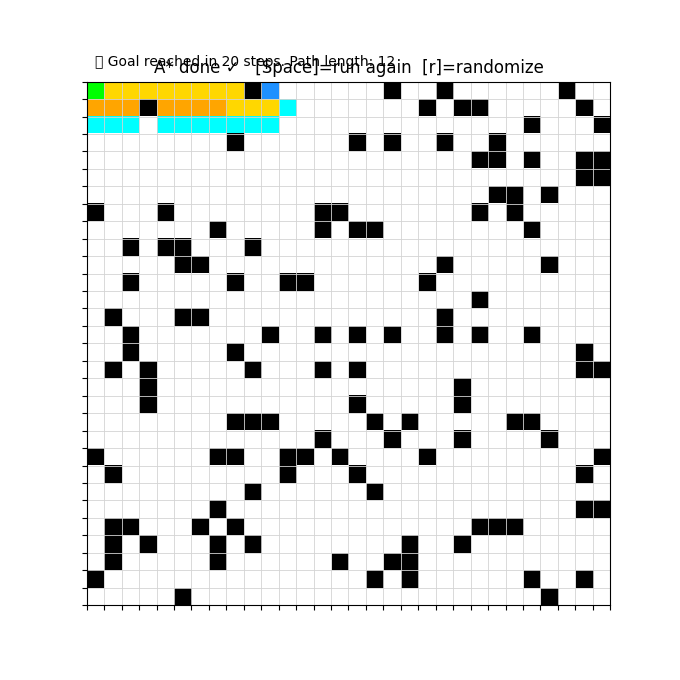

In [11]:
# (Run %matplotlib widget in a separate cell once)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import heapq
import math

# Cell values
FREE, OBST, START, GOAL, OPEN, CLOSED, PATH = 0, 1, 2, 3, 4, 5, 6

def interactive_grid(n=50, obstacle_prob=0.25, seed=None, step_delay=0.01):
    rng = np.random.default_rng(seed)
    grid = (rng.random((n, n)) < obstacle_prob).astype(np.uint8)

    # Distinct colors for each state
    cmap = ListedColormap([
        "white",        # 0 FREE
        "black",        # 1 OBST
        "lime",         # 2 START
        "dodgerblue",   # 3 GOAL
        "cyan",         # 4 OPEN set
        "orange",       # 5 CLOSED set
        "gold"          # 6 PATH
    ])

    fig, ax = plt.subplots(figsize=(6.8, 6.8))
    im = ax.imshow(
        grid, cmap=cmap, origin="lower", interpolation="none",
        extent=(-0.5, n-0.5, -0.5, n-0.5), vmin=0, vmax=6
    )
    ax.set_xticks(np.arange(-0.5, n, 1)); ax.set_yticks(np.arange(-0.5, n, 1))
    ax.grid(color="lightgray", linewidth=0.6)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_title("Click to set Start (green), then Goal (blue)\n[Space] run A*   [r] randomize", fontsize=12)

    status = ax.text(0, n+0.2, "Waiting for Start…", fontsize=10, va="bottom")
    state = {"stage": "start", "start": None, "goal": None, "busy": False}

    def to_index(xf, yf):
        if xf is None or yf is None: return None
        c = int(np.floor(xf + 0.5))
        r = int(np.floor(yf + 0.5))
        if 0 <= r < n and 0 <= c < n: return r, c
        return None

    def neighbors_4(r, c):
        for dr, dc in ((1,0),(-1,0),(0,1),(0,-1)):
            rr, cc = r+dr, c+dc
            if 0 <= rr < n and 0 <= cc < n:
                yield rr, cc

    def manhattan(a, b):
        return abs(a[0]-b[0]) + abs(a[1]-b[1])

    def clear_layers():
        # remove OPEN/CLOSED/PATH marks but keep obstacles/start/goal
        mask = (grid == OPEN) | (grid == CLOSED) | (grid == PATH)
        grid[mask] = FREE

    def draw(update_title=None):
        if update_title:
            ax.set_title(update_title, fontsize=12)
        im.set_data(grid)
        fig.canvas.draw_idle()
        plt.pause(step_delay)

    def reconstruct_path(came_from, current):
        route = []
        while current in came_from:
            route.append(current)
            current = came_from[current]
        route.reverse()
        return route

    def run_astar():
        # Prevent re-entry
        if state["busy"]: 
            return
        state["busy"] = True

        # Basic checks
        if state["start"] is None or state["goal"] is None:
            status.set_text("⚠️ Set both Start and Goal first.")
            state["busy"] = False
            draw()
            return

        s = state["start"]; g = state["goal"]
        if grid[s] == OBST or grid[g] == OBST:
            status.set_text("⚠️ Start/Goal on an obstacle. Press 'r' to randomize.")
            state["busy"] = False
            draw()
            return

        clear_layers()
        draw("A* search…  [Space]=run  [r]=randomize")

        # A* state
        g_score = {s: 0}
        f0 = manhattan(s, g)
        open_heap = [(f0, 0, s)]
        came_from = {}
        closed = set()
        step = 0

        # For visualization, track which cells are in OPEN
        open_set = {s}

        while open_heap:
            f, gcur, cur = heapq.heappop(open_heap)
            if cur in closed:
                continue
            step += 1

            # Mark current as CLOSED (don't overwrite start/goal)
            if cur != s and cur != g:
                grid[cur] = CLOSED
                if cur in open_set:
                    open_set.remove(cur)

            # Status line with f=g+h breakdown
            hcur = manhattan(cur, g)
            status.set_text(f"Step {step} | current={cur} | g={gcur}, h={hcur}, f={f}")

            # Goal reached?
            if cur == g:
                path = reconstruct_path(came_from, cur)
                for r, c in path:
                    if (r, c) != s and (r, c) != g:
                        grid[r, c] = PATH
                        draw()
                status.set_text(f"✅ Goal reached in {step} steps. Path length: {len(path)}")
                state["busy"] = False
                draw("A* done ✓   [Space]=run again  [r]=randomize")
                return

            closed.add(cur)

            cr, cc = cur
            for nr, nc in neighbors_4(cr, cc):
                nxt = (nr, nc)
                if grid[nxt] == OBST or nxt in closed:
                    continue

                tentative = gcur + 1  # uniform cost for 4-neighbor grid
                if nxt not in g_score or tentative < g_score[nxt]:
                    g_score[nxt] = tentative
                    came_from[nxt] = cur
                    fscore = tentative + manhattan(nxt, g)
                    heapq.heappush(open_heap, (fscore, tentative, nxt))
                    if nxt != s and nxt != g:
                        grid[nxt] = OPEN  # mark as discovered
                        open_set.add(nxt)

            draw(f"A* exploring… Open={len(open_set)} Closed={len(closed)}")

        # If we get here, no path
        status.set_text("❌ No path. Try a different map (press 'r') or lower obstacle_prob.")
        state["busy"] = False
        draw("A* finished (no path)")

    # ---------- interaction ----------
    def on_click(event):
        if state["busy"]:
            return  # ignore clicks during search
        idx = to_index(event.xdata, event.ydata)
        if event.inaxes != ax or idx is None:
            return
        r, c = idx
        if grid[r, c] == OBST:
            status.set_text("⚠️ That cell is an obstacle. Click a white cell.")
            draw(); return

        if state["stage"] == "start":
            grid[grid == START] = FREE
            grid[r, c] = START
            state["start"] = (r, c)
            state["stage"] = "goal"
            clear_layers()
            status.set_text("✅ Start set. Now click the Goal (blue).")
        elif state["stage"] == "goal":
            grid[grid == GOAL] = FREE
            grid[r, c] = GOAL
            state["goal"] = (r, c)
            state["stage"] = "done"
            clear_layers()
            status.set_text("✅ Start & Goal set. Press Space to run A*.")
        draw()

    def on_key(event):
        k = (event.key or "").lower()
        if k == "r" and not state["busy"]:
            # re-randomize obstacles and clear layers
            grid[:, :] = (rng.random((n, n)) < obstacle_prob).astype(np.uint8)
            grid[grid == START] = FREE
            grid[grid == GOAL]  = FREE
            clear_layers()
            state.update({"stage": "start", "start": None, "goal": None})
            status.set_text("Map randomized. Click Start (green).")
            draw("Click to set Start (green), then Goal (blue)\n[Space] run A*   [r] randomize")
        elif k == " " and state["stage"] == "done":
            run_astar()

    fig.canvas.mpl_connect("button_press_event", on_click)
    fig.canvas.mpl_connect("key_press_event", on_key)
    plt.show()
    return grid

# ---- Run it (50x50, ~25% obstacles) ----
map_sz = 30
obs_prob = 0.15
seed = None
grid = interactive_grid(n=map_sz, obstacle_prob=obs_prob, seed=seed, step_delay=0.01)


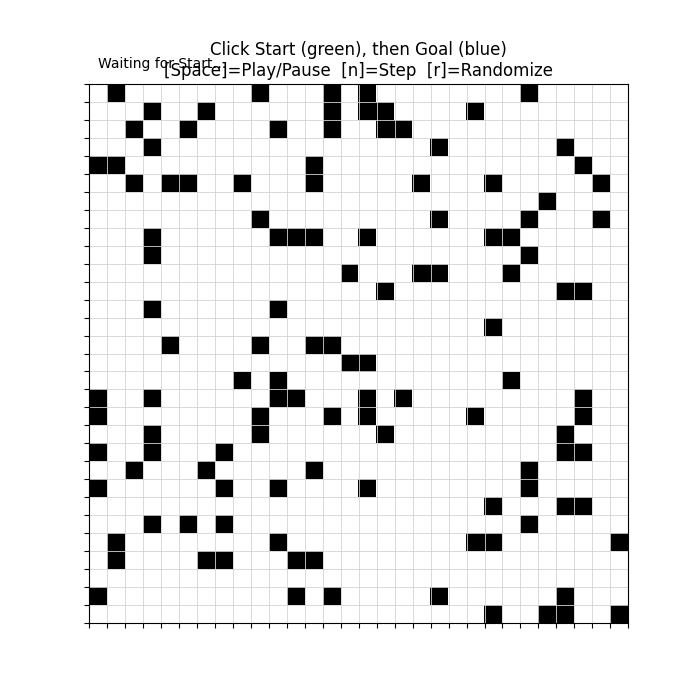

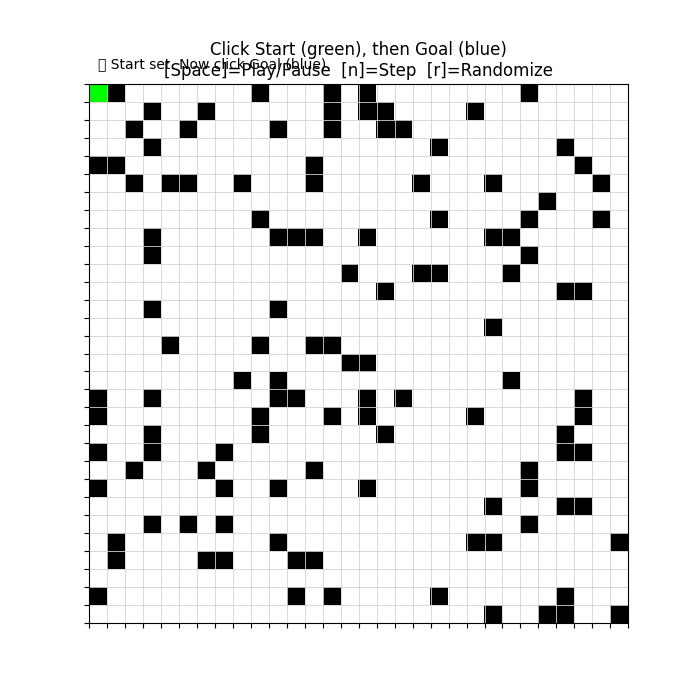

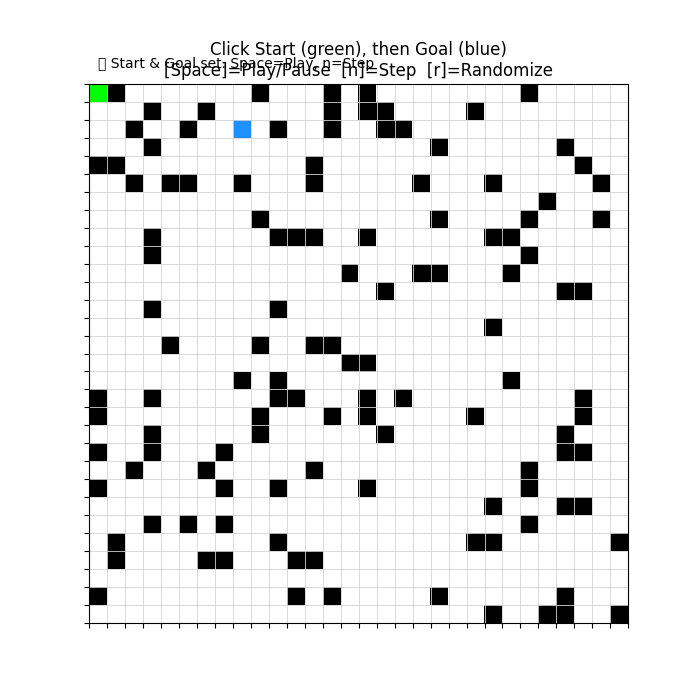

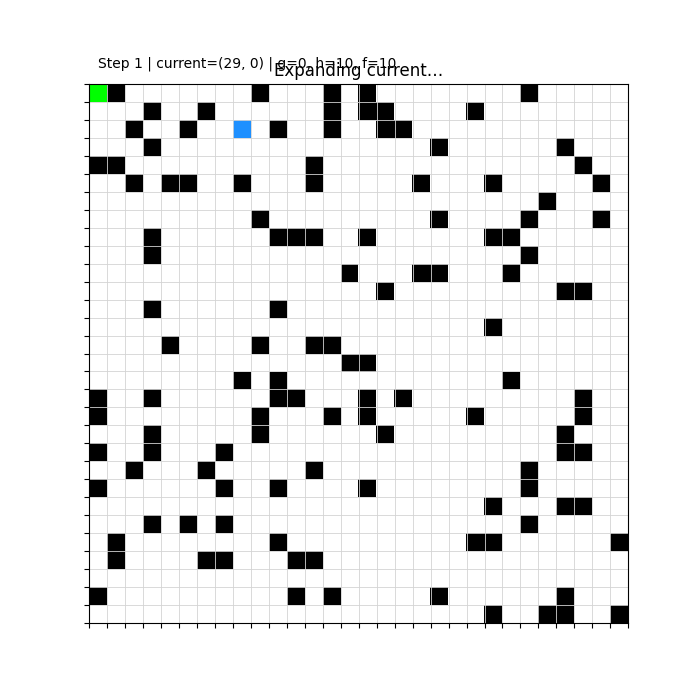

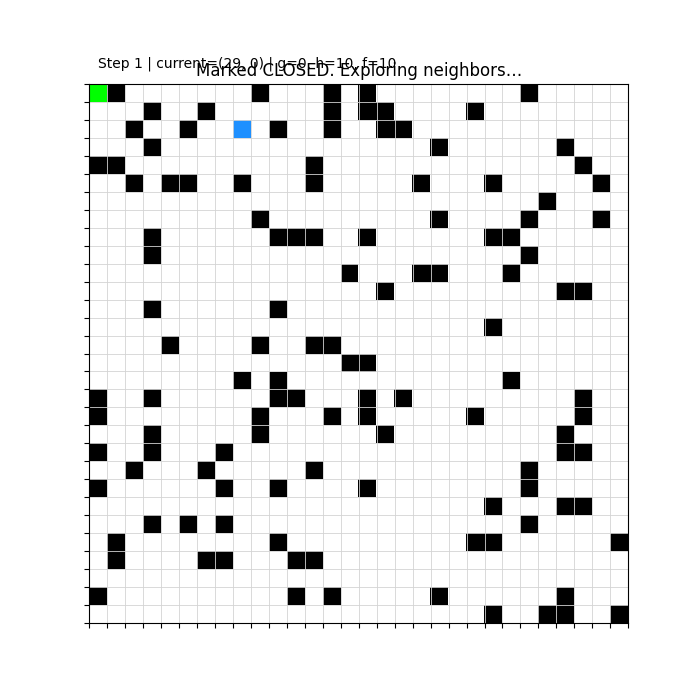

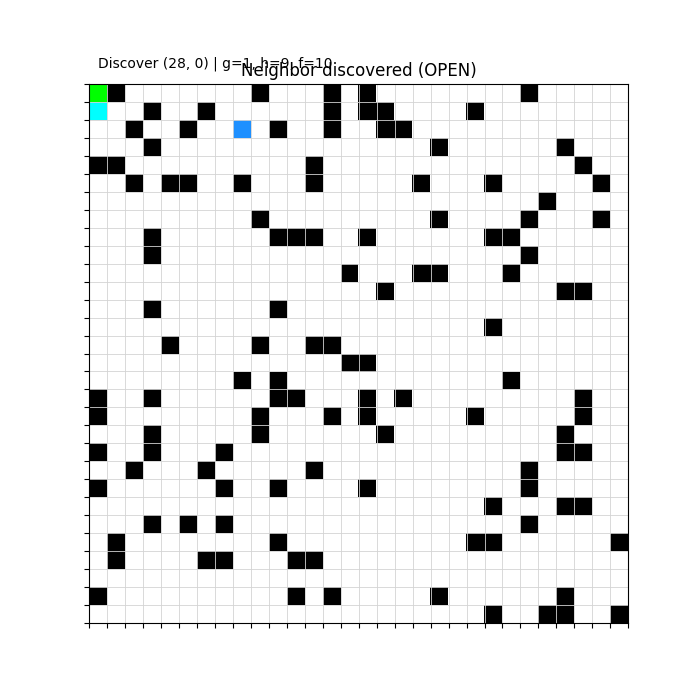

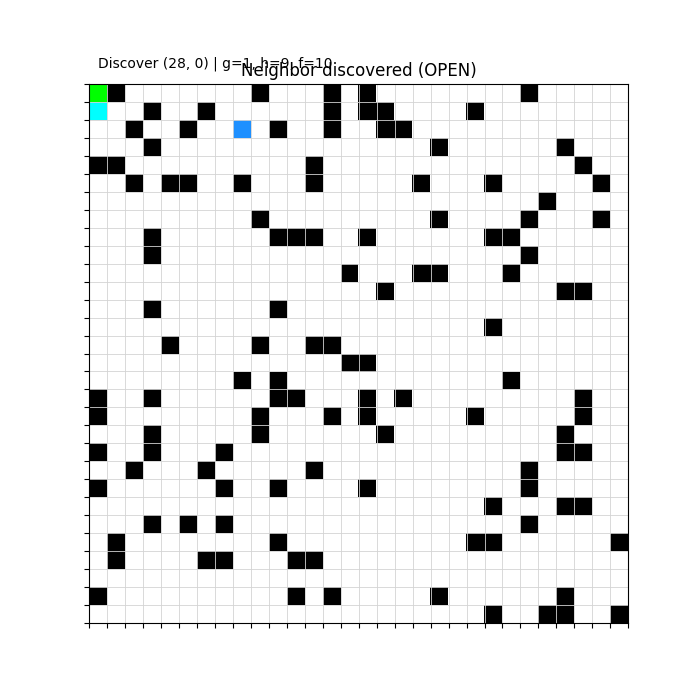

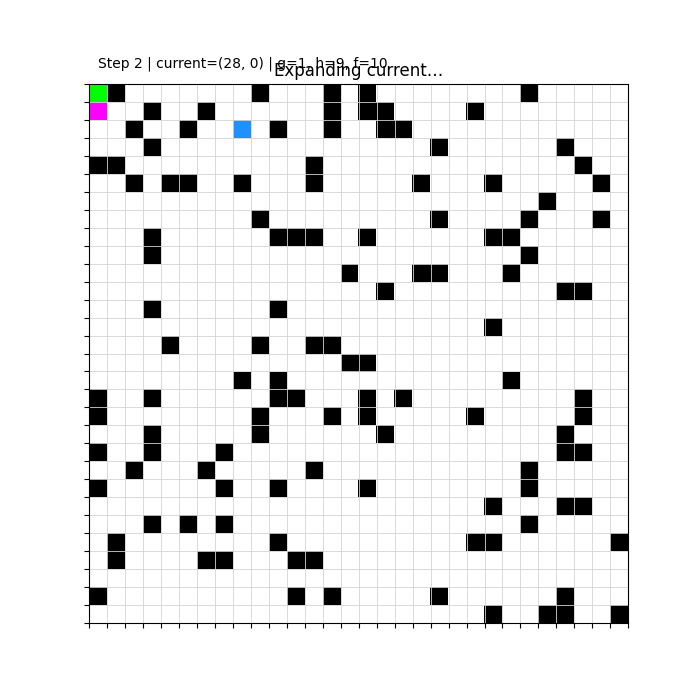

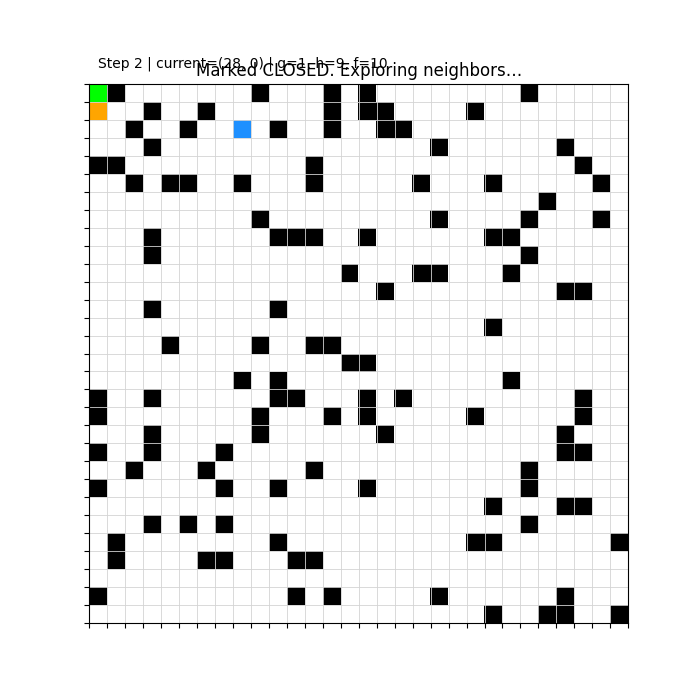

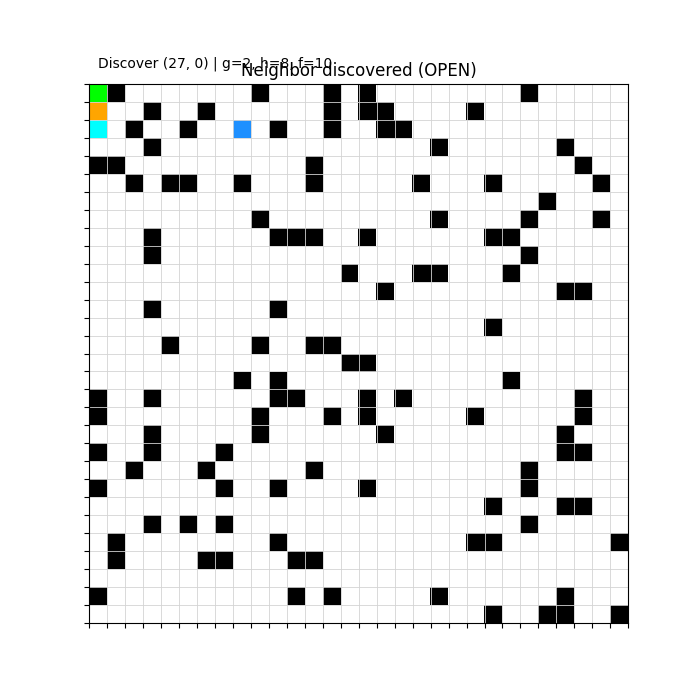

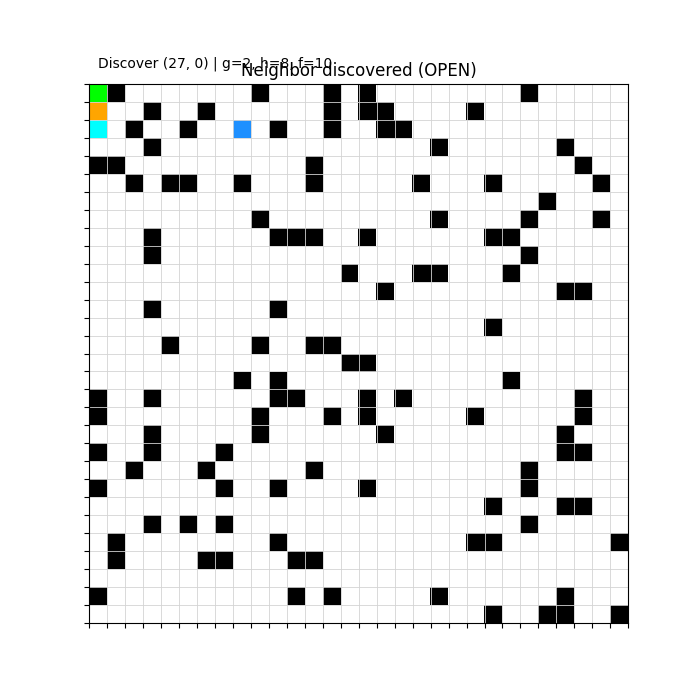

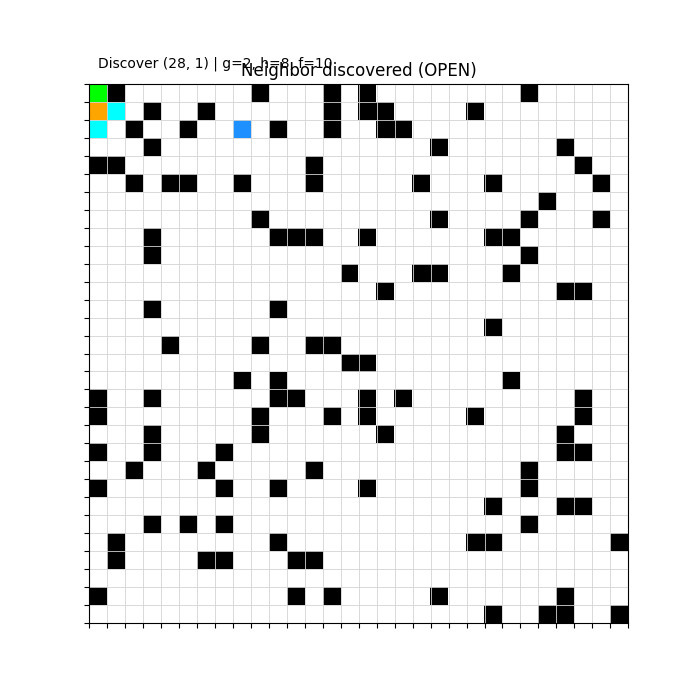

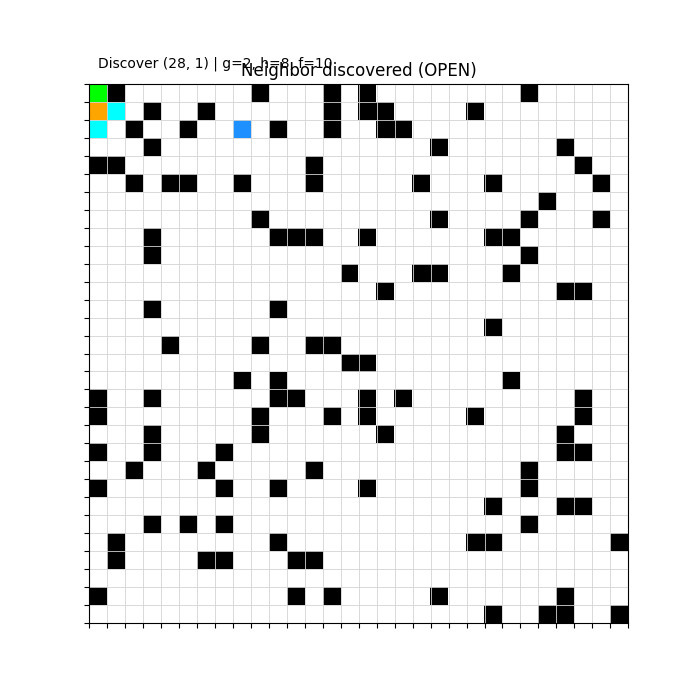

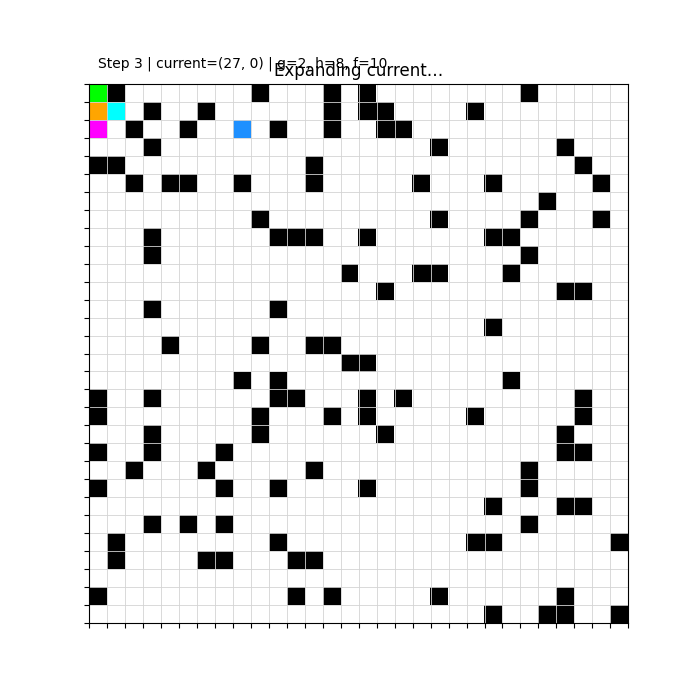

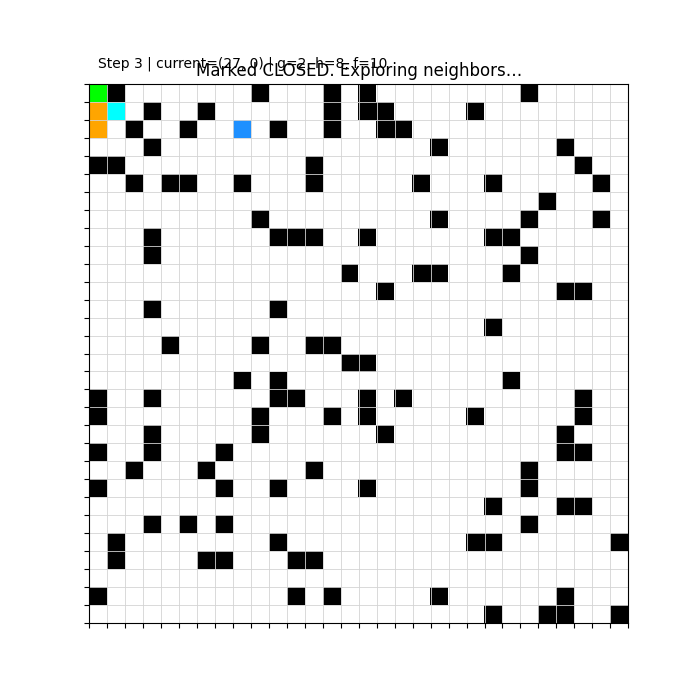

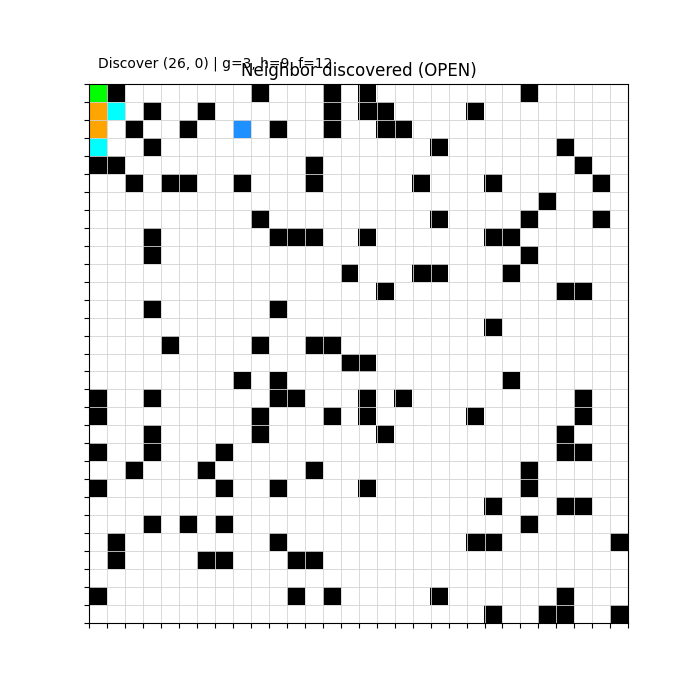

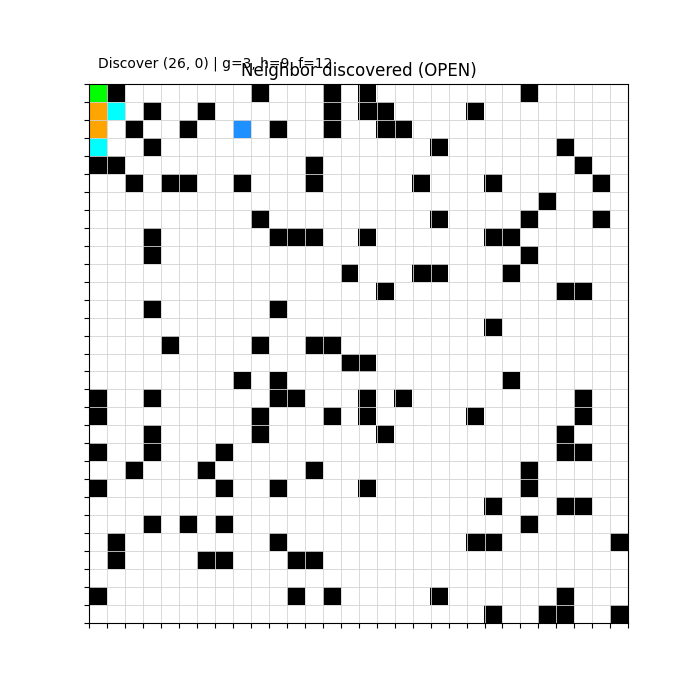

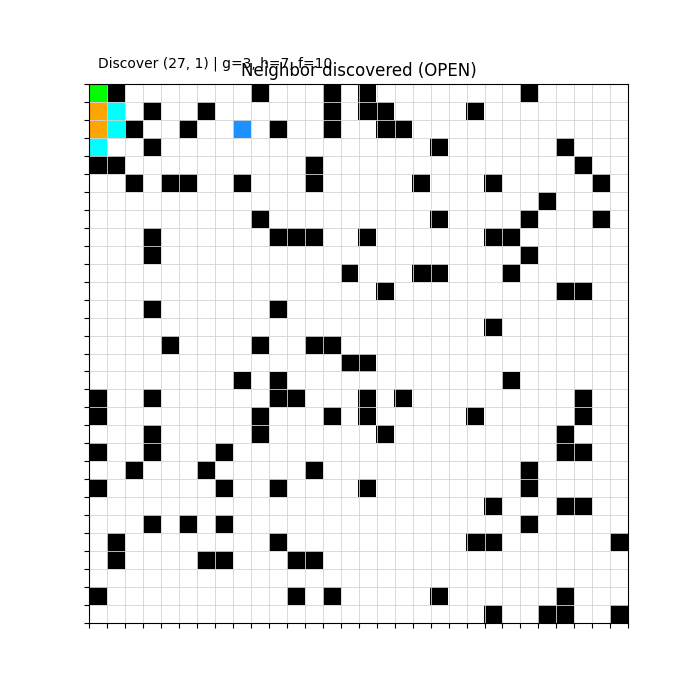

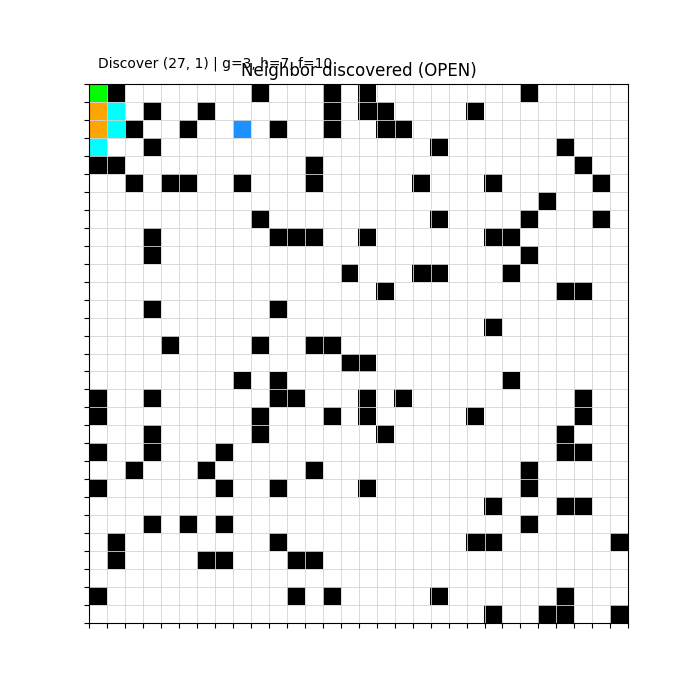

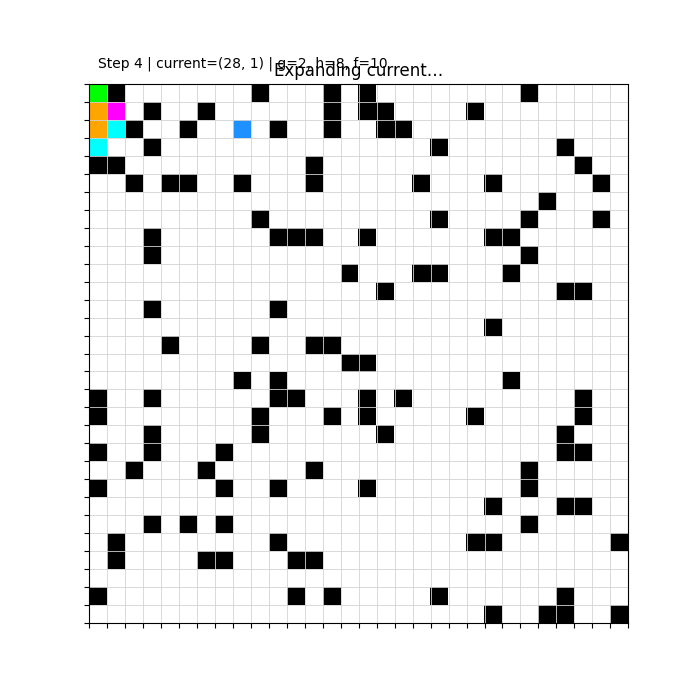

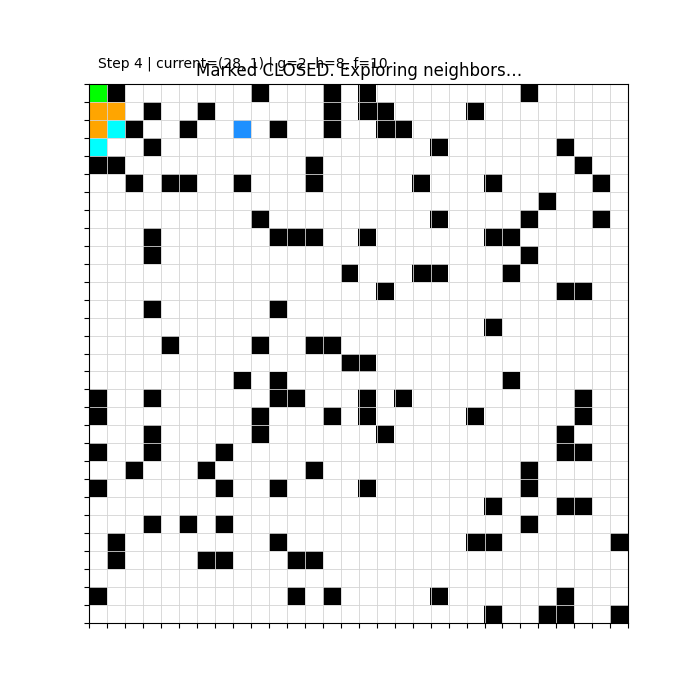

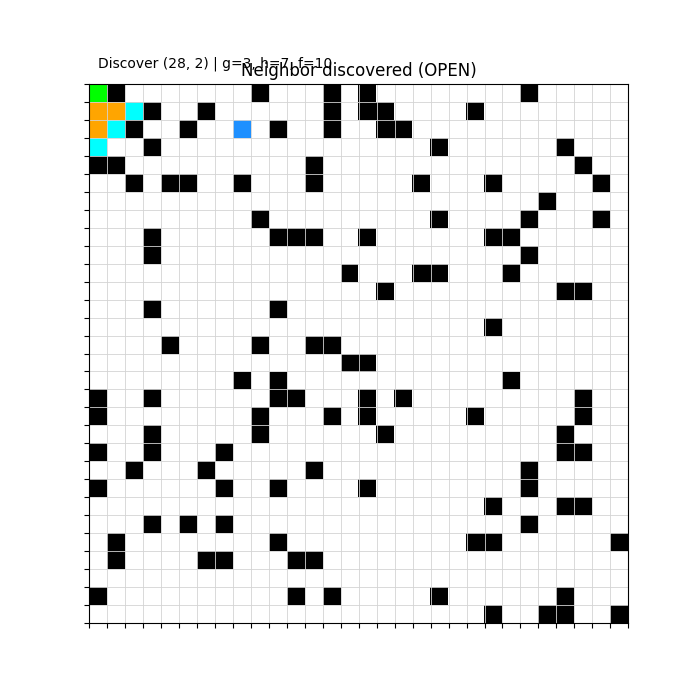

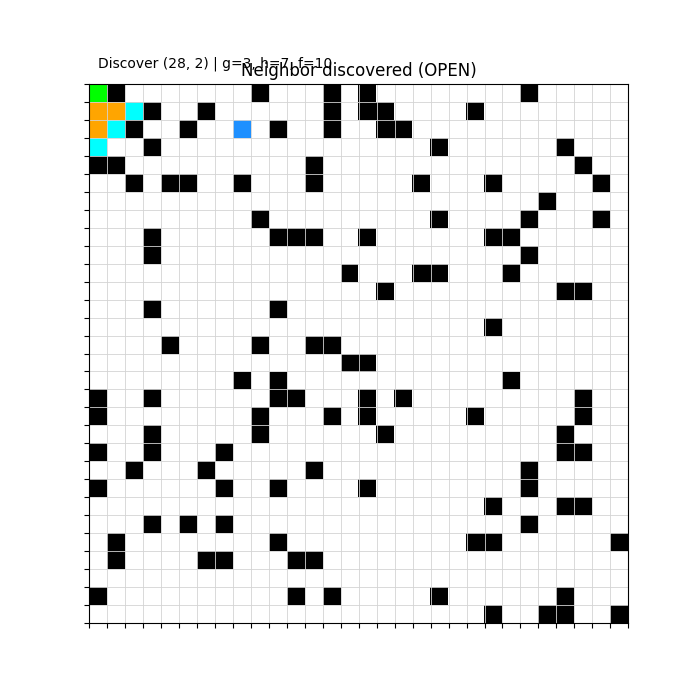

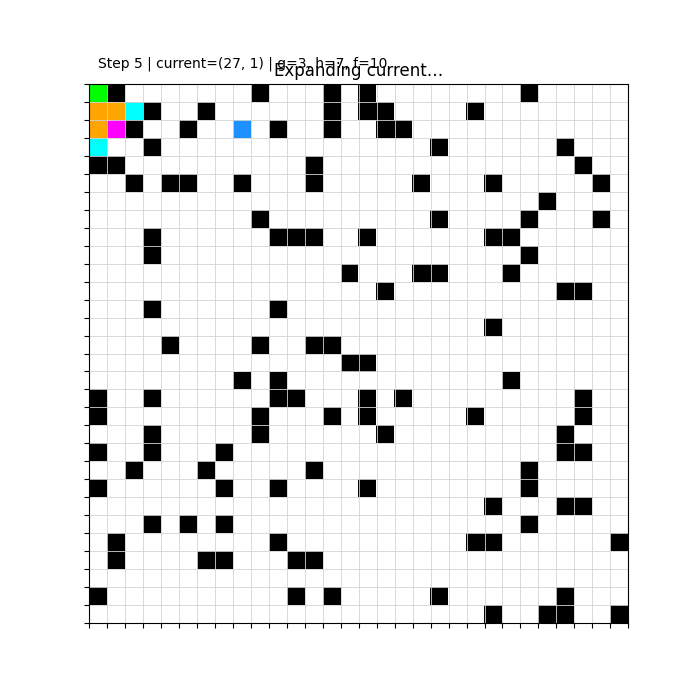

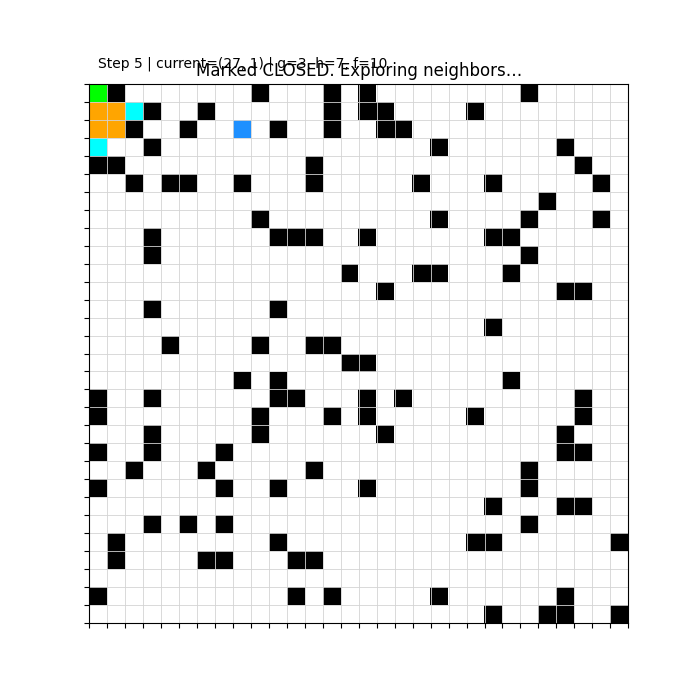

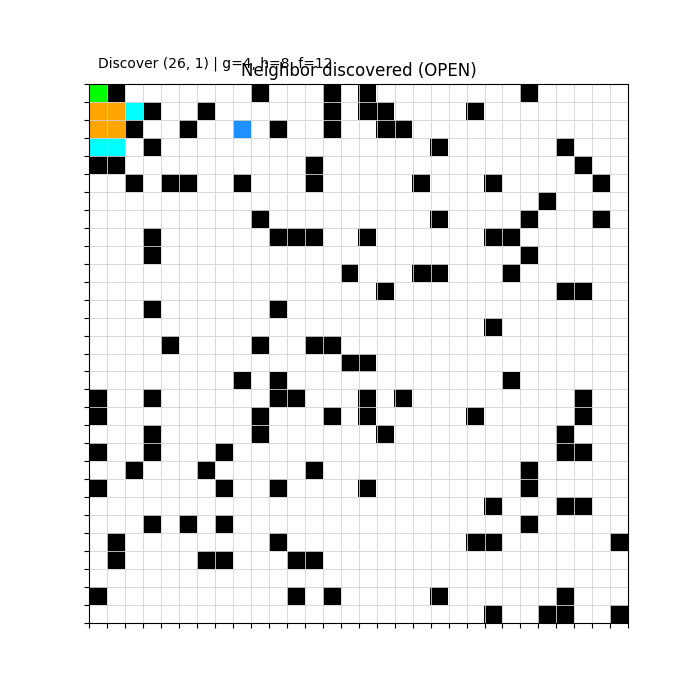

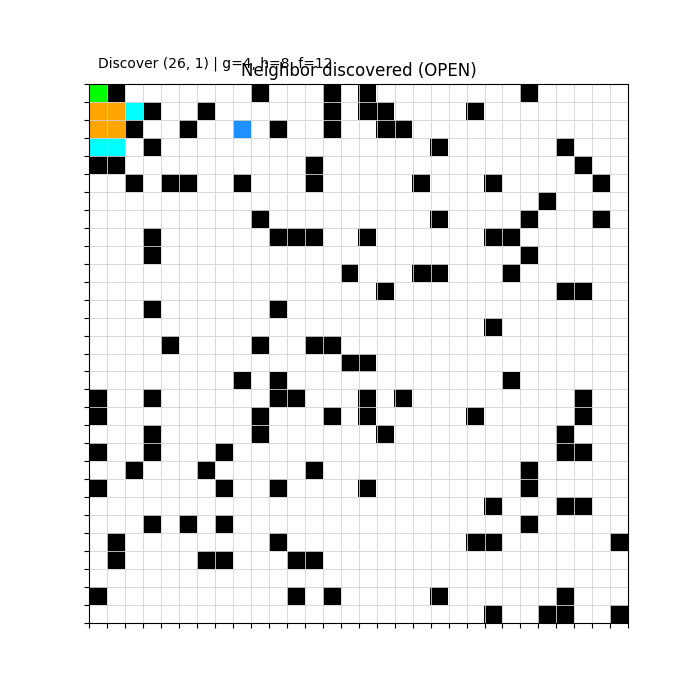

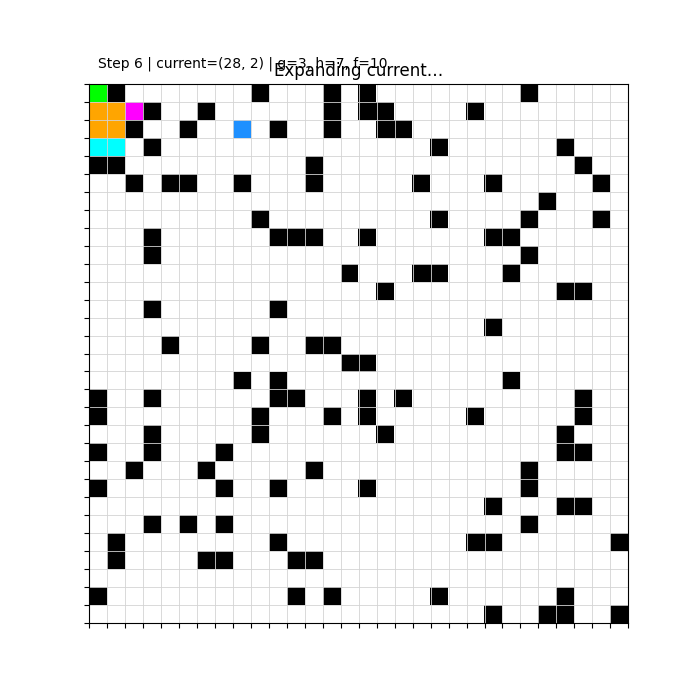

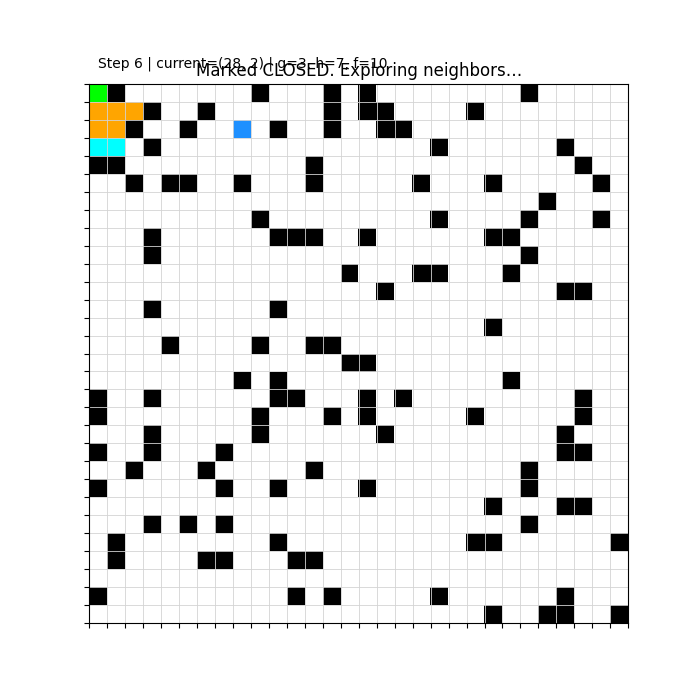

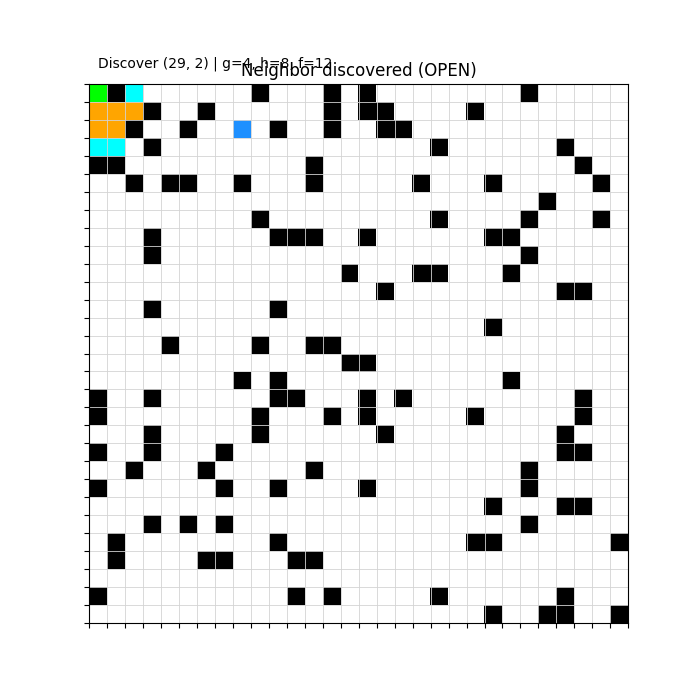

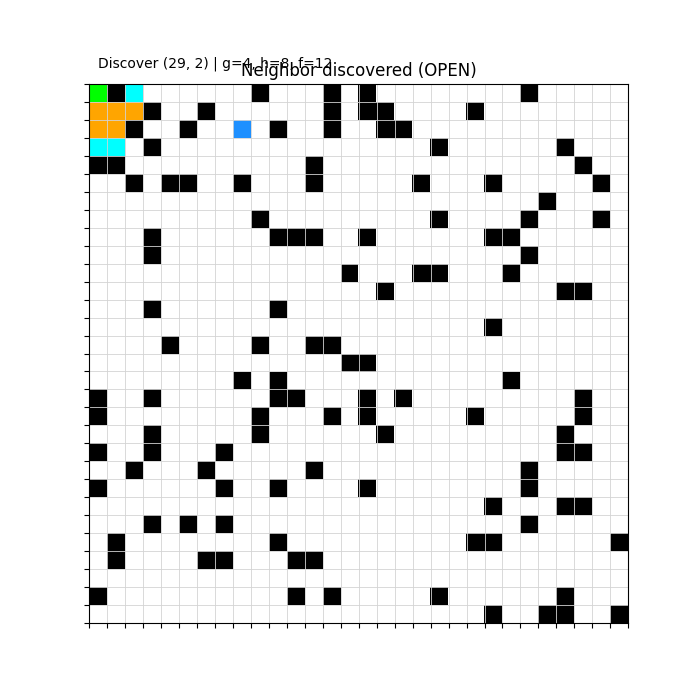

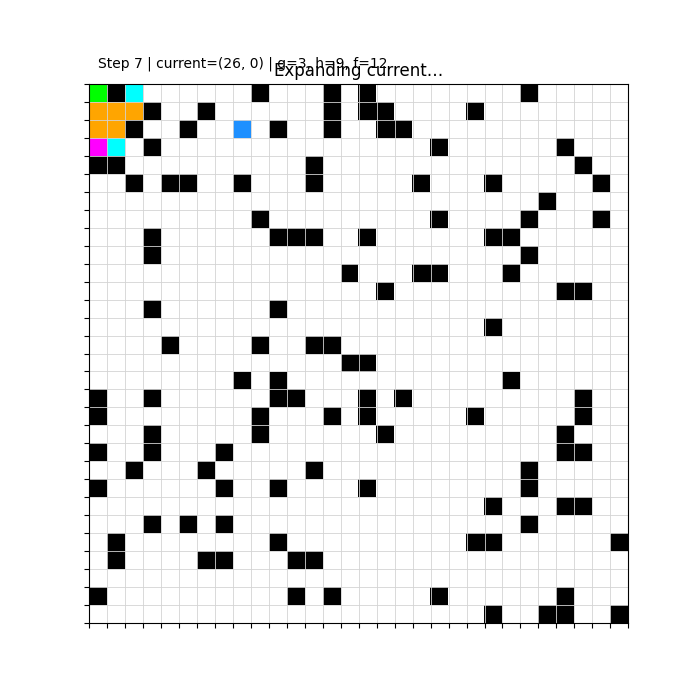

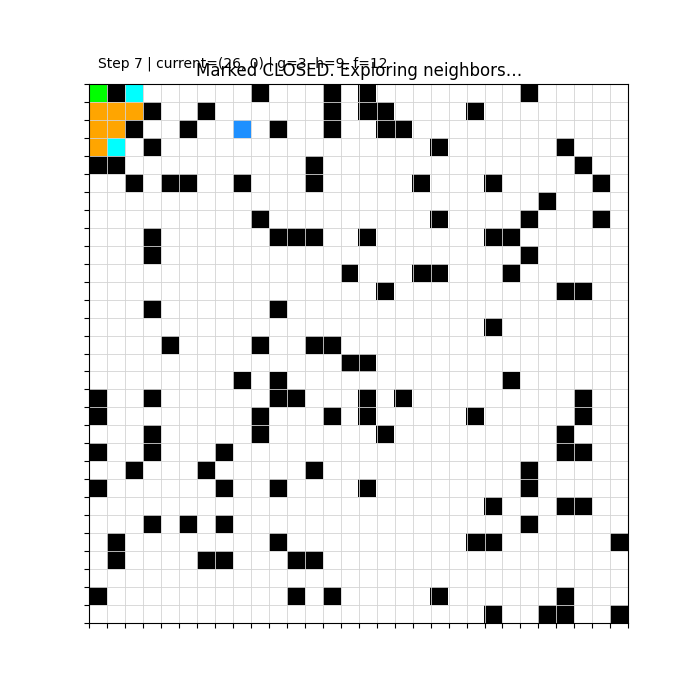

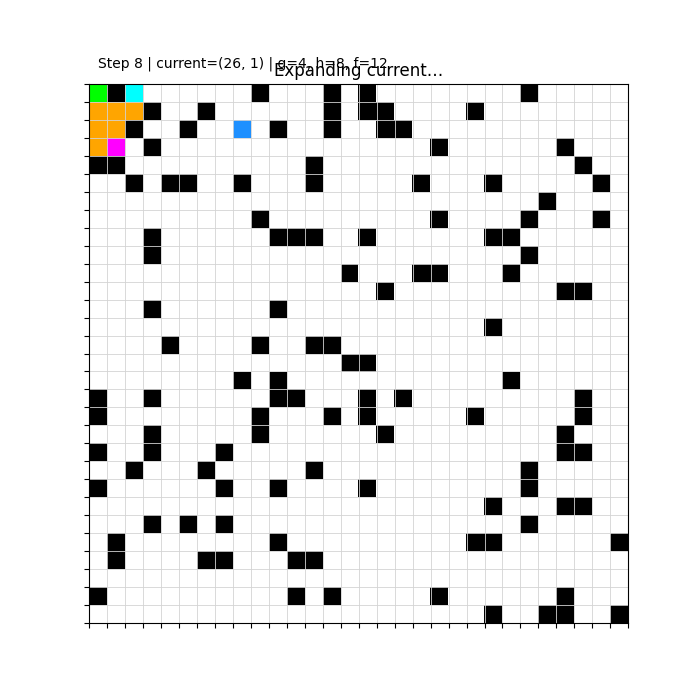

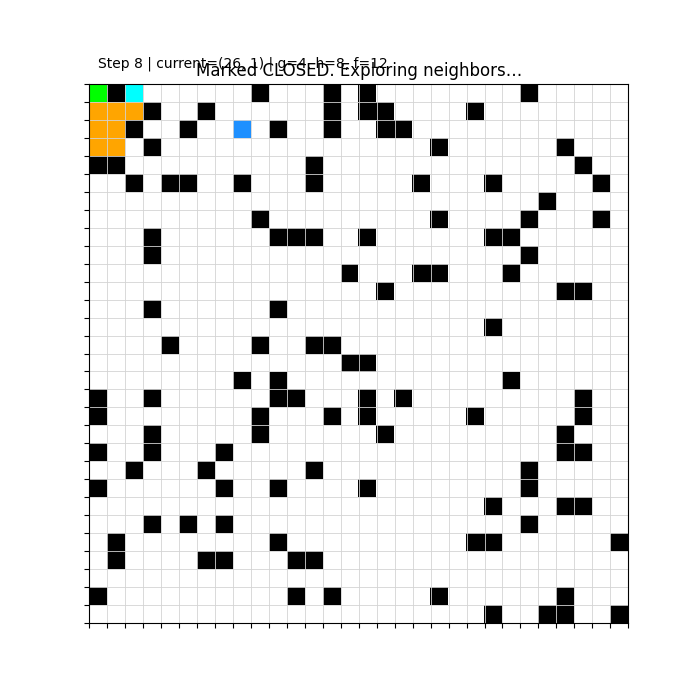

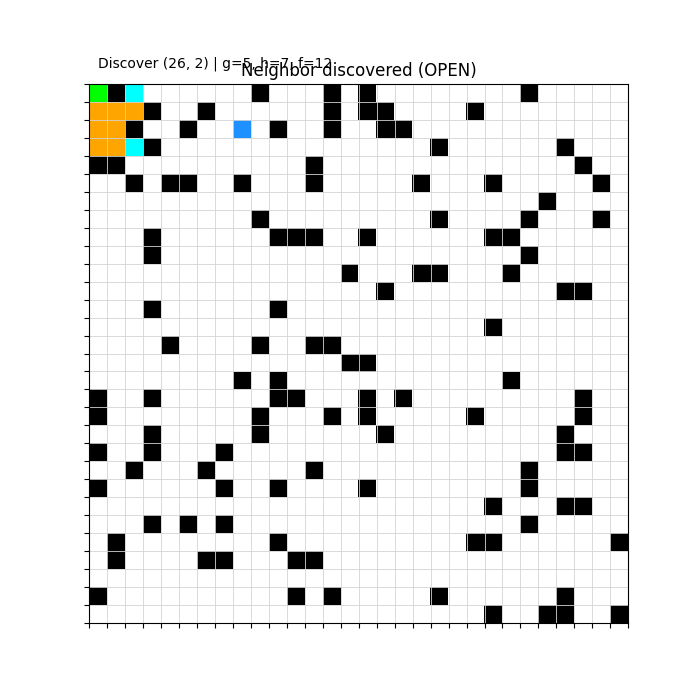

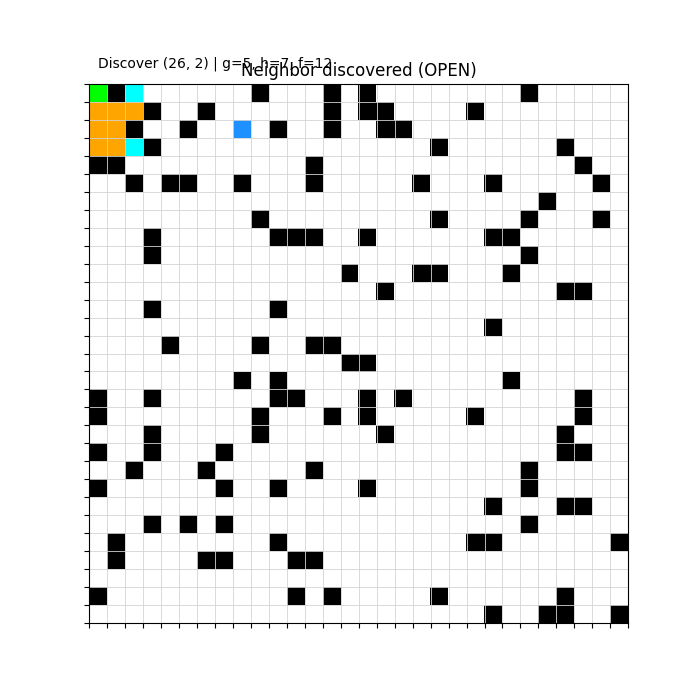

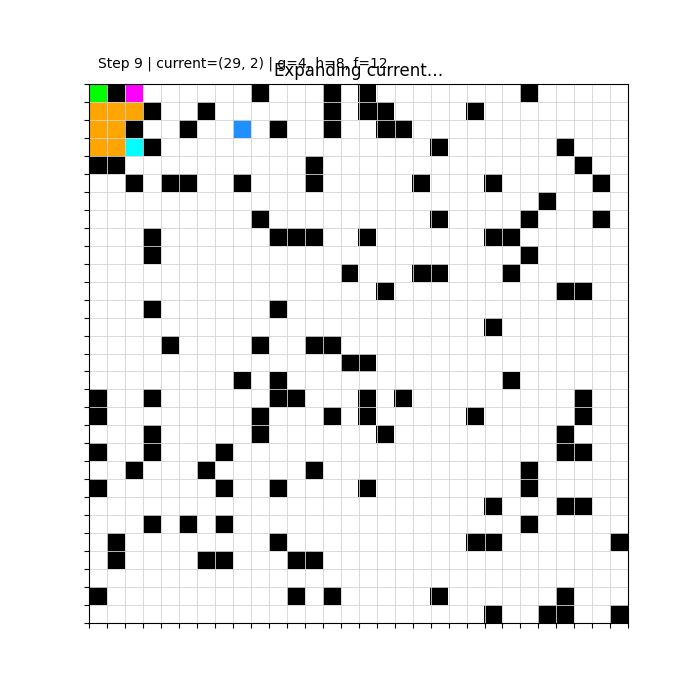

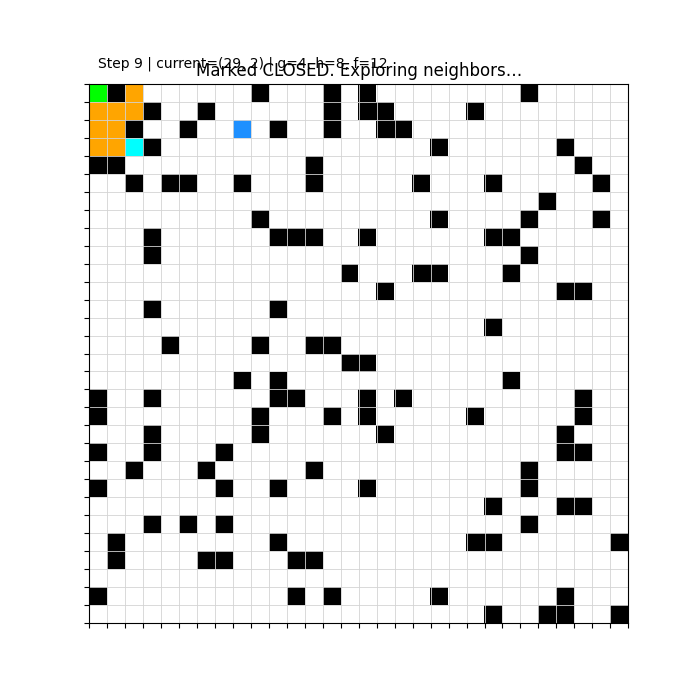

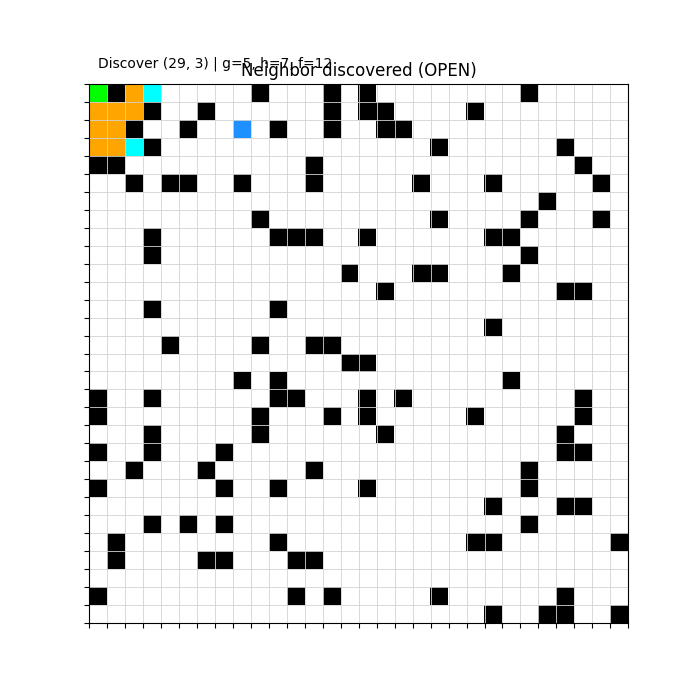

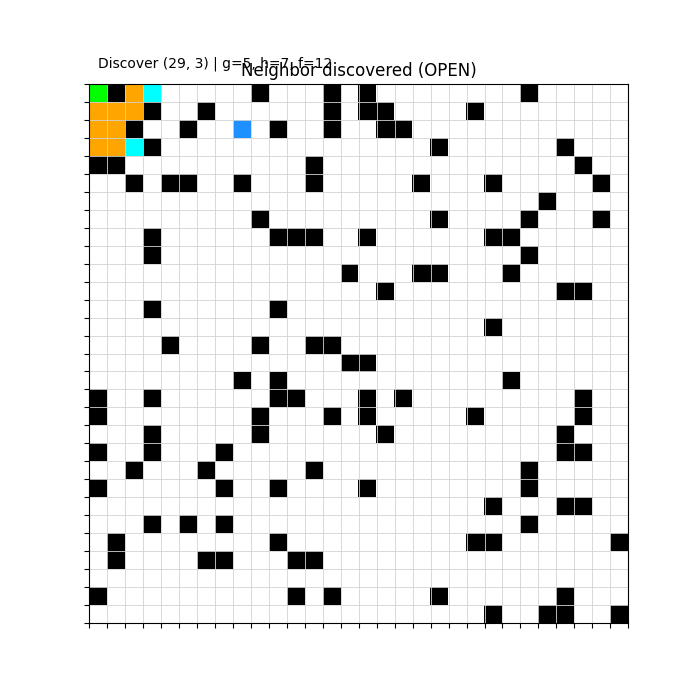

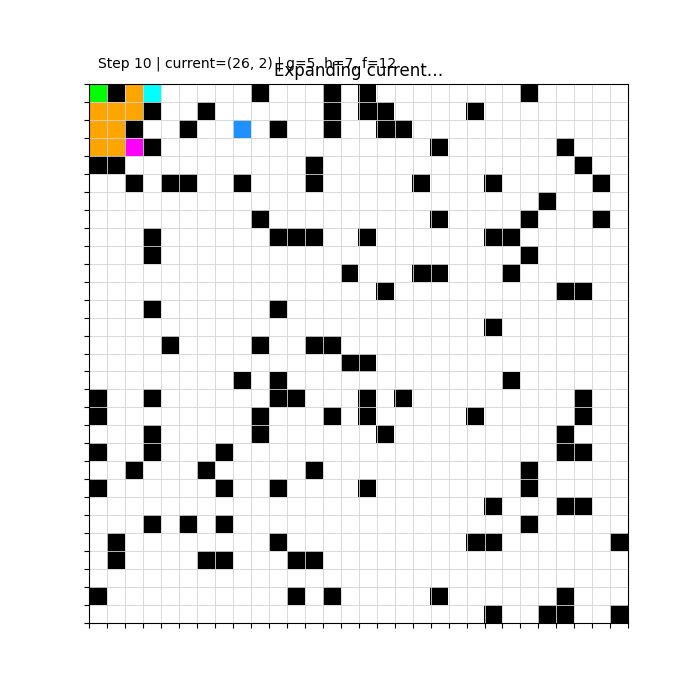

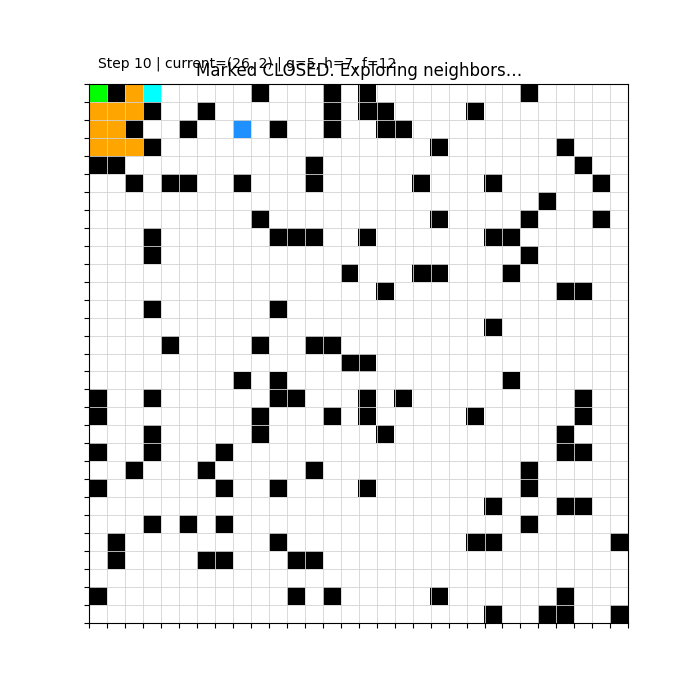

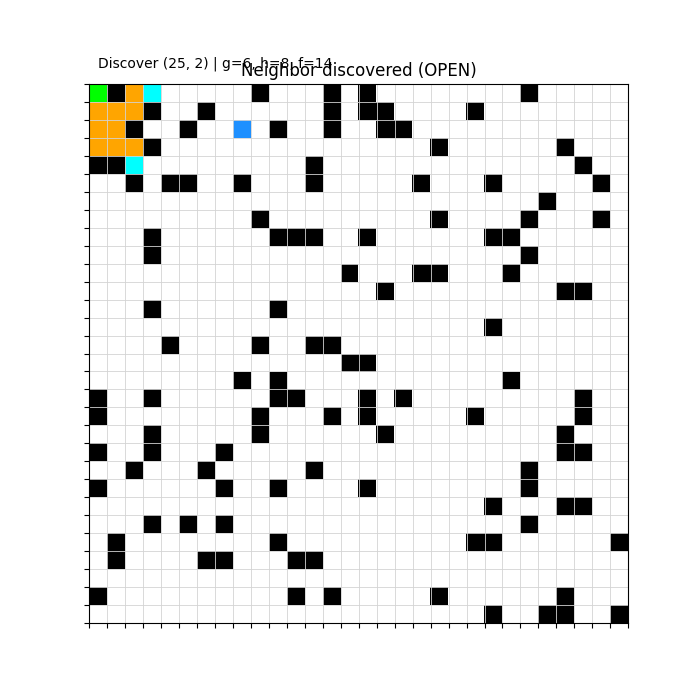

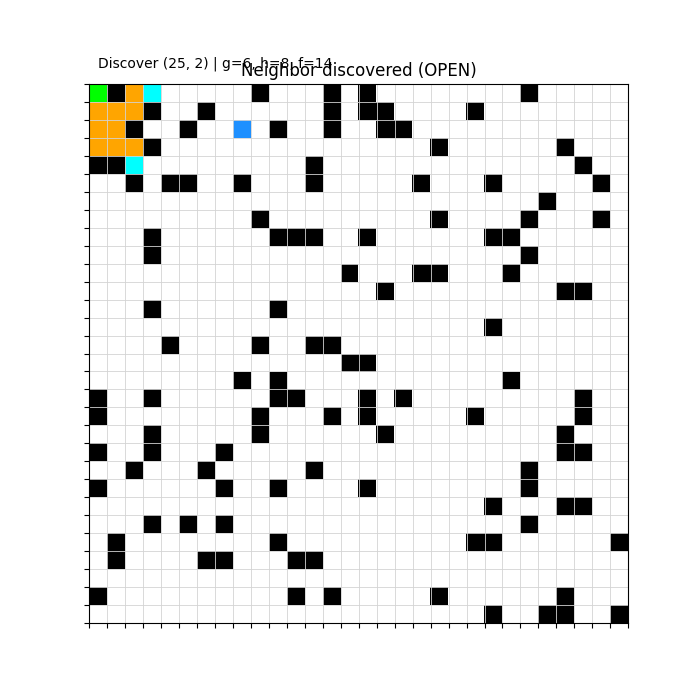

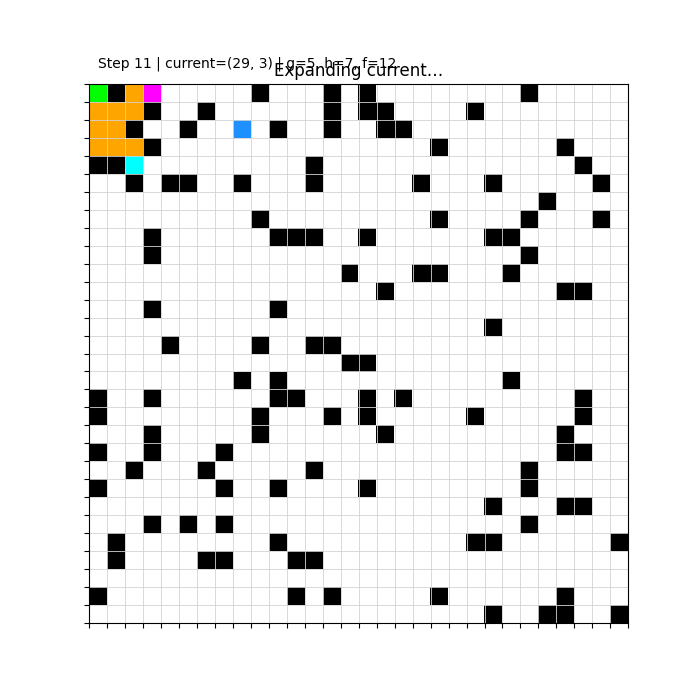

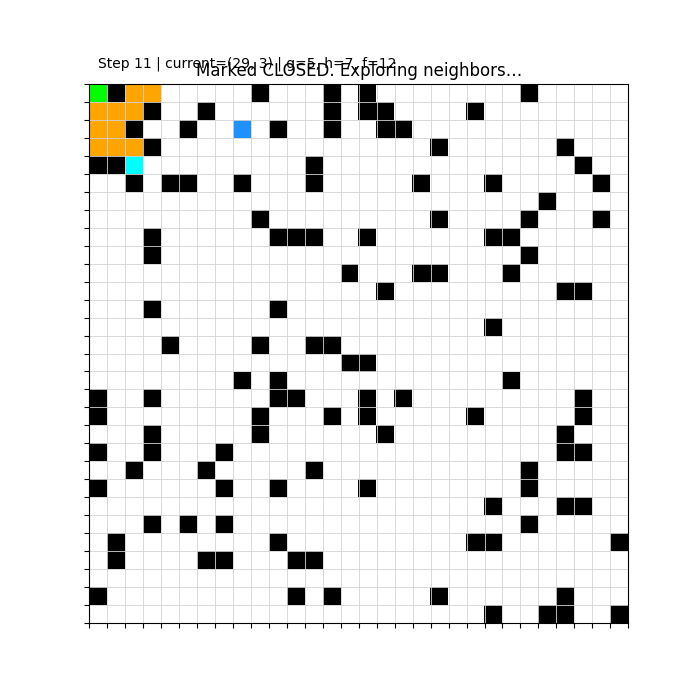

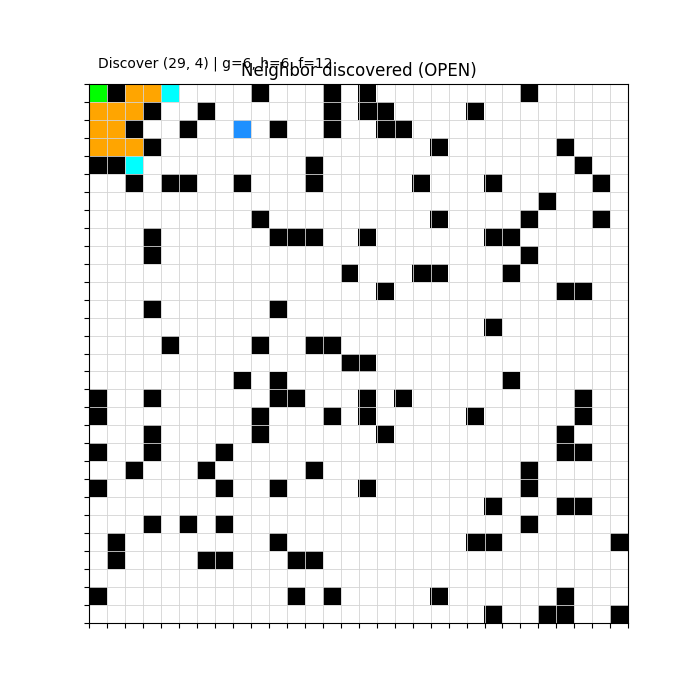

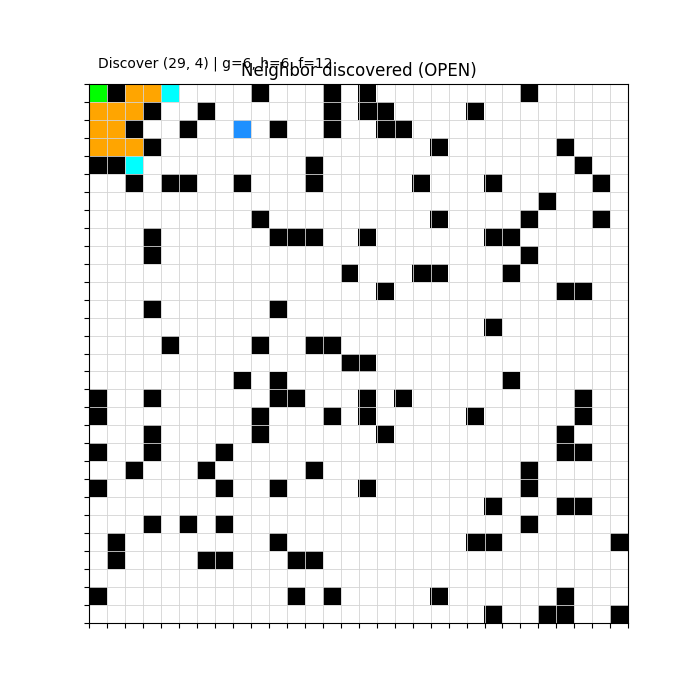

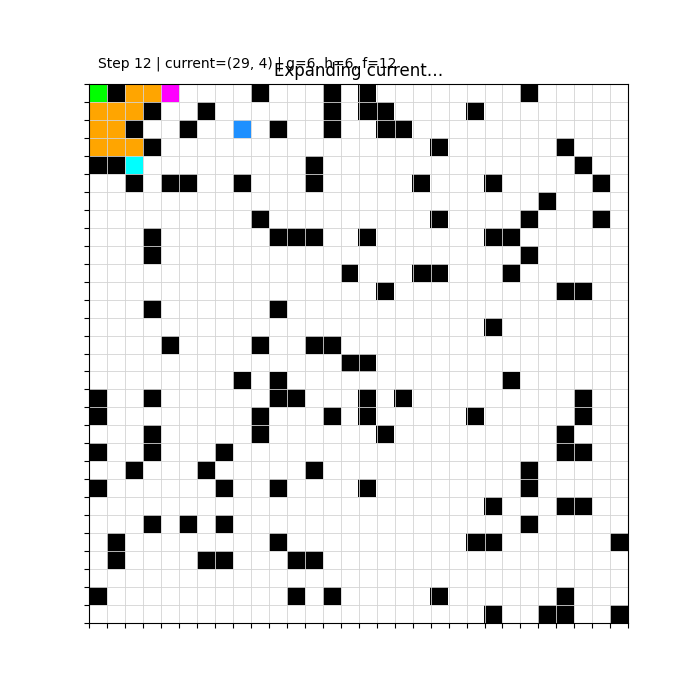

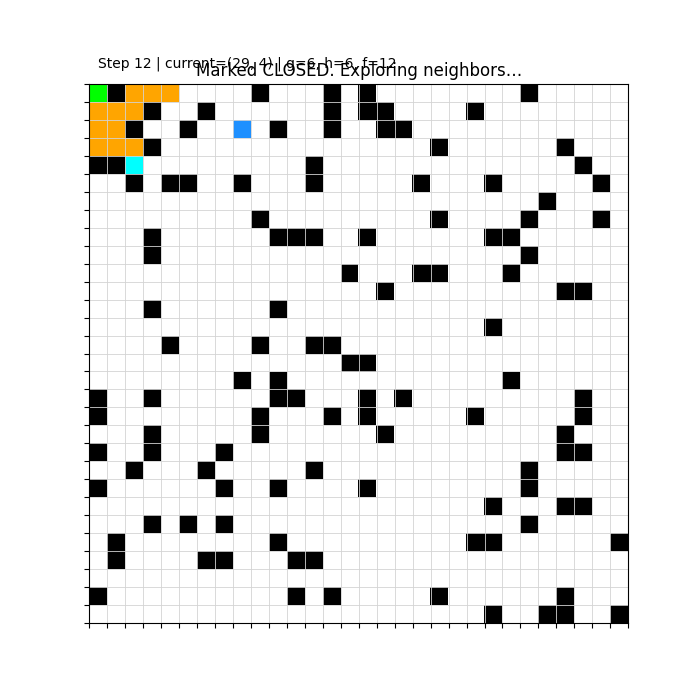

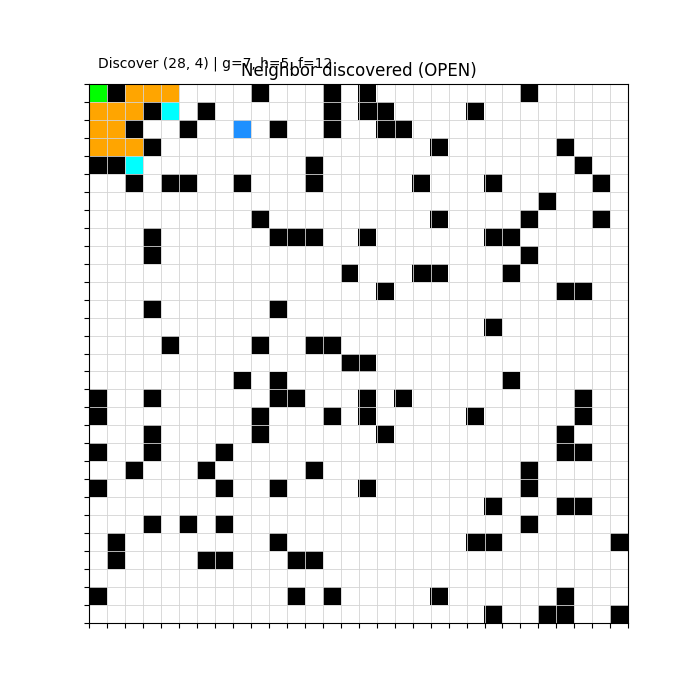

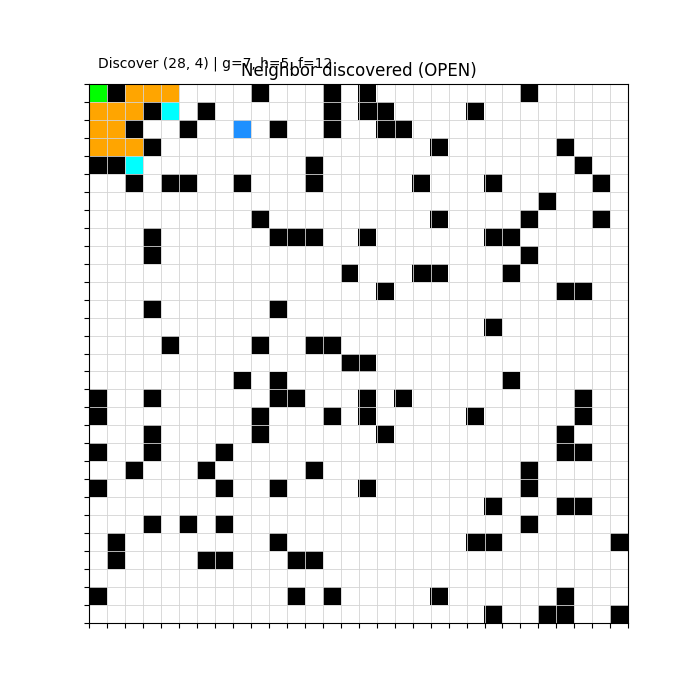

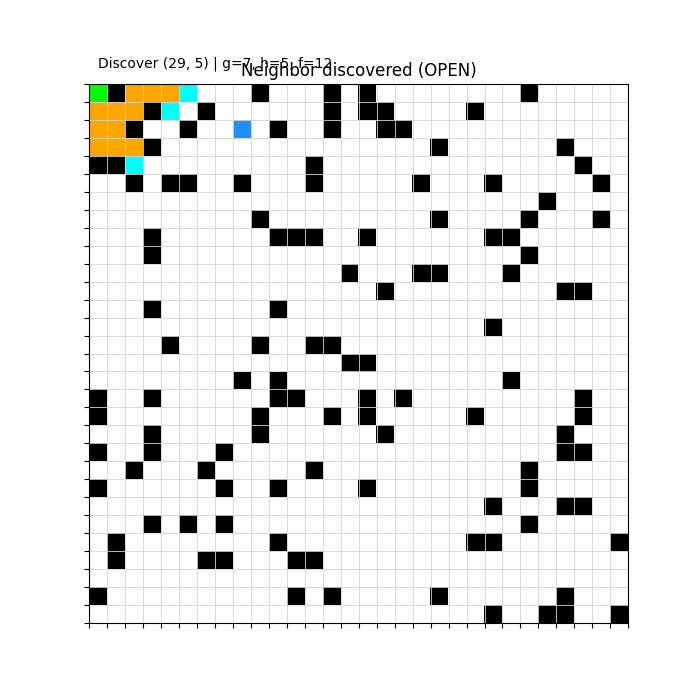

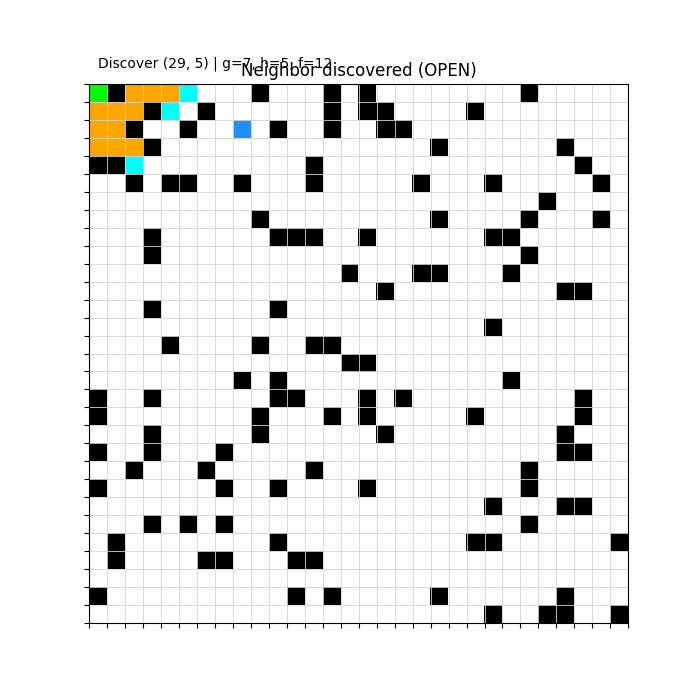

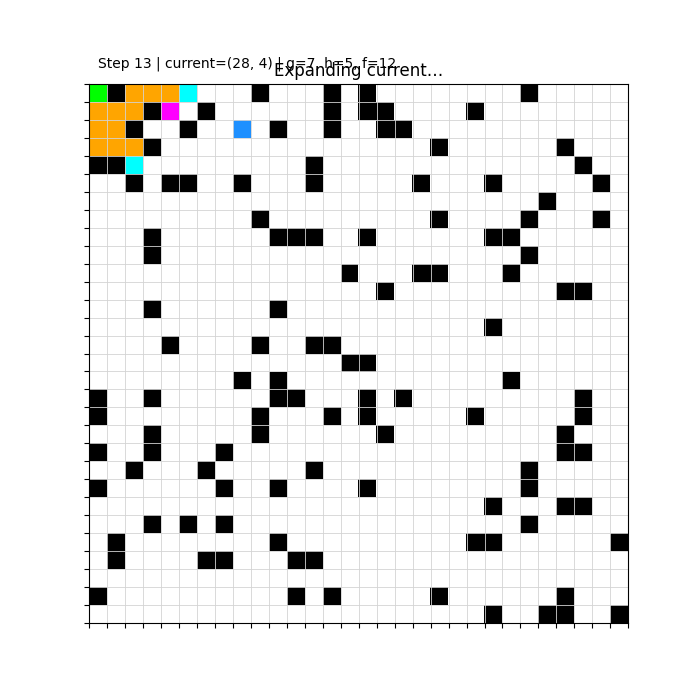

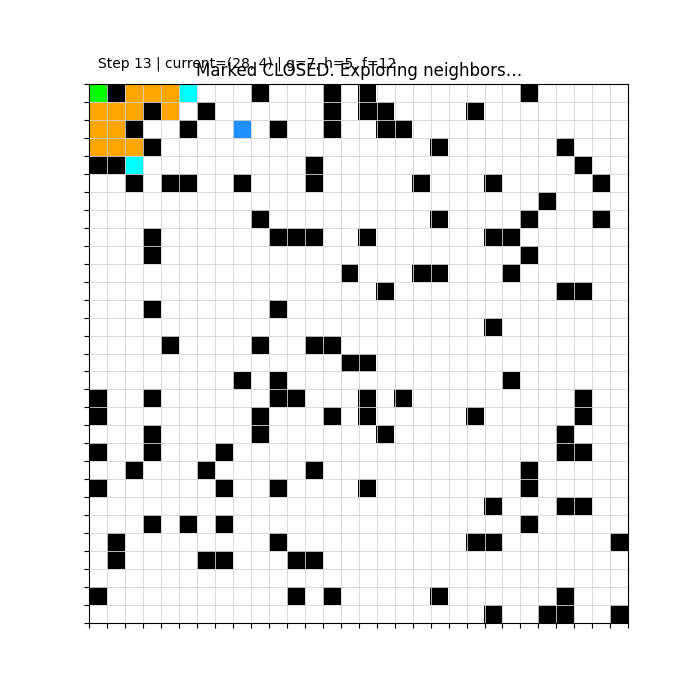

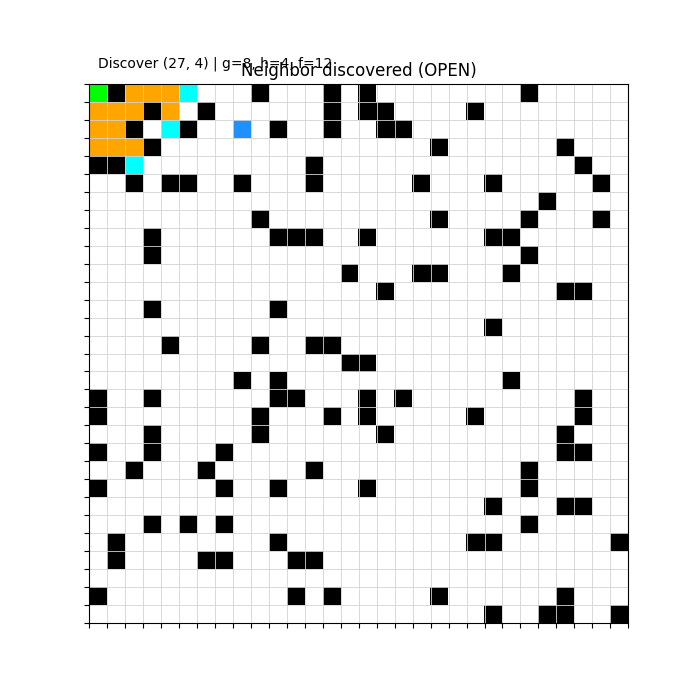

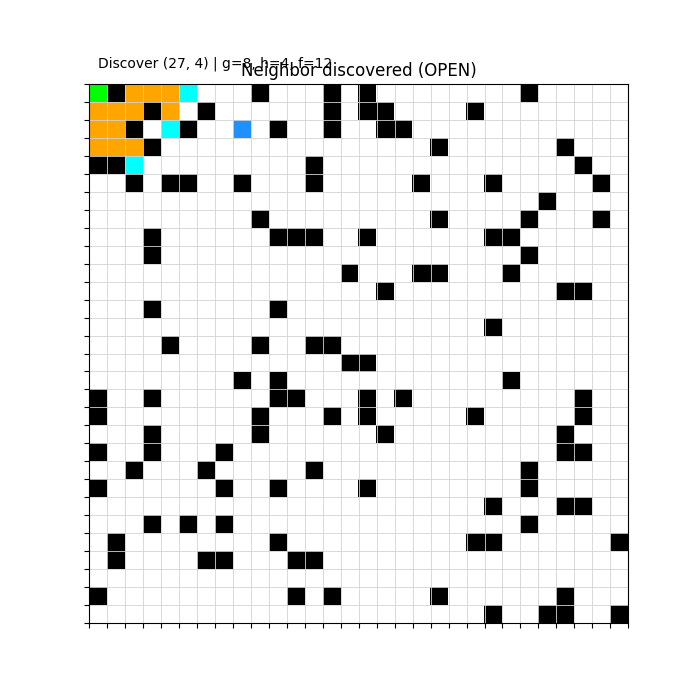

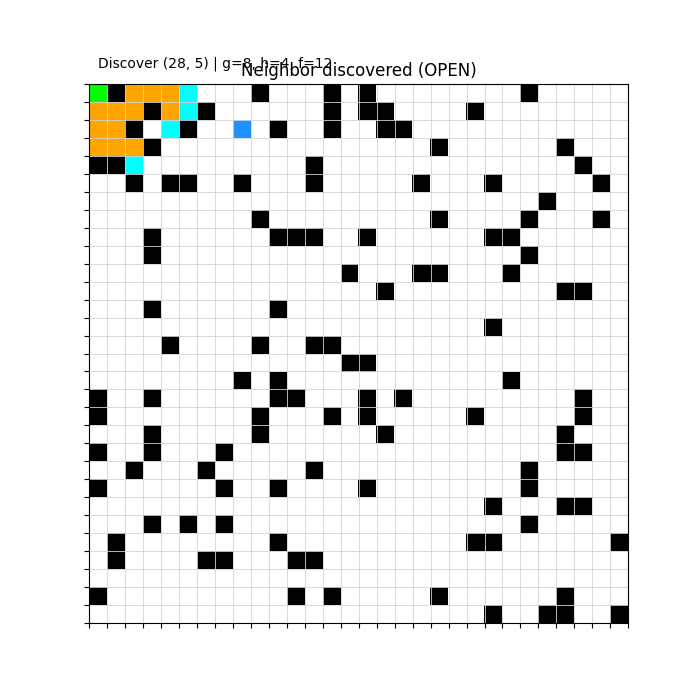

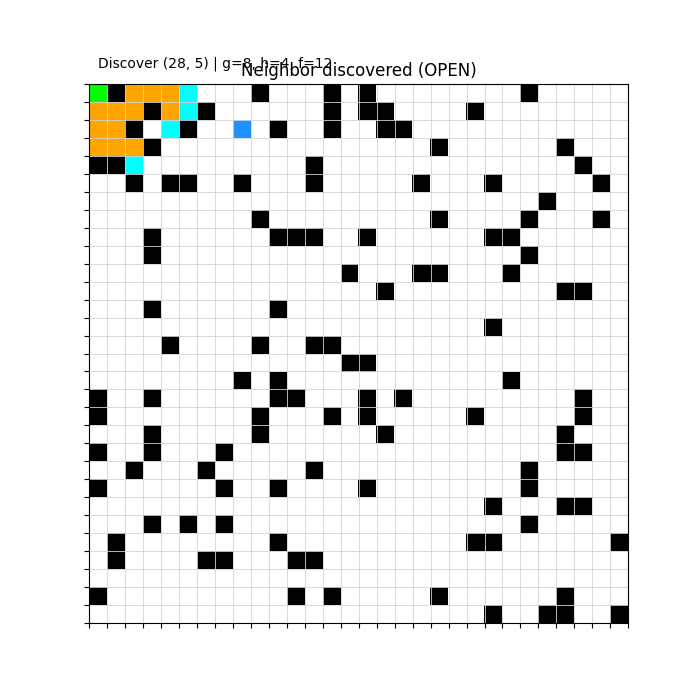

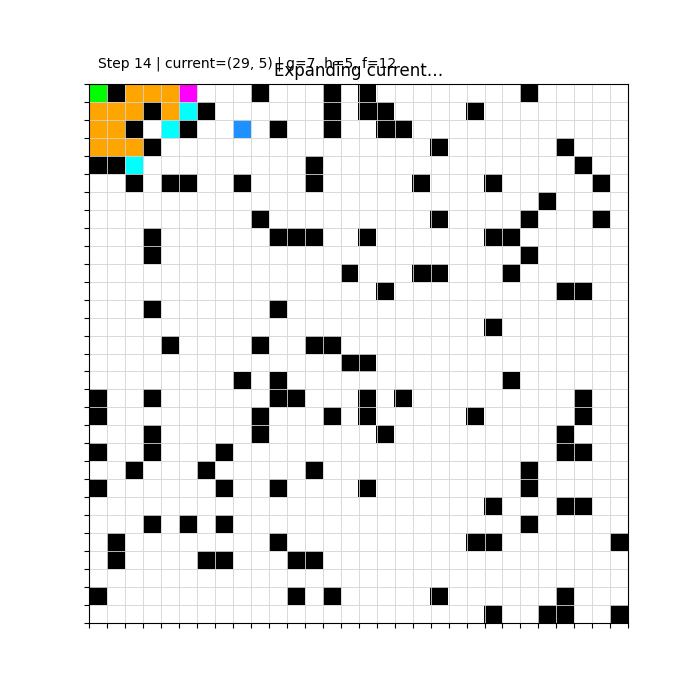

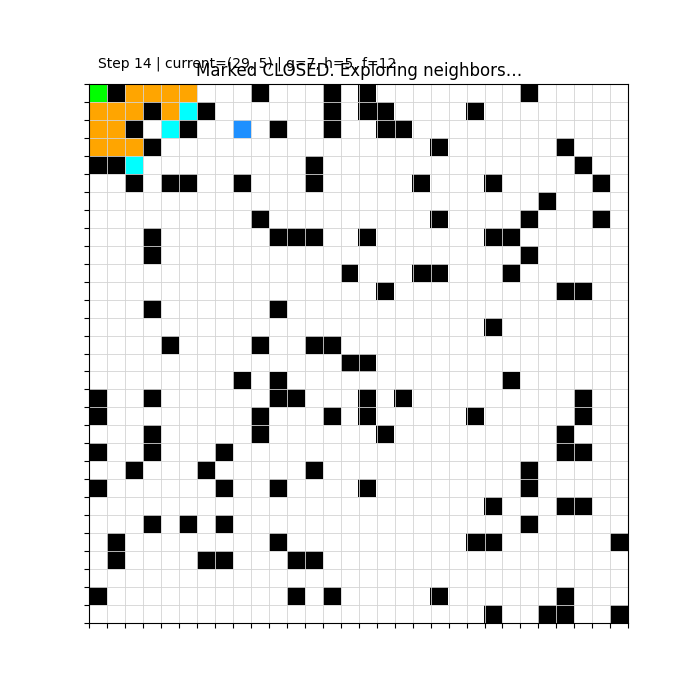

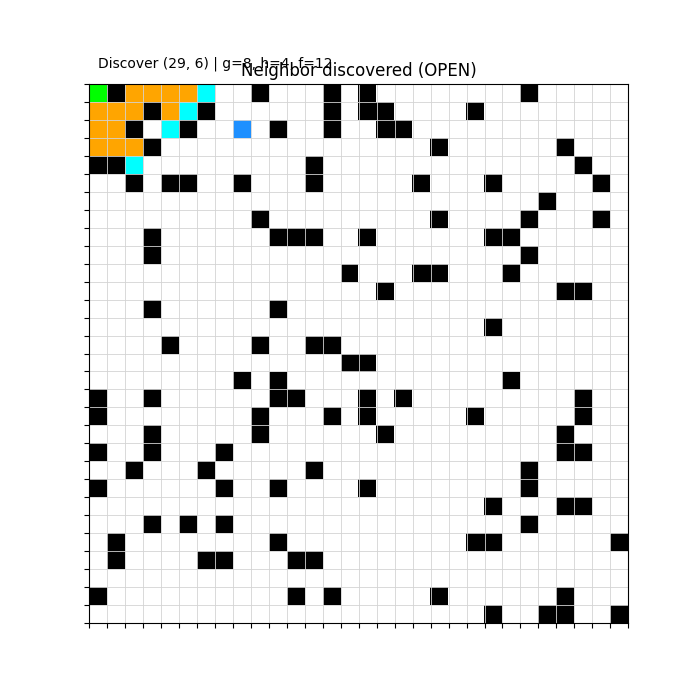

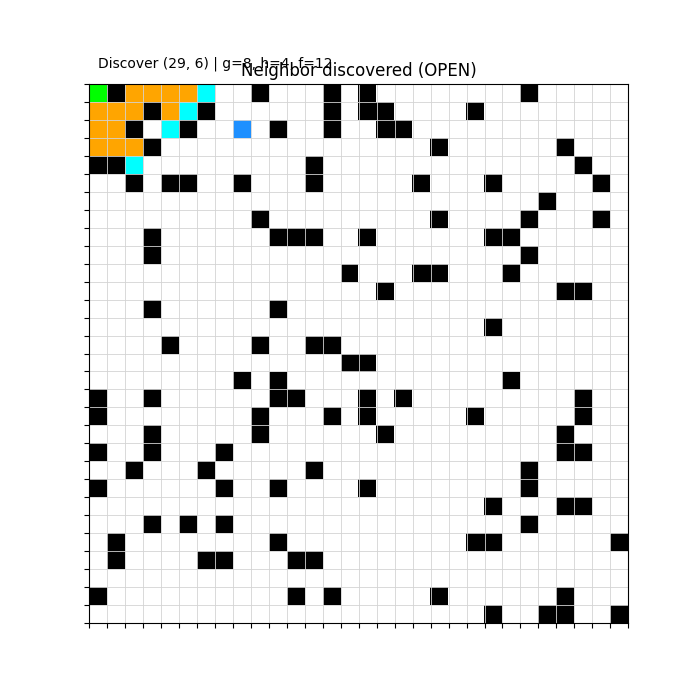

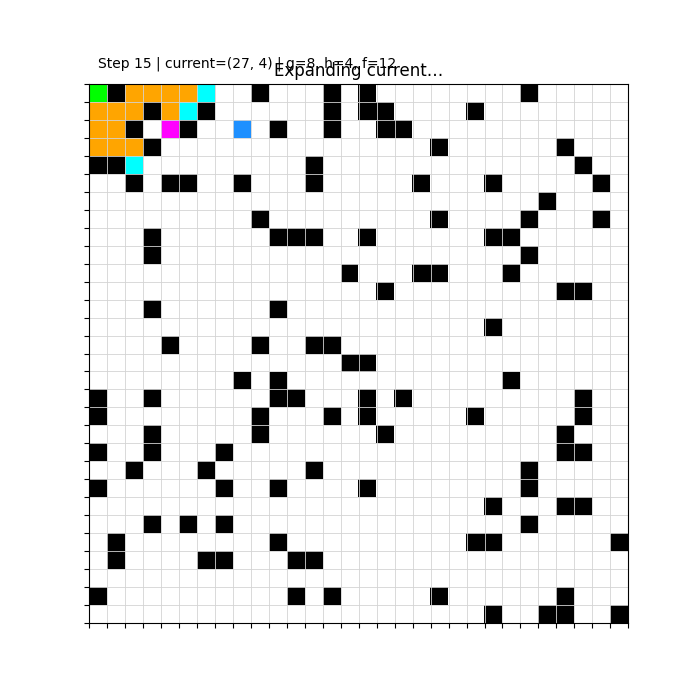

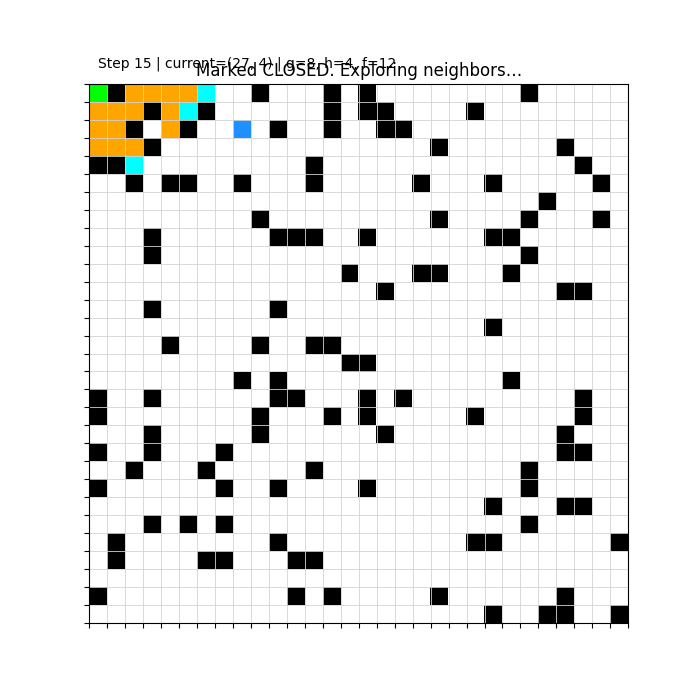

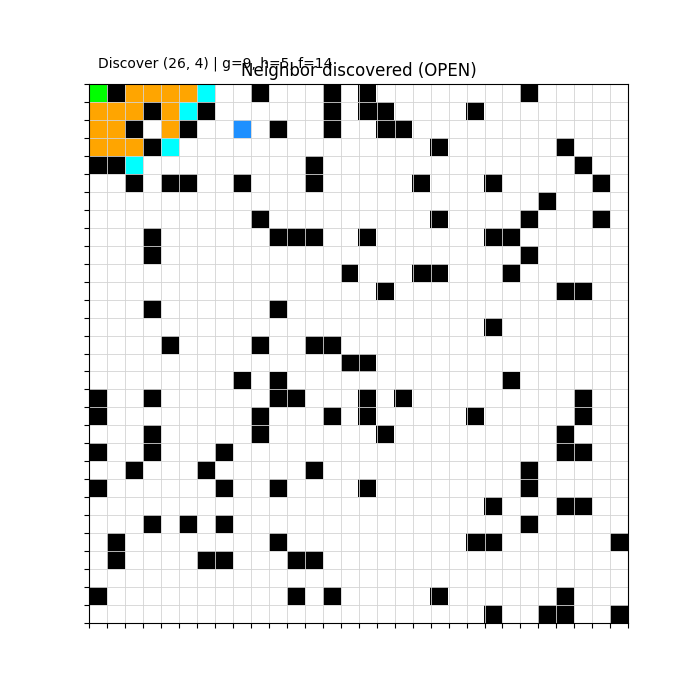

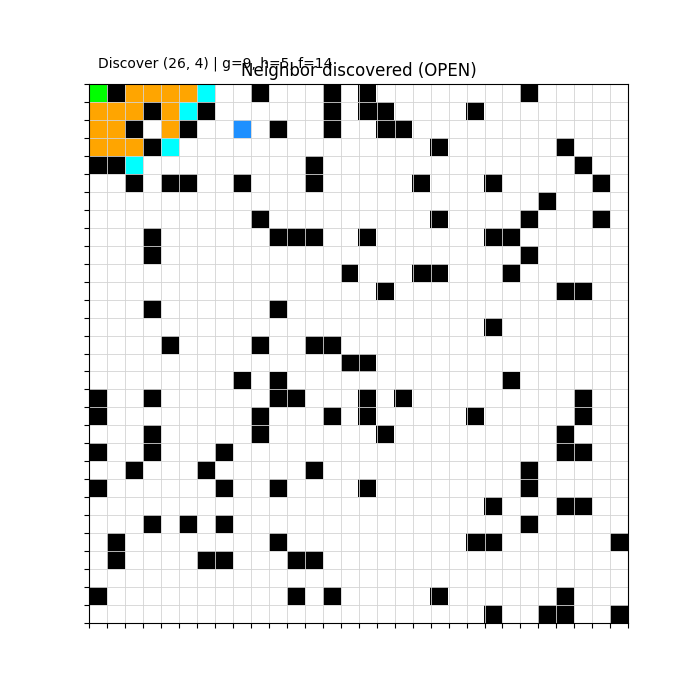

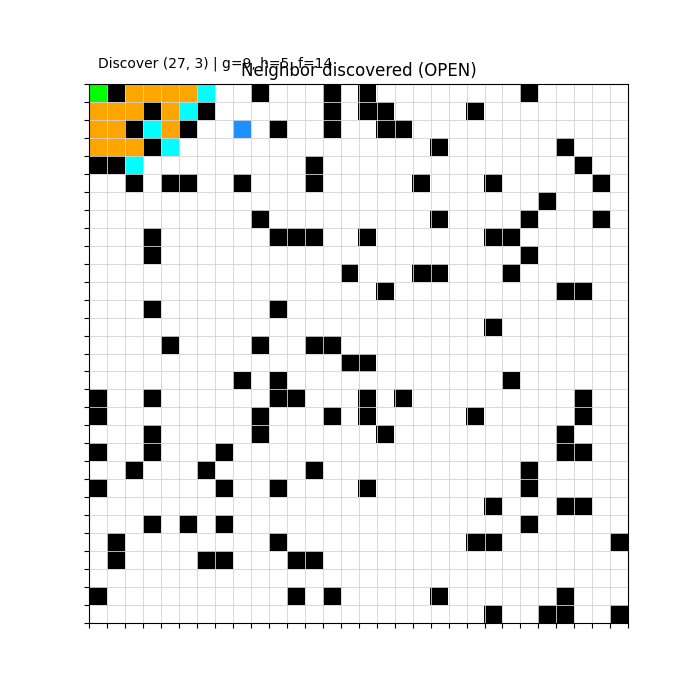

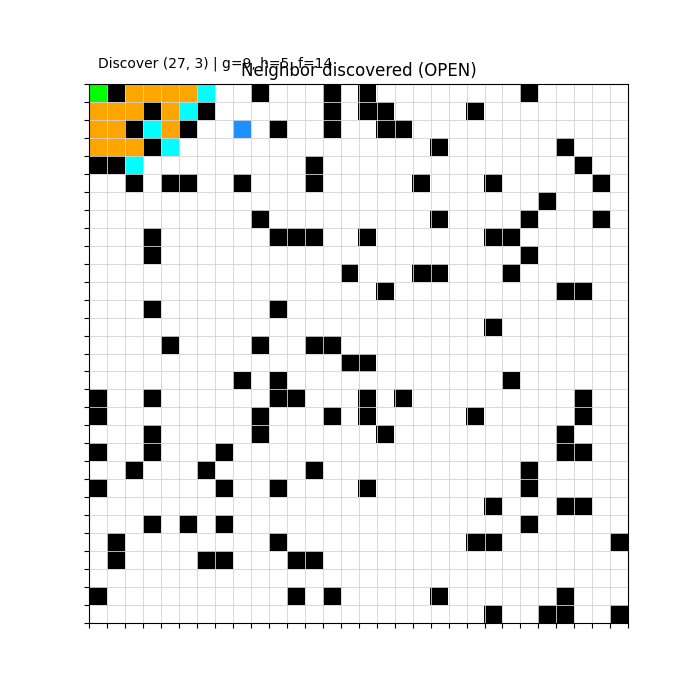

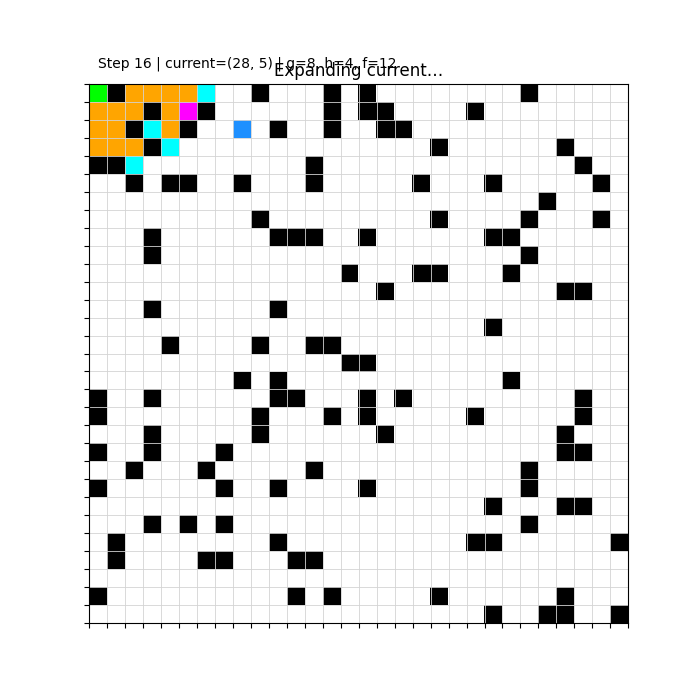

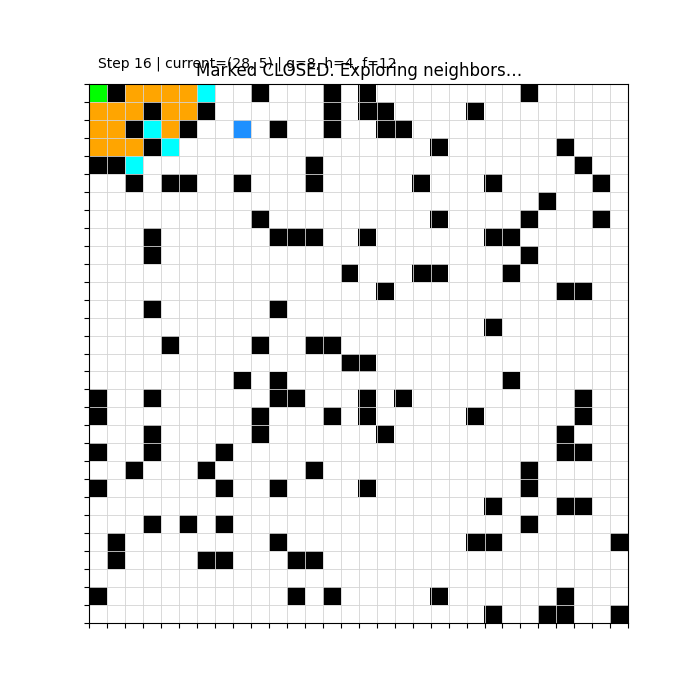

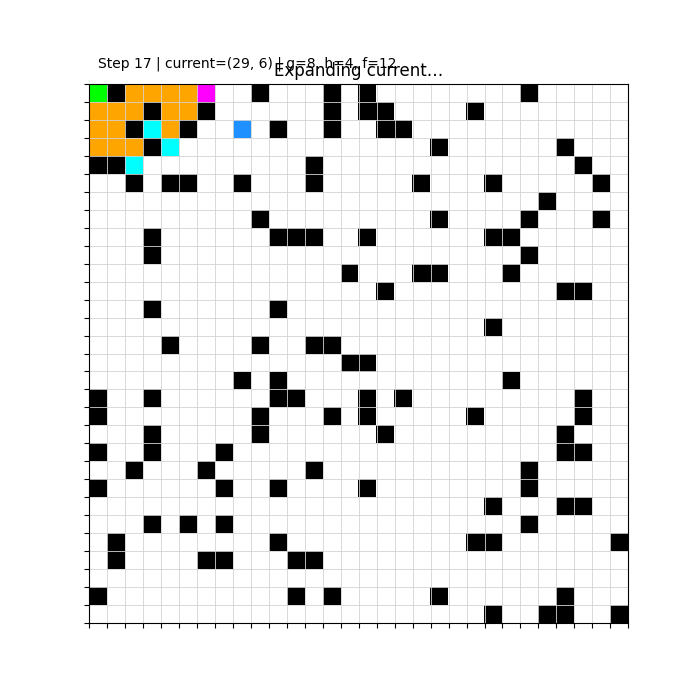

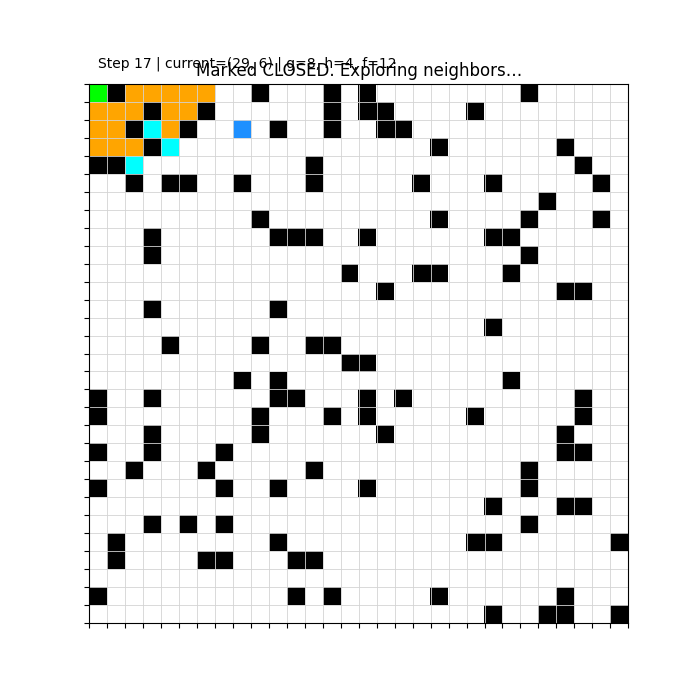

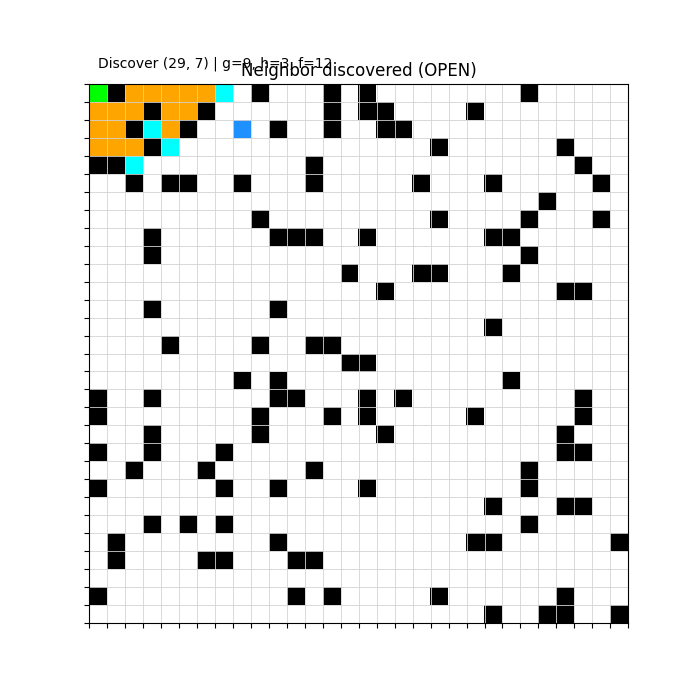

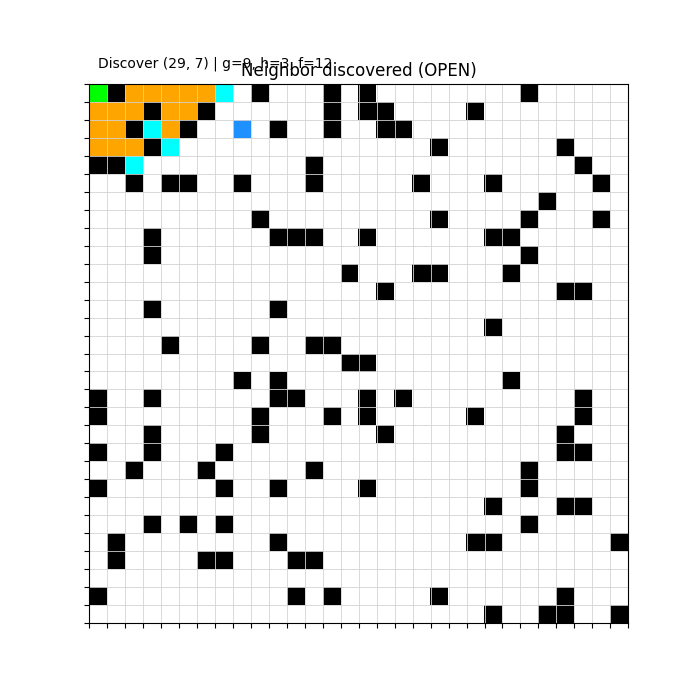

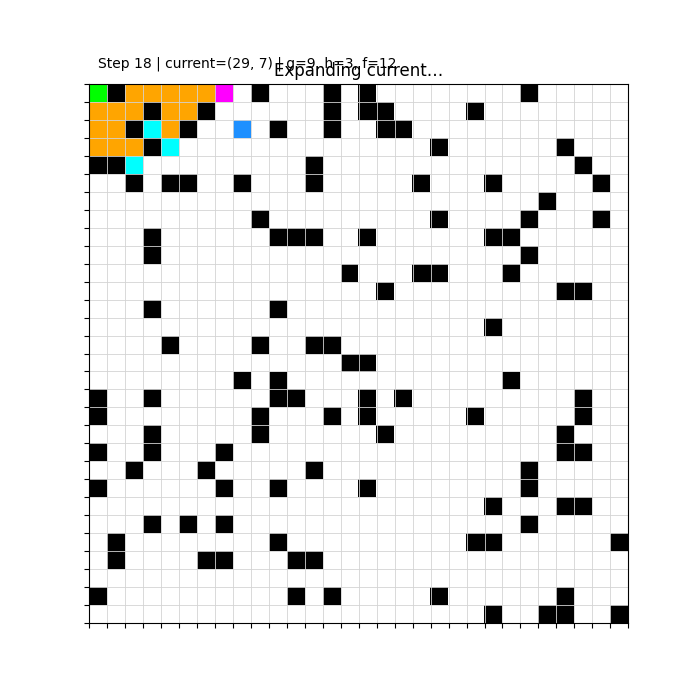

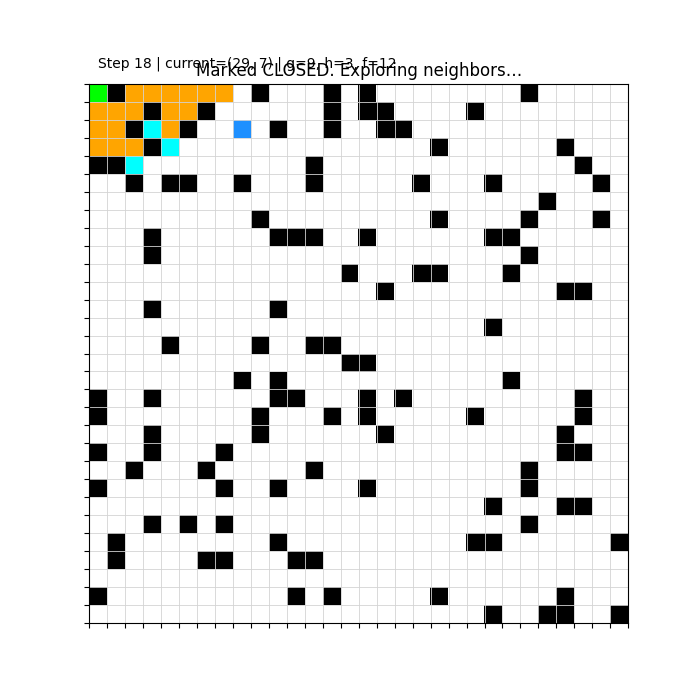

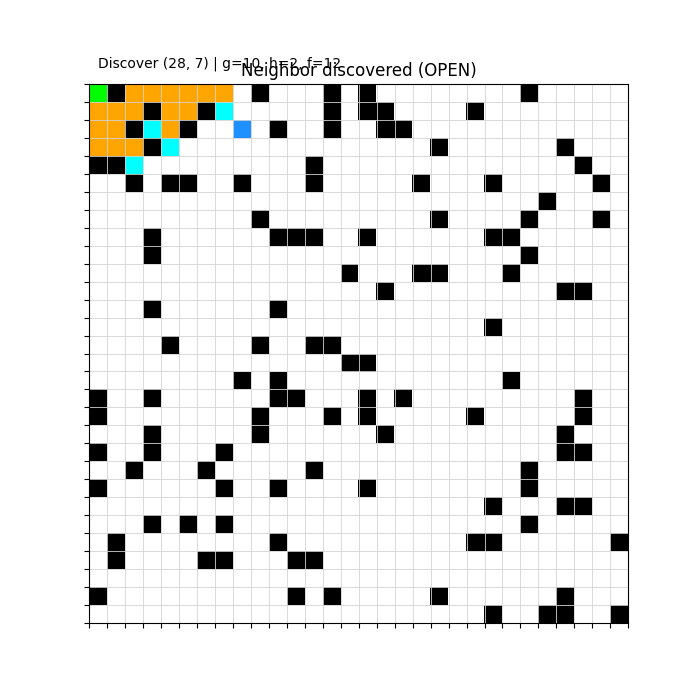

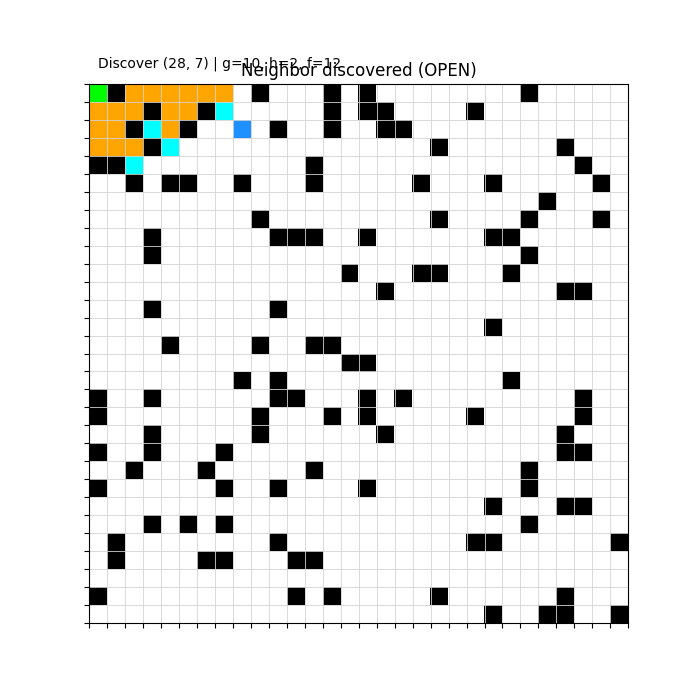

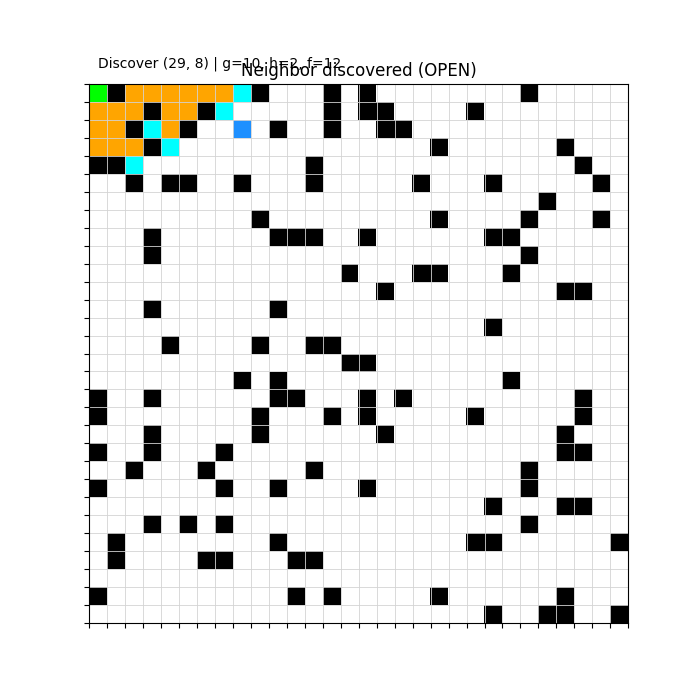

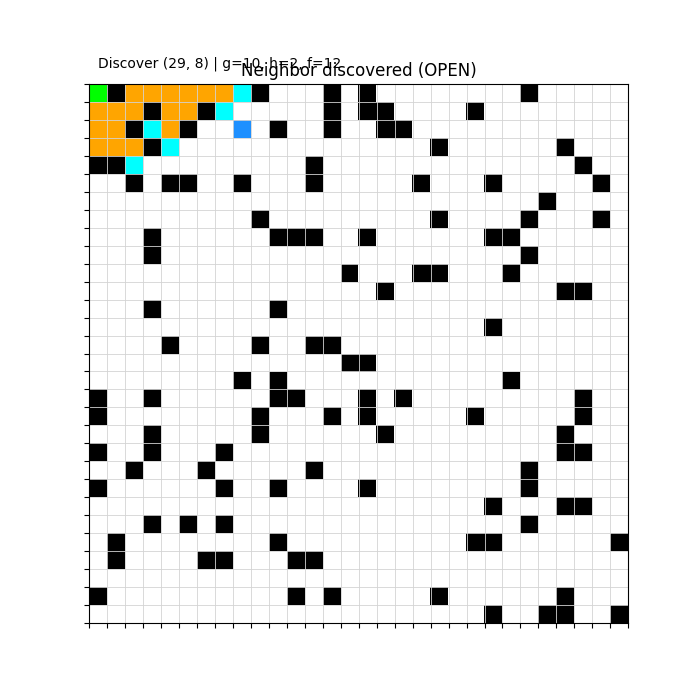

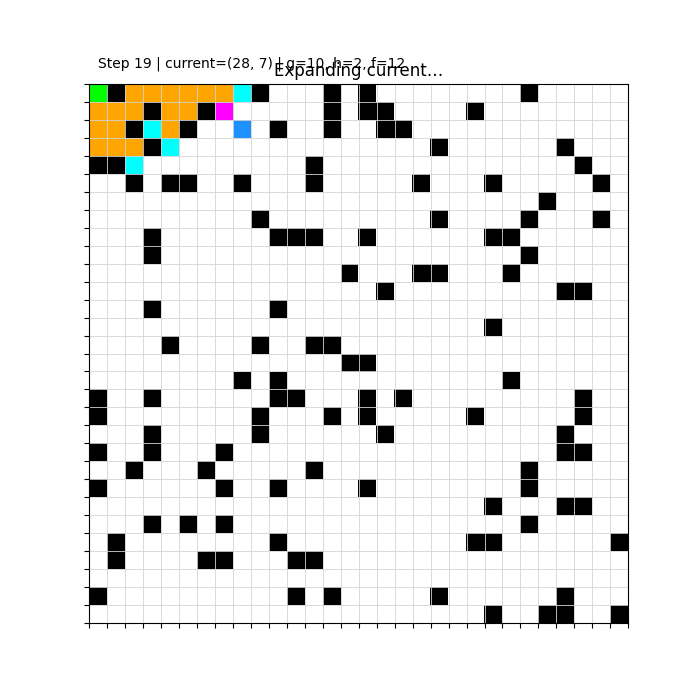

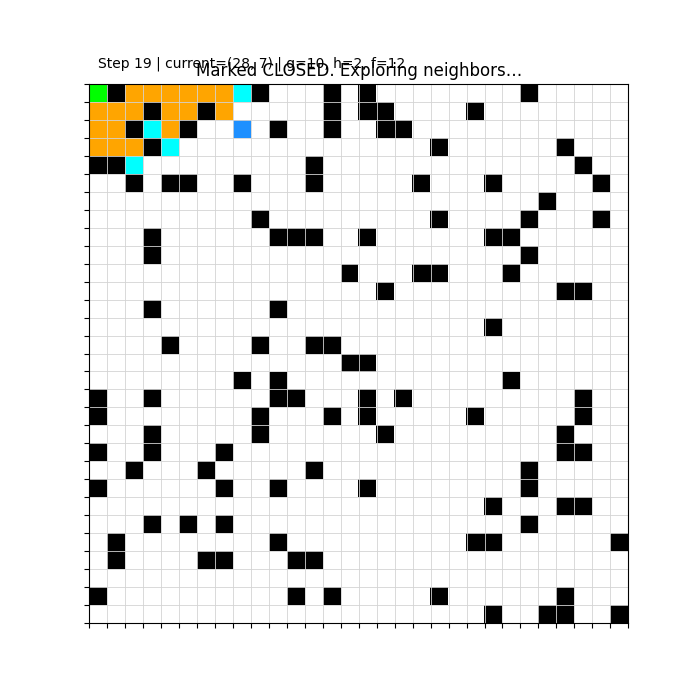

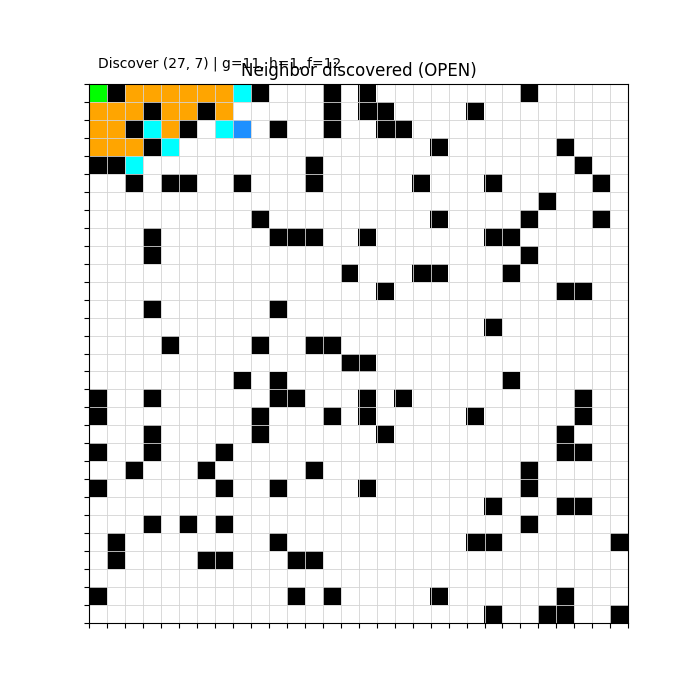

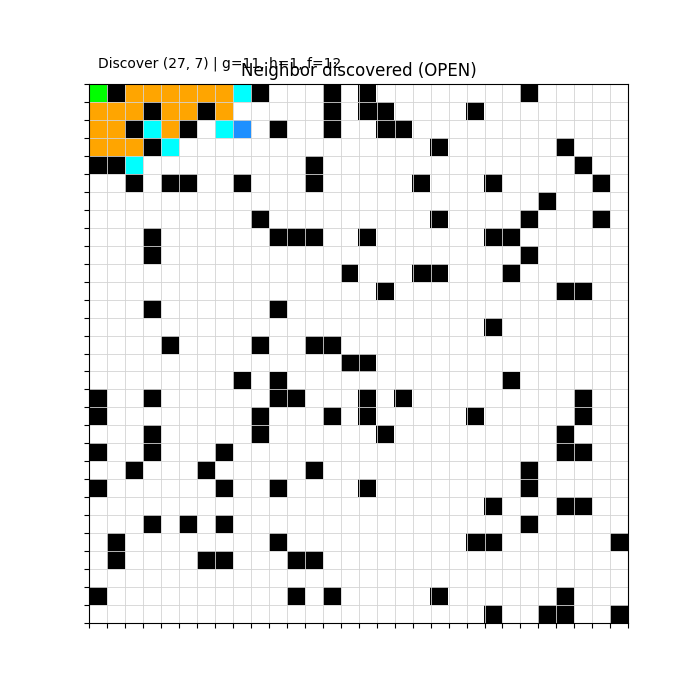

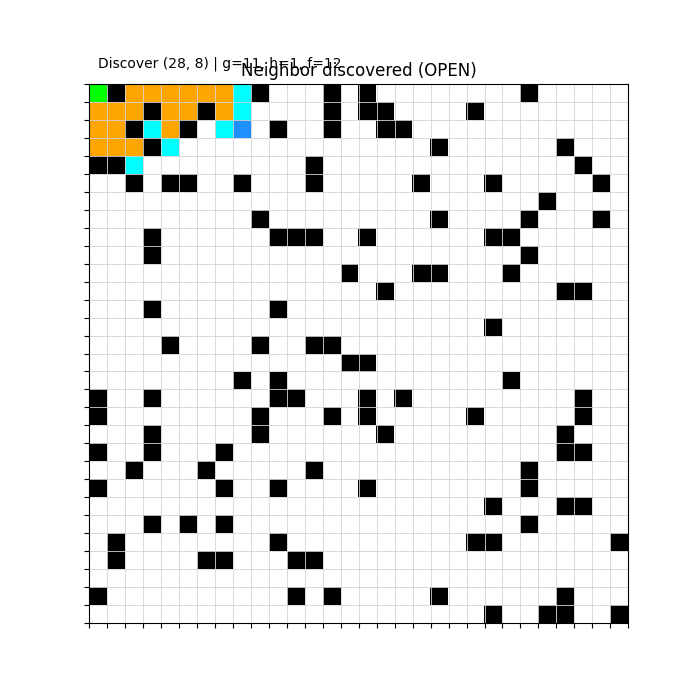

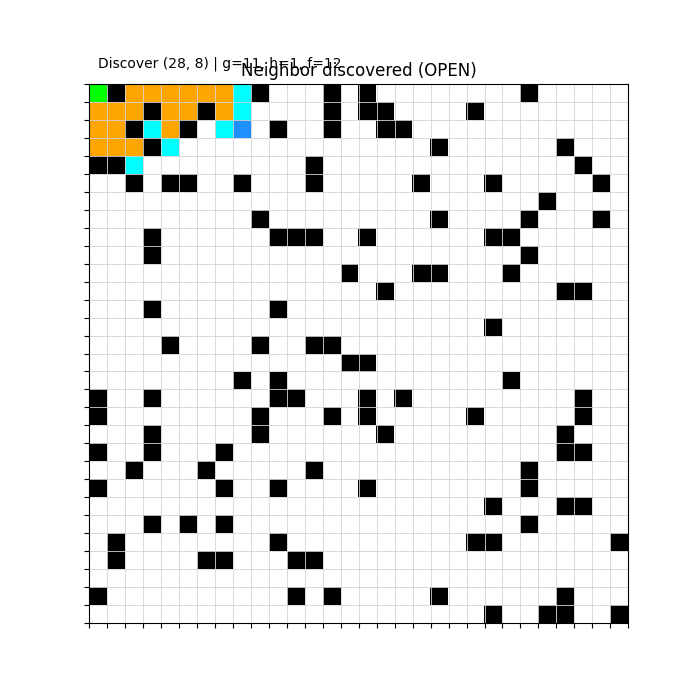

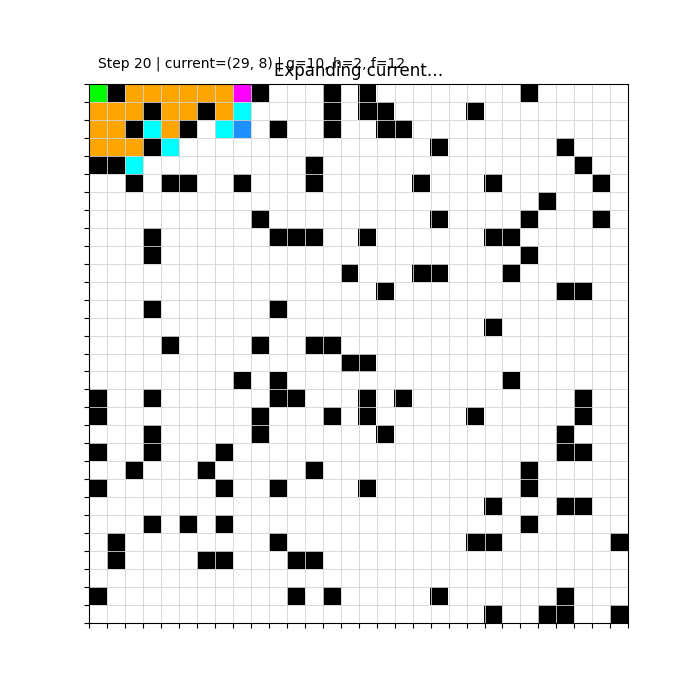

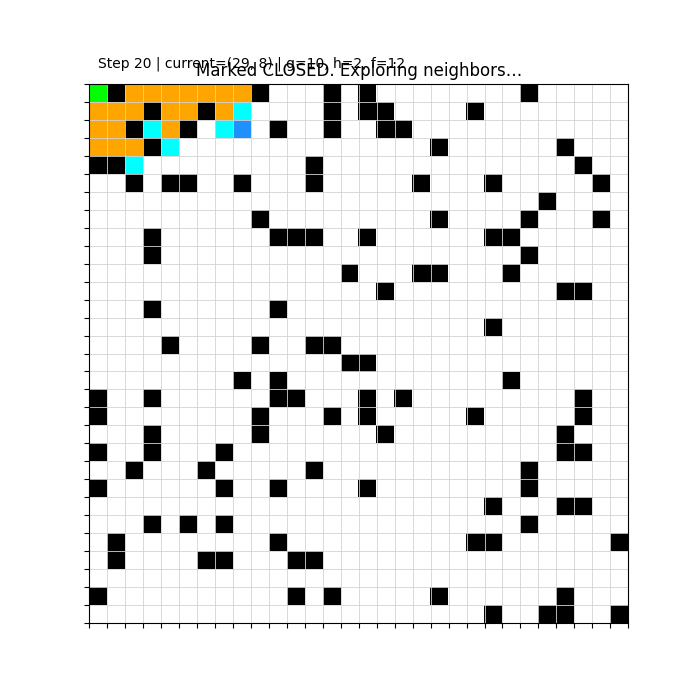

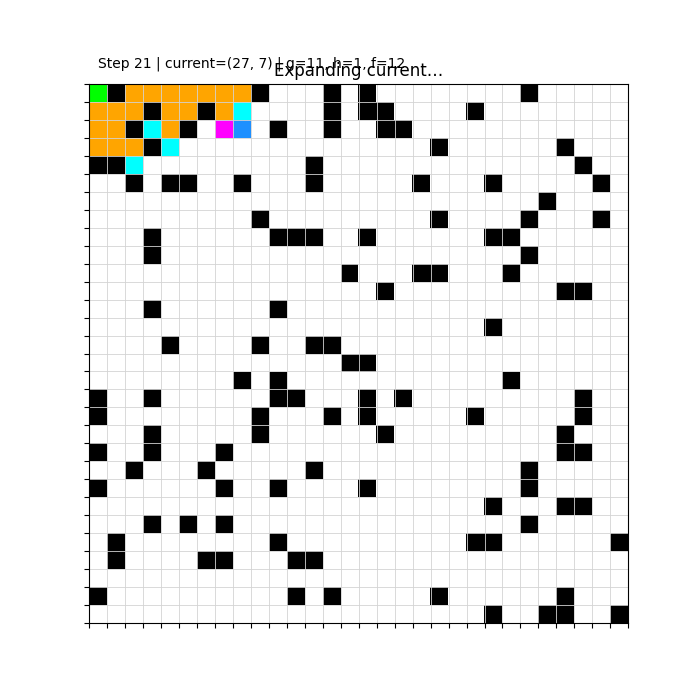

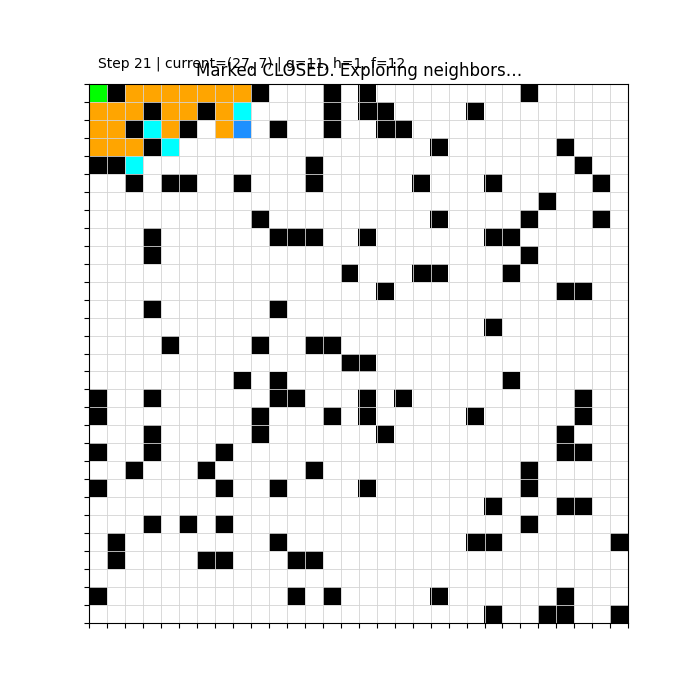

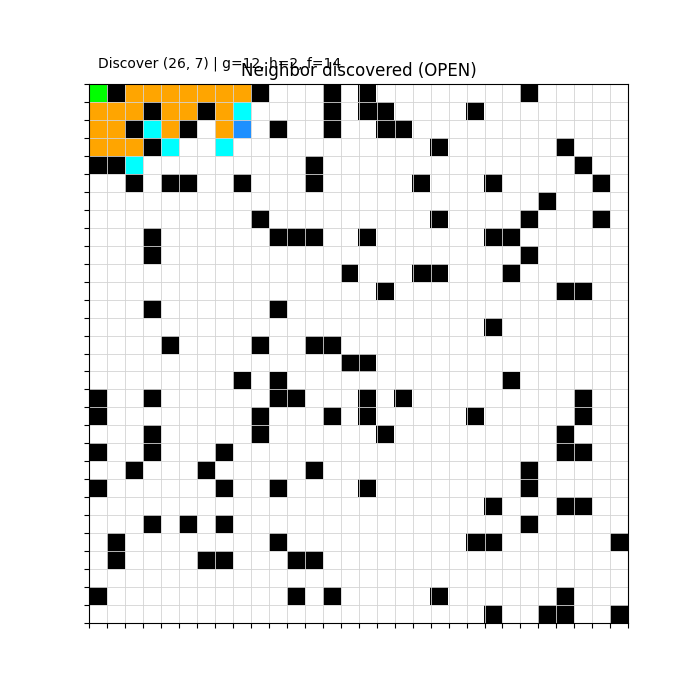

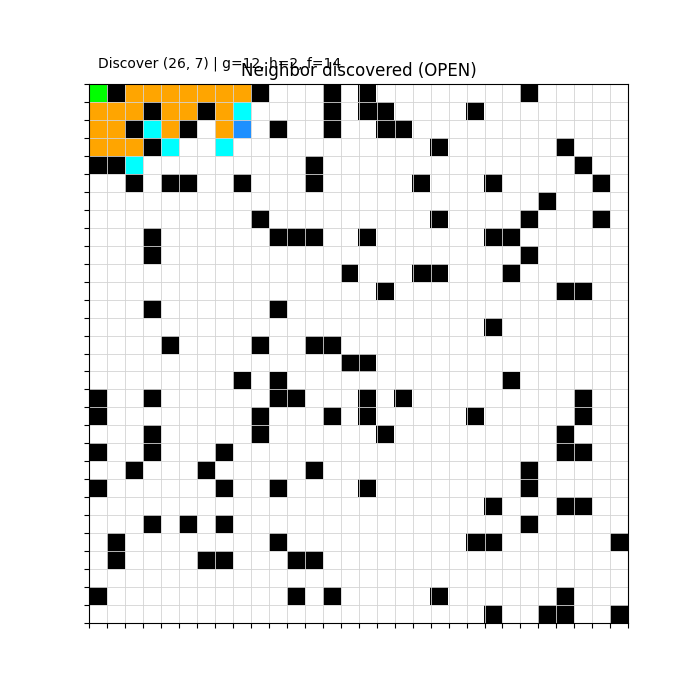

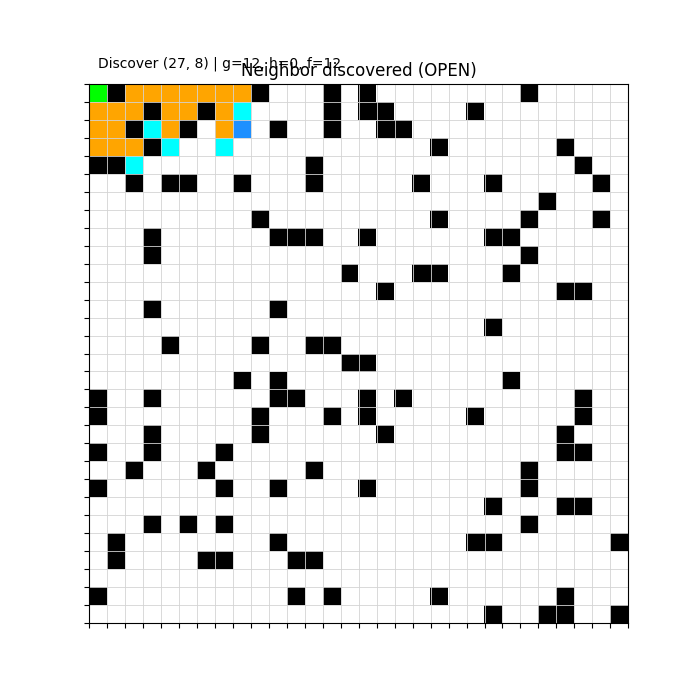

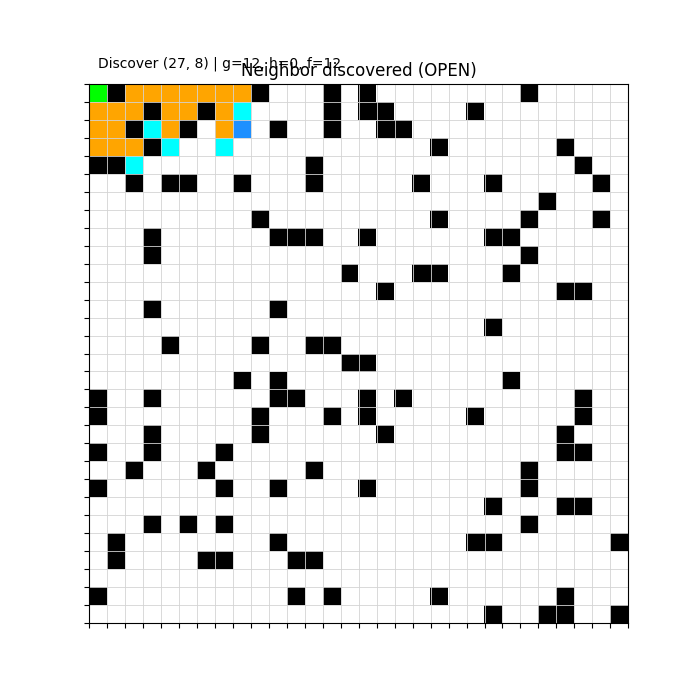

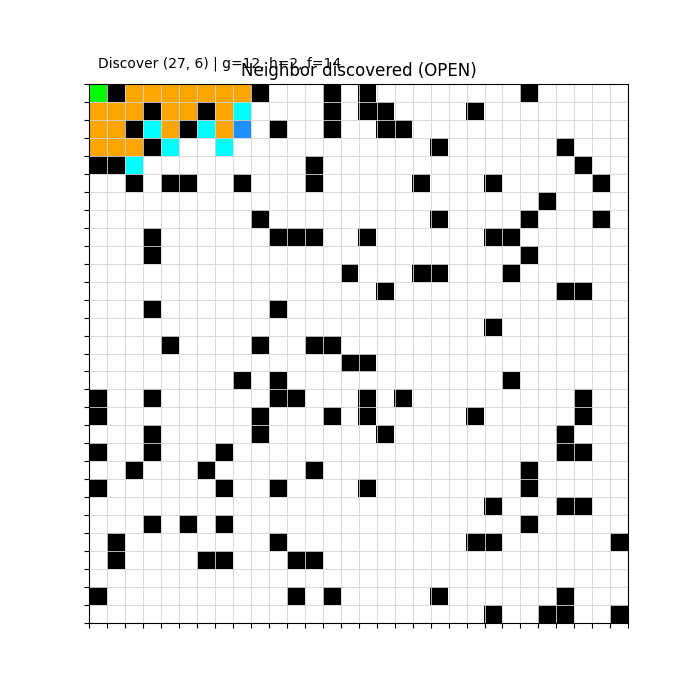

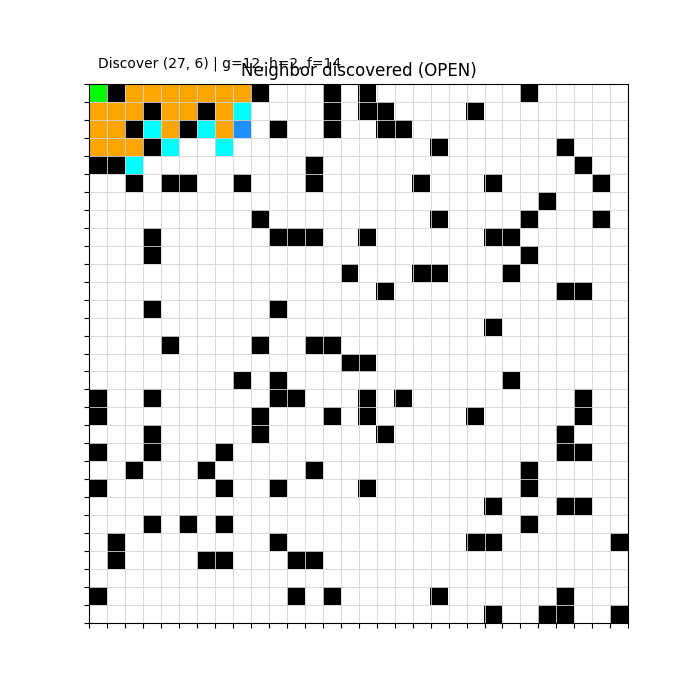

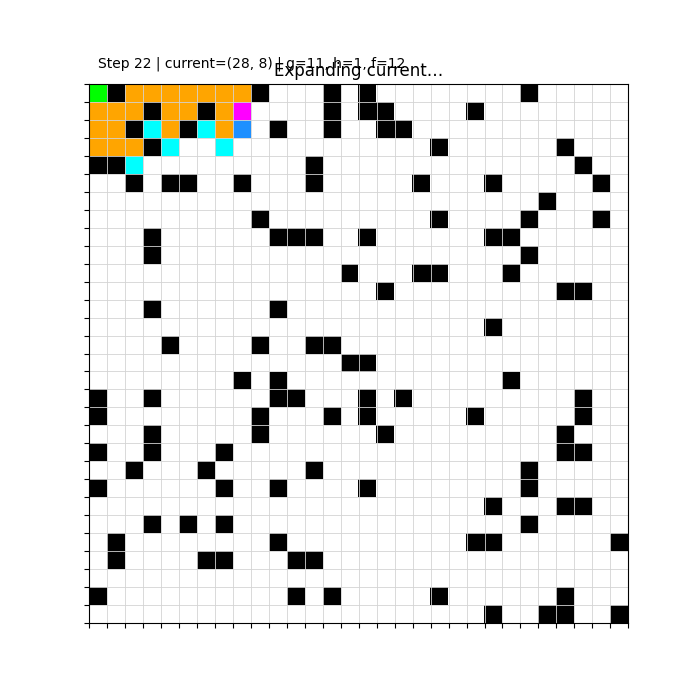

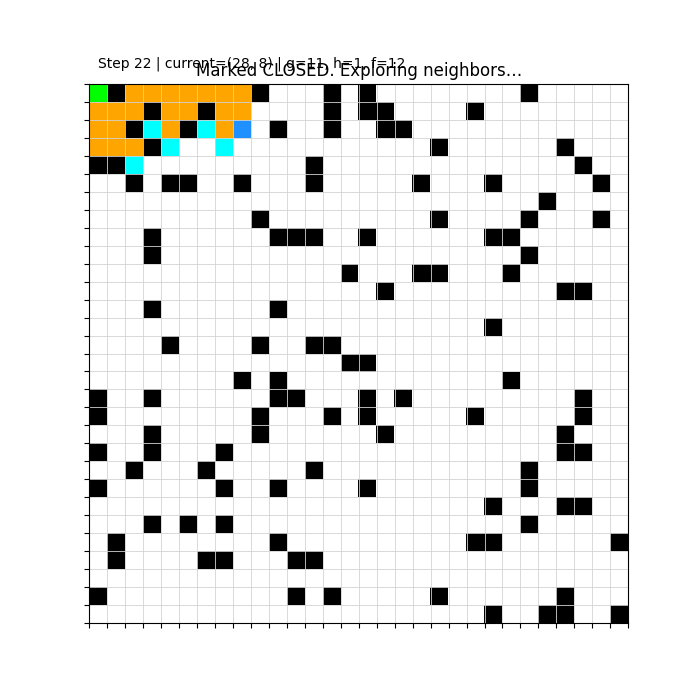

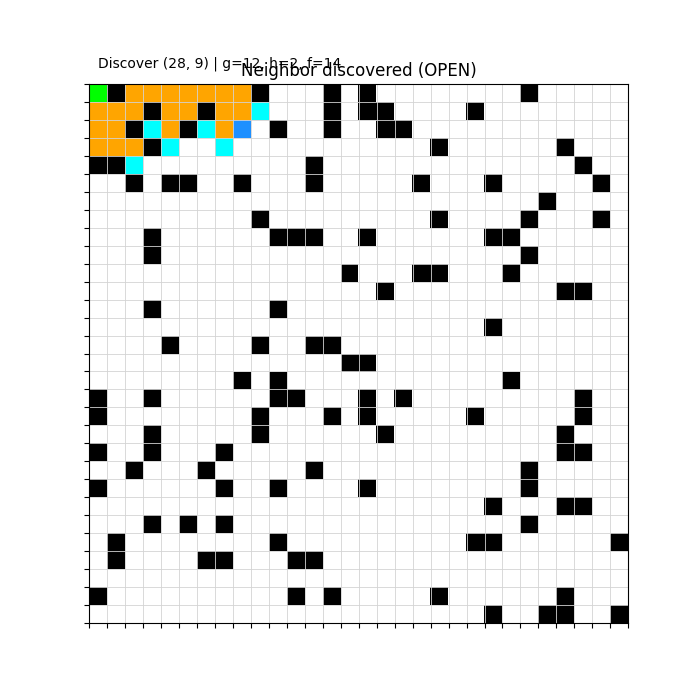

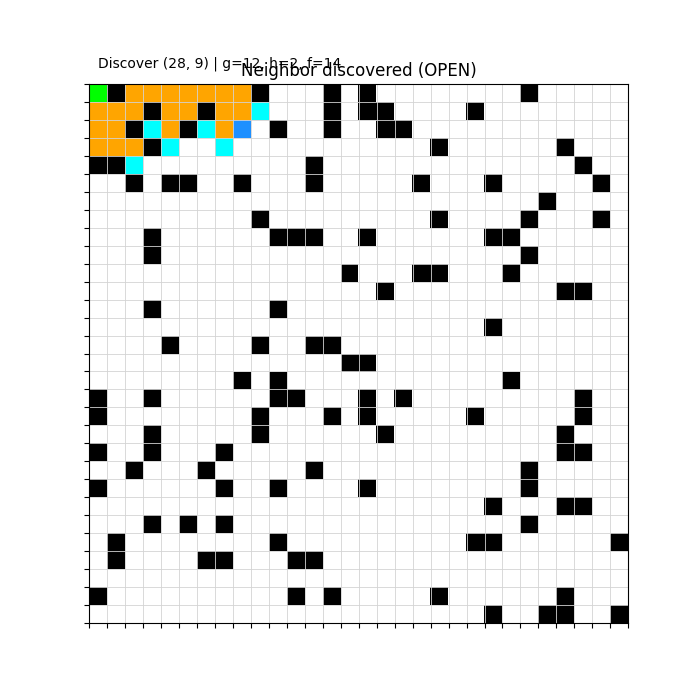

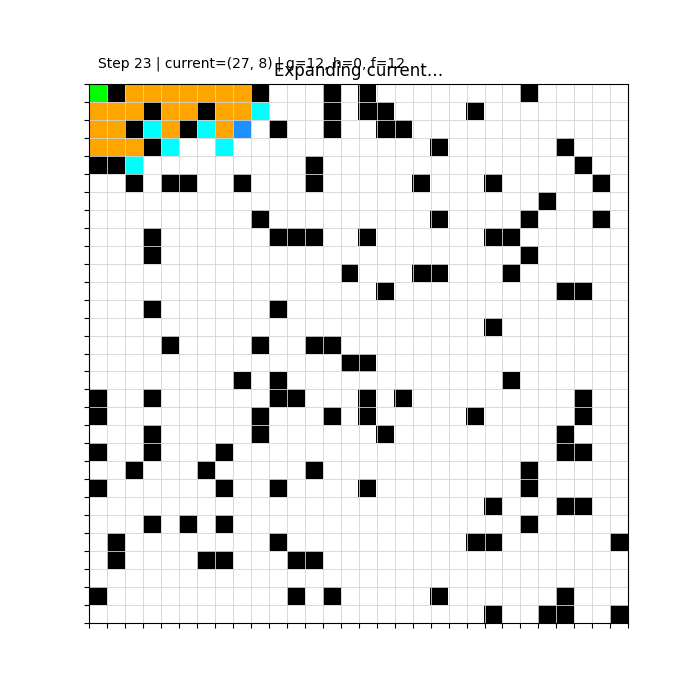

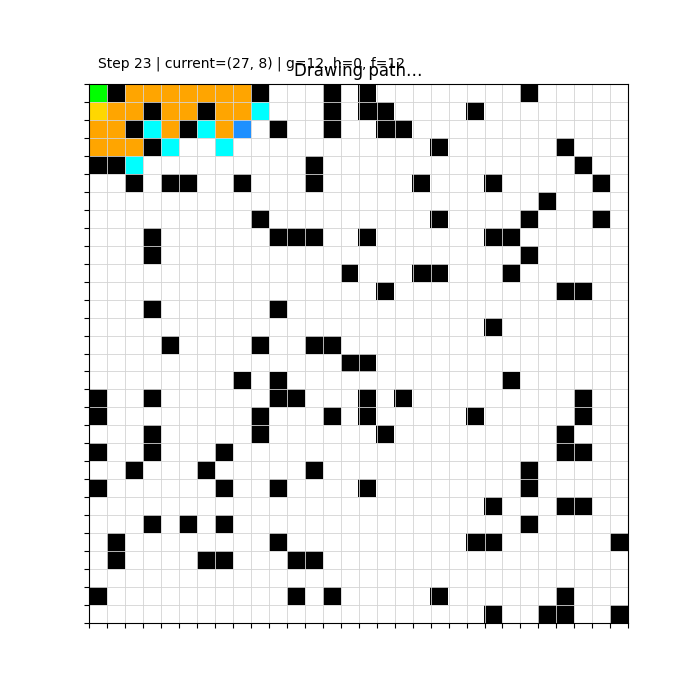

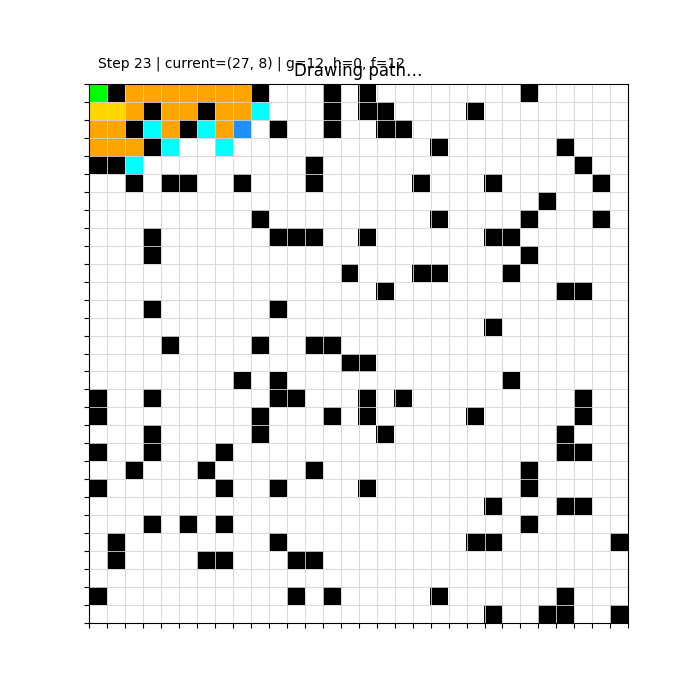

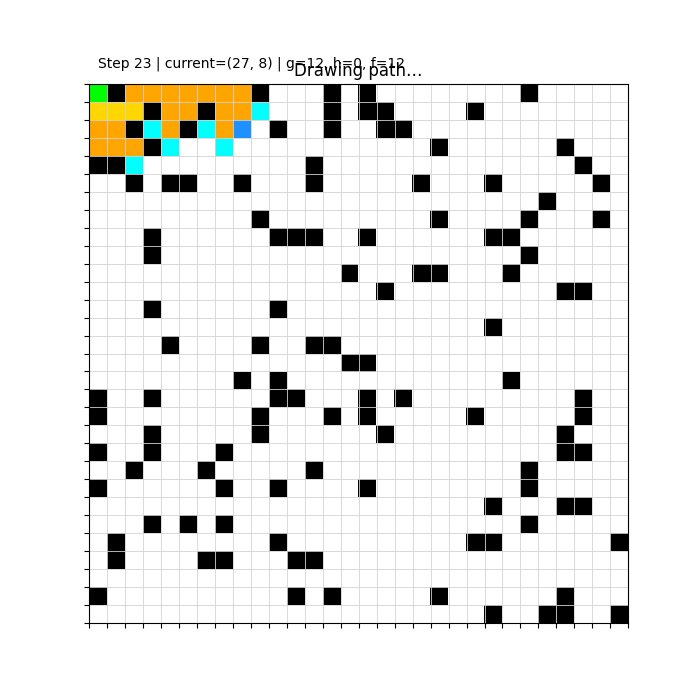

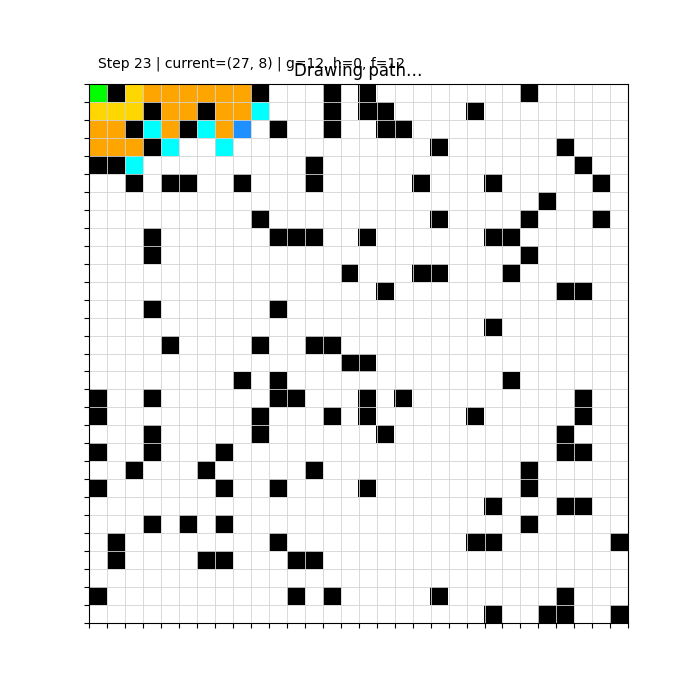

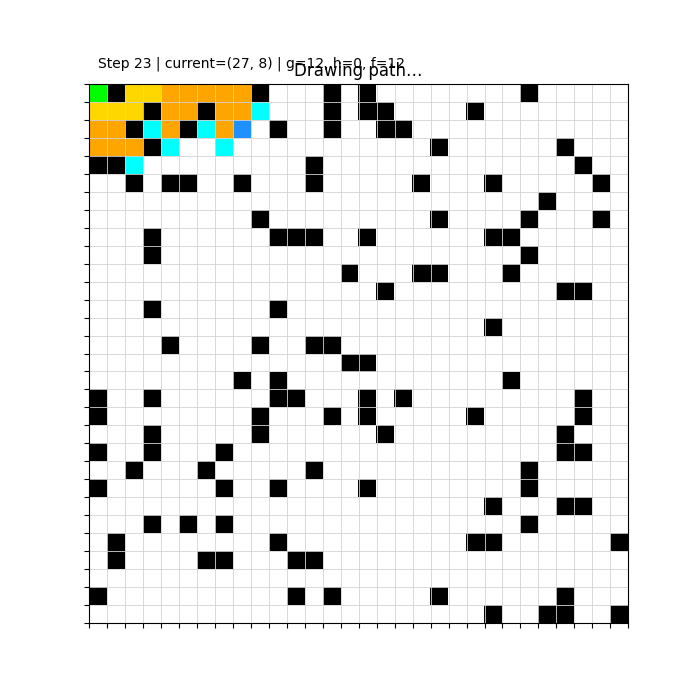

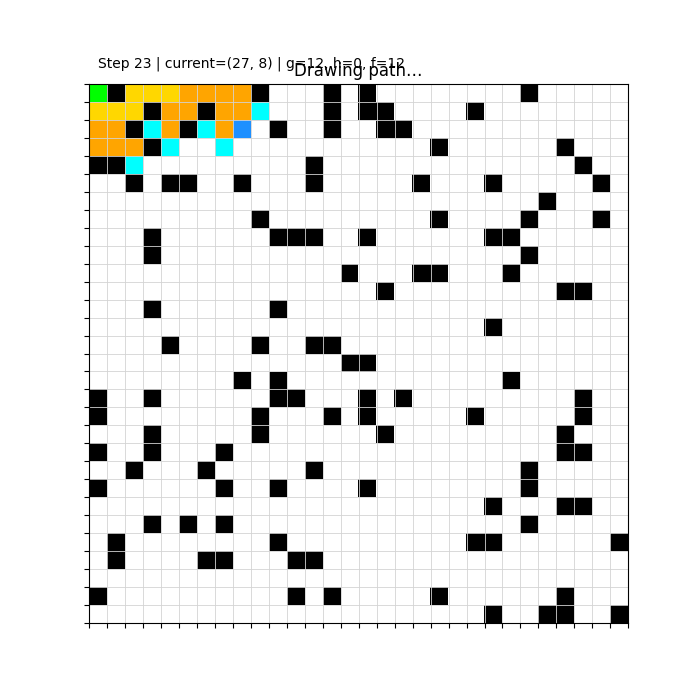

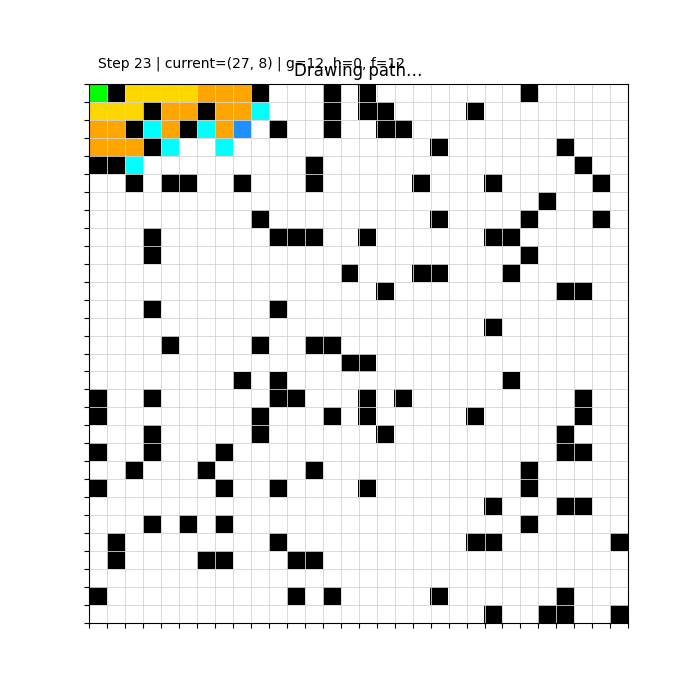

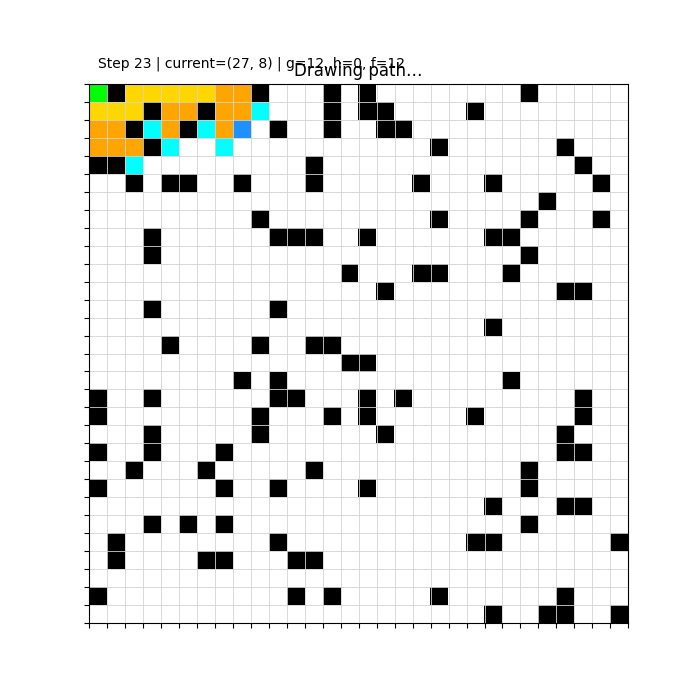

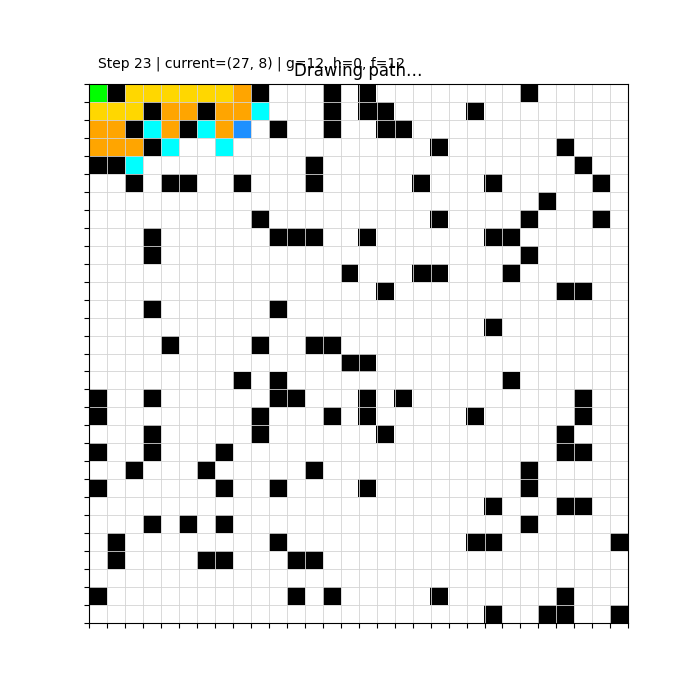

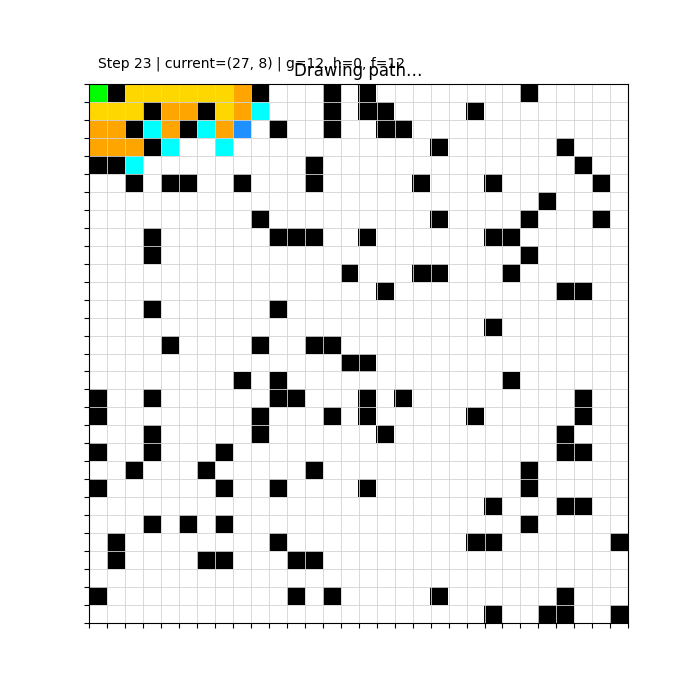

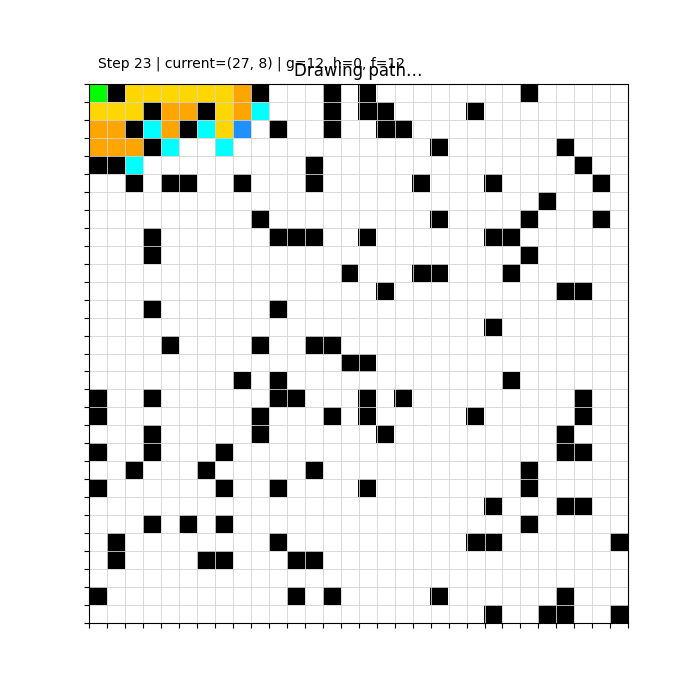

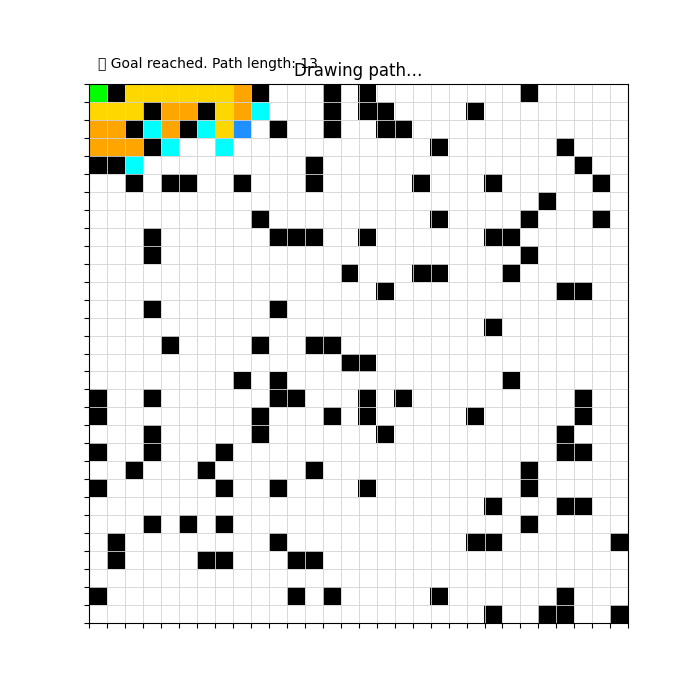

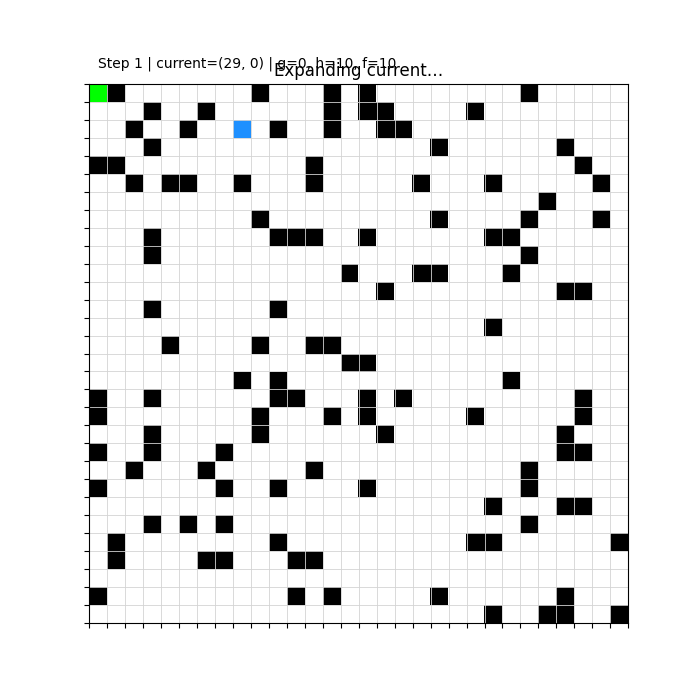

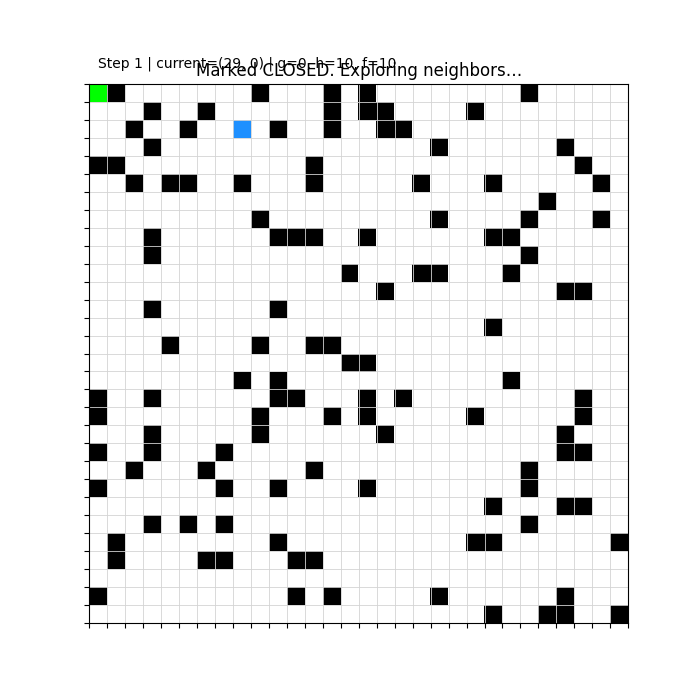

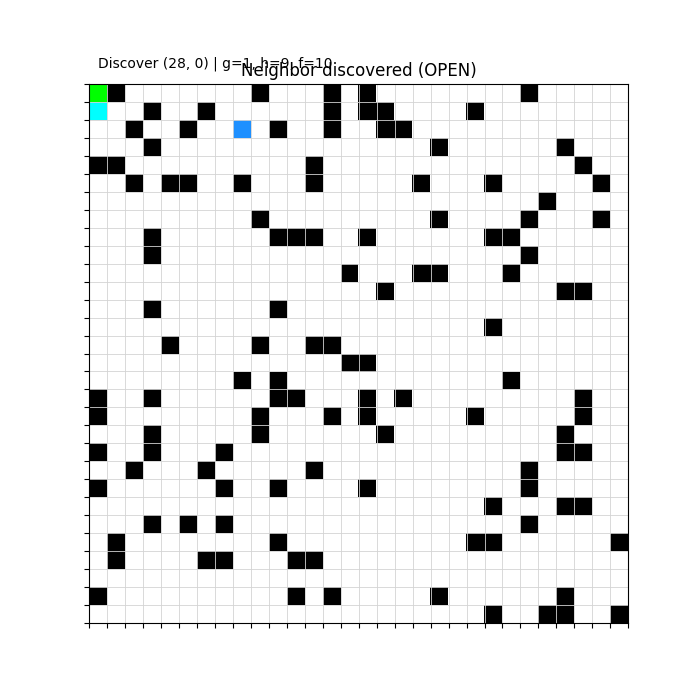

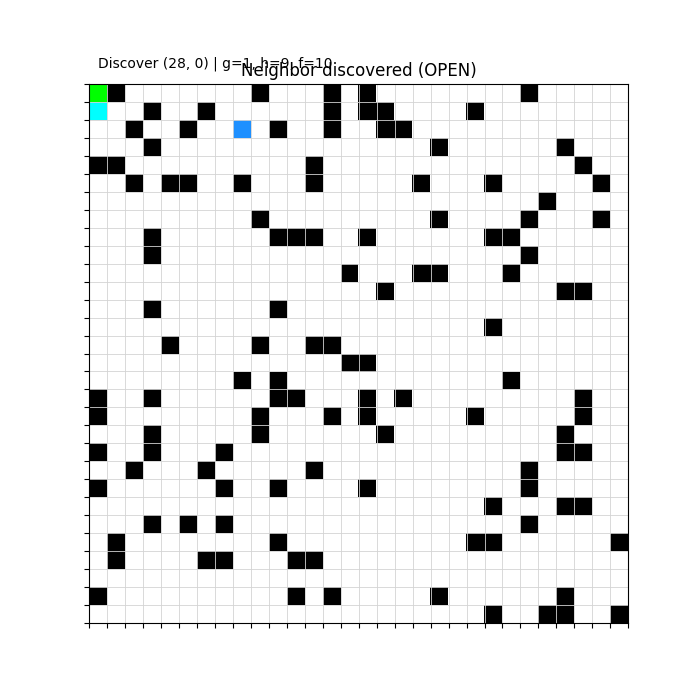

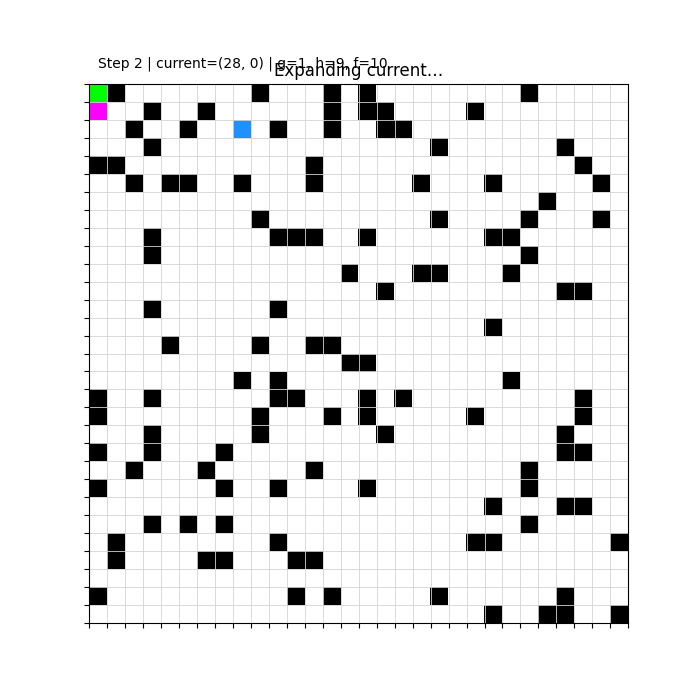

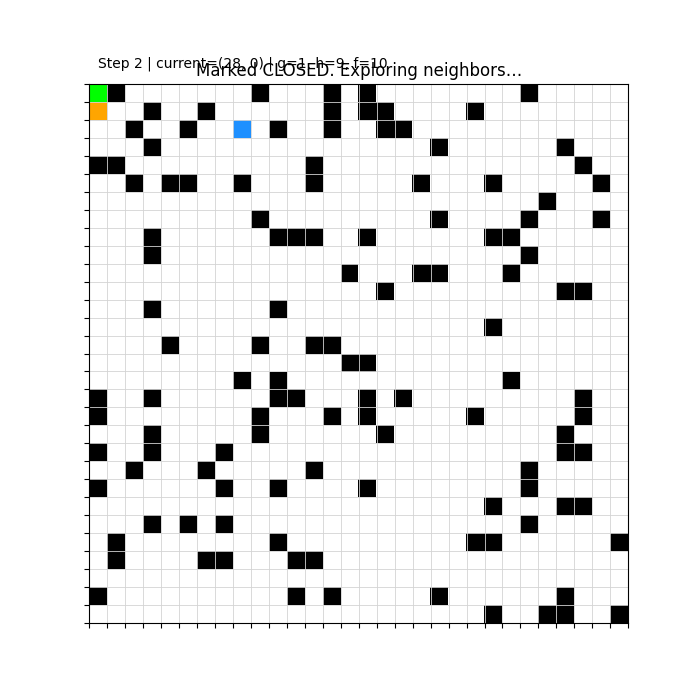

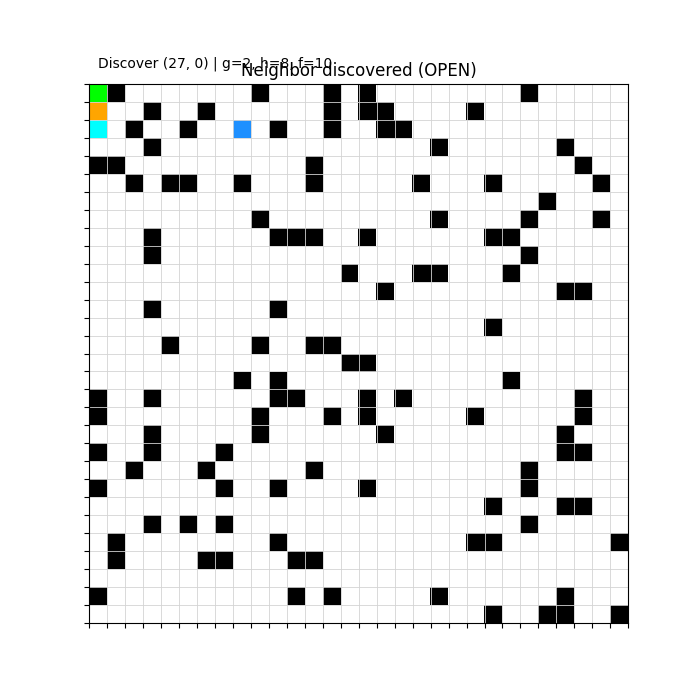

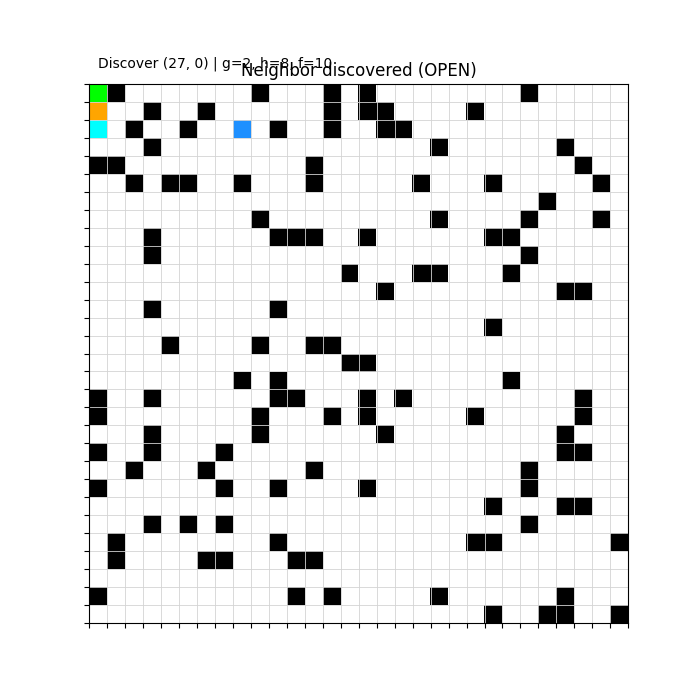

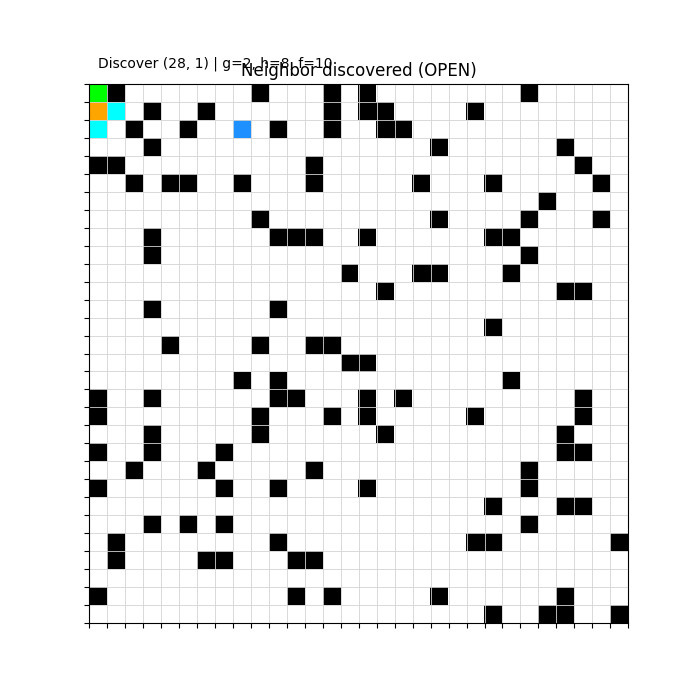

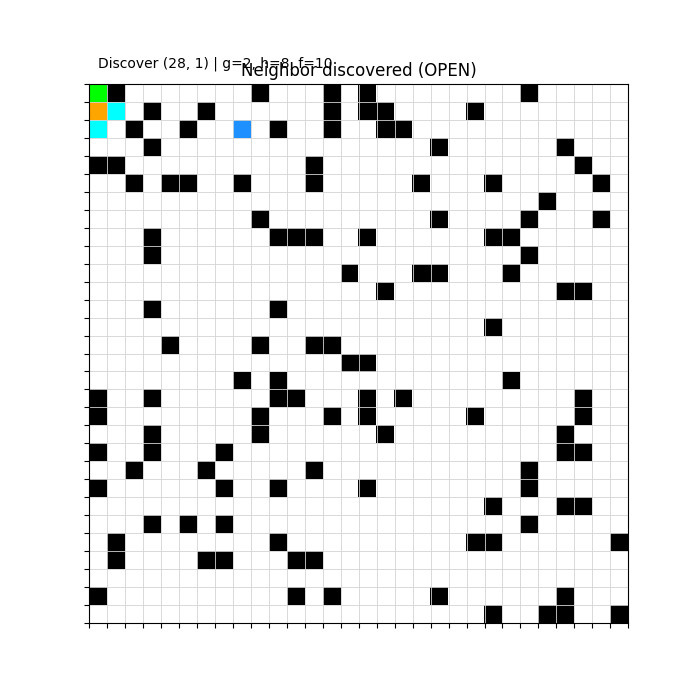

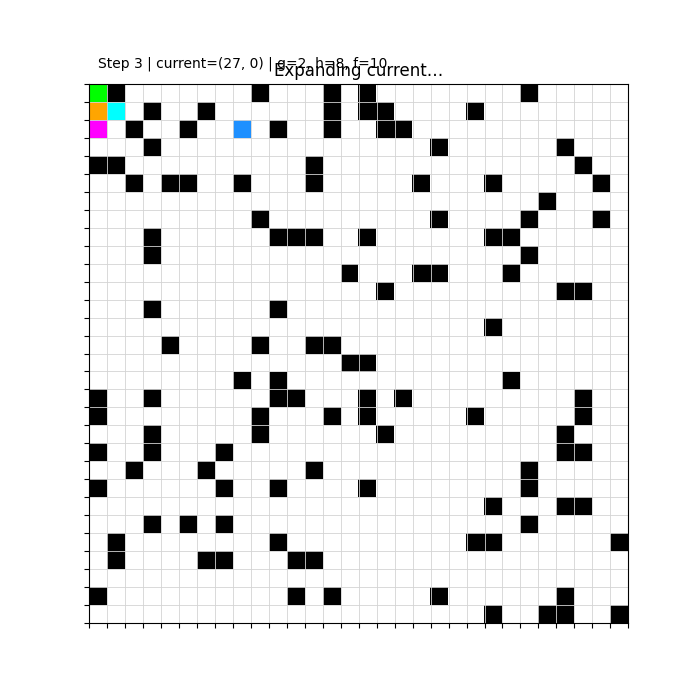

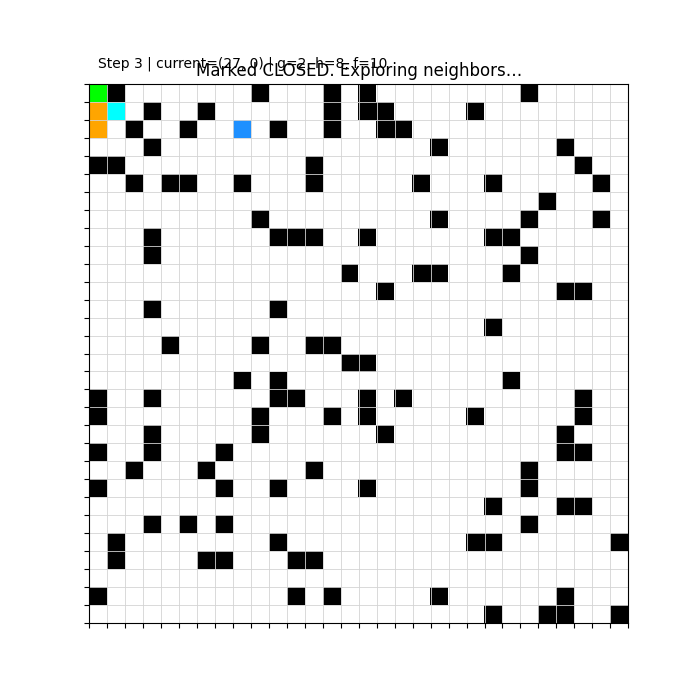

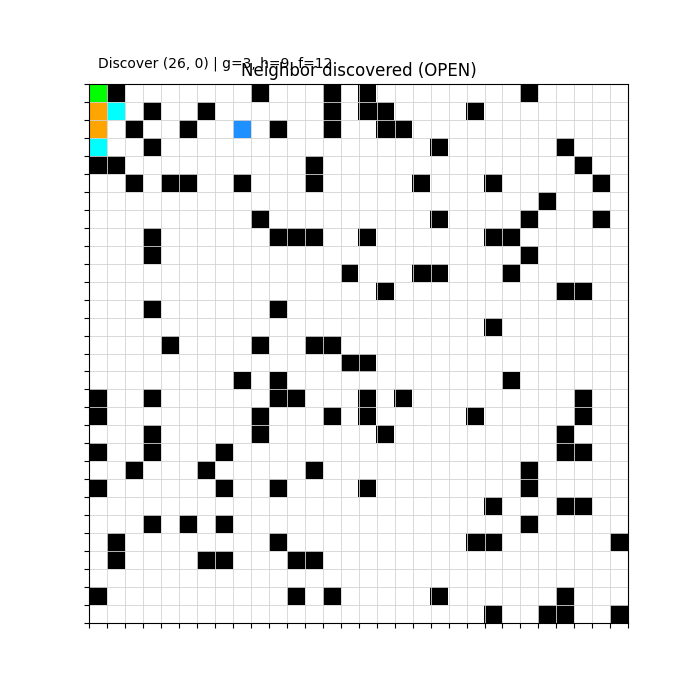

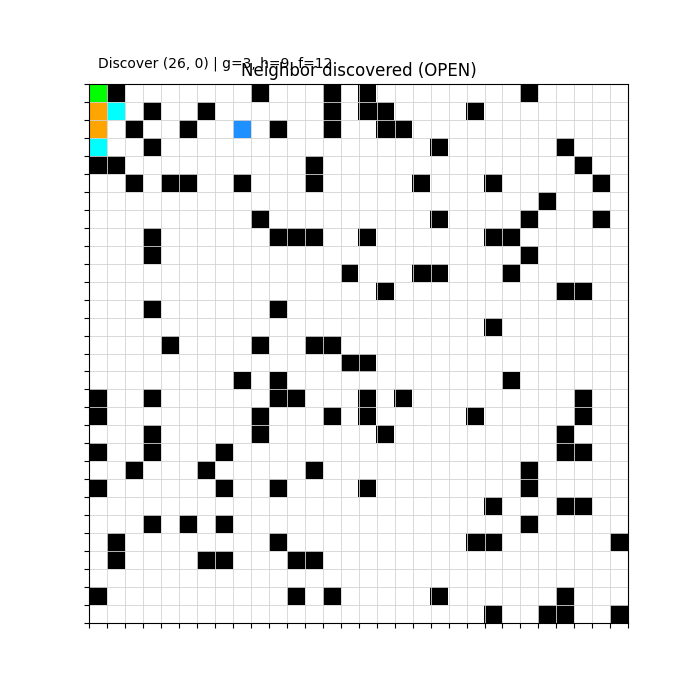

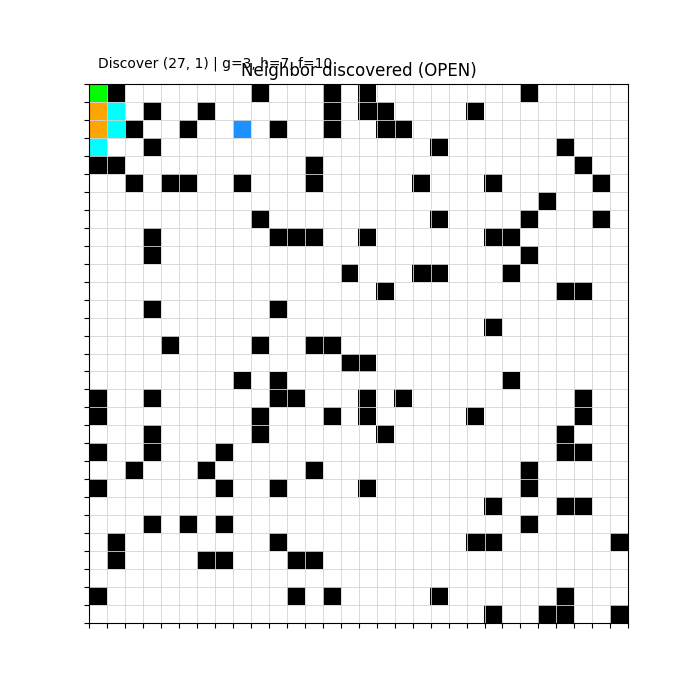

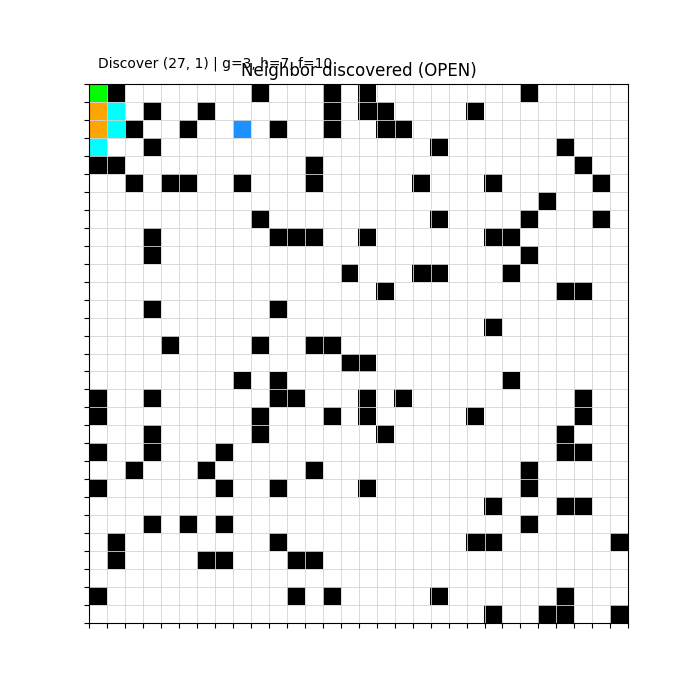

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import heapq

# Cell values
FREE, OBST, START, GOAL, OPEN, CLOSED, PATH, CURRENT = 0, 1, 2, 3, 4, 5, 6, 7

def interactive_grid(n=50, obstacle_prob=0.20, seed=None, step_delay=0.15):
    rng = np.random.default_rng(seed)
    grid = (rng.random((n, n)) < obstacle_prob).astype(np.uint8)

    # Colors (discrete, fixed vmin/vmax)
    cmap = ListedColormap([
        "white",      # 0 FREE
        "black",      # 1 OBST
        "lime",       # 2 START
        "dodgerblue", # 3 GOAL
        "cyan",       # 4 OPEN
        "orange",     # 5 CLOSED
        "gold",       # 6 PATH
        "magenta"     # 7 CURRENT
    ])
    norm = BoundaryNorm(np.arange(-0.5, 8.5, 1), cmap.N)

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(grid, cmap=cmap, norm=norm, origin="lower",
                   interpolation="none", extent=(-0.5, n-0.5, -0.5, n-0.5))
    ax.set_xticks(np.arange(-0.5, n, 1)); ax.set_yticks(np.arange(-0.5, n, 1))
    ax.grid(color="lightgray", linewidth=0.6)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_title("Click Start (green), then Goal (blue)\n[Space]=Play/Pause  [n]=Step  [r]=Randomize", fontsize=12)
    status = ax.text(0, n+0.2, "Waiting for Start…", fontsize=10, va="bottom")

    state = {
        "stage": "start",        # start -> goal -> ready
        "start": None, "goal": None,
        "mode": "paused",        # paused | playing
        "delay": step_delay,
        "gen": None              # generator for A* steps
    }

    def to_index(xf, yf):
        if xf is None or yf is None: return None
        c = int(np.floor(xf + 0.5)); r = int(np.floor(yf + 0.5))
        if 0 <= r < n and 0 <= c < n: return r, c
        return None

    def neighbors_4(r, c):
        for dr, dc in ((1,0),(-1,0),(0,1),(0,-1)):
            rr, cc = r+dr, c+dc
            if 0 <= rr < n and 0 <= cc < n:
                yield rr, cc

    def manhattan(a, b): return abs(a[0]-b[0]) + abs(a[1]-b[1])

    def clear_layers():
        mask = (grid == OPEN) | (grid == CLOSED) | (grid == PATH) | (grid == CURRENT)
        grid[mask] = FREE

    def draw(title=None):
        if title: ax.set_title(title, fontsize=12)
        im.set_data(grid); fig.canvas.draw_idle(); plt.pause(state["delay"])

    # ---- A* generator: yields after each meaningful step ----
    def astar_steps(s, g):
        clear_layers()
        g_score = {s: 0}
        open_heap = [(manhattan(s, g), 0, s)]
        came_from = {}
        closed = set()
        step = 0
        current_prev = None

        while open_heap:
            f, gcur, cur = heapq.heappop(open_heap)
            if cur in closed:
                continue
            step += 1

            # clear previous CURRENT mark
            if current_prev and grid[current_prev] == CURRENT:
                grid[current_prev] = CLOSED
            # mark current
            if cur not in (s, g):
                grid[cur] = CURRENT
            current_prev = cur

            hcur = manhattan(cur, g)
            status.set_text(f"Step {step} | current={cur} | g={gcur}, h={hcur}, f={f}")
            draw("Expanding current…")

            if cur == g:
                # reconstruct path
                path = [cur]
                while cur in came_from:
                    cur = came_from[cur]
                    path.append(cur)
                path.reverse()
                for r, c in path:
                    if (r, c) not in (s, g):
                        grid[r, c] = PATH
                        draw("Drawing path…")
                status.set_text(f"✅ Goal reached. Path length: {len(path)}")
                yield ("done",)
                return

            closed.add(cur)
            if cur not in (s, g): grid[cur] = CLOSED
            draw("Marked CLOSED. Exploring neighbors…")

            cr, cc = cur
            for nr, nc in neighbors_4(cr, cc):
                nxt = (nr, nc)
                if grid[nxt] == OBST or nxt in closed:
                    continue
                tentative = gcur + 1
                if nxt not in g_score or tentative < g_score[nxt]:
                    g_score[nxt] = tentative
                    came_from[nxt] = cur
                    fscore = tentative + manhattan(nxt, g)
                    heapq.heappush(open_heap, (fscore, tentative, nxt))
                    if nxt not in (s, g) and grid[nxt] not in (OPEN, CLOSED, CURRENT, PATH):
                        grid[nxt] = OPEN
                    status.set_text(f"Discover {nxt} | g={tentative}, h={manhattan(nxt,g)}, f={fscore}")
                    draw("Neighbor discovered (OPEN)")
                    yield ("discover", nxt)

        status.set_text("❌ No path. Press 'r' to randomize.")
        yield ("nopath",)

    # ---- helpers for play/step ----
    def ensure_gen():
        if state["gen"] is None and state["start"] and state["goal"]:
            state["gen"] = astar_steps(state["start"], state["goal"])

    def step_once():
        ensure_gen()
        if state["gen"] is None: return False
        try:
            next(state["gen"])
            return True
        except StopIteration:
            state["gen"] = None
            return False

    # ---- events ----
    def on_click(event):
        idx = to_index(event.xdata, event.ydata)
        if event.inaxes != ax or idx is None: return
        r, c = idx
        if grid[r, c] == OBST:
            status.set_text("⚠️ That cell is an obstacle.")
            draw(); return
        if state["stage"] == "start":
            grid[grid == START] = FREE
            grid[r, c] = START
            state["start"] = (r, c)
            state["stage"] = "goal"
            clear_layers(); state["gen"] = None
            status.set_text("✅ Start set. Now click Goal (blue).")
            draw()
        elif state["stage"] == "goal":
            grid[grid == GOAL] = FREE
            grid[r, c] = GOAL
            state["goal"] = (r, c)
            state["stage"] = "ready"
            clear_layers(); state["gen"] = None
            status.set_text("✅ Start & Goal set. Space=Play, n=Step")
            draw()

    def on_key(event):
        k = (event.key or "").lower()
        if k == "r":
            grid[:, :] = (rng.random((n, n)) < obstacle_prob).astype(np.uint8)
            grid[grid == START] = FREE; grid[grid == GOAL] = FREE
            clear_layers()
            state.update({"stage":"start","start":None,"goal":None,"mode":"paused","gen":None})
            status.set_text("Map randomized. Click Start (green).")
            draw("Click Start (green), then Goal (blue)")
        elif k == "n":
            if state["stage"] != "ready":
                status.set_text("⚠️ Set Start & Goal first."); draw(); return
            state["mode"] = "paused"
            progressed = step_once()
            if not progressed:
                status.set_text("ℹ️ Finished (no more steps)."); draw()
        elif k == " ":
            if state["stage"] != "ready":
                status.set_text("⚠️ Set Start & Goal first."); draw(); return
            state["mode"] = "playing" if state["mode"] == "paused" else "paused"
            if state["mode"] == "playing":
                ensure_gen()
                # simple while-loop animation (robust in VS Code notebooks)
                while state["mode"] == "playing":
                    progressed = step_once()
                    if not progressed:
                        state["mode"] = "paused"
                        break
                    plt.pause(state["delay"])

    fig.canvas.mpl_connect("button_press_event", on_click)
    fig.canvas.mpl_connect("key_press_event", on_key)
    plt.show()
    return grid

# Run it
grid = interactive_grid(n=30, obstacle_prob=0.15, seed=None, step_delay=0.20)
